# "MicroMouse" : Motor Selection

Below is an analysis used to determine a suitable motor for a robot designed for Dr. MacIver's lab. The intention of this robot is to act as a predeator and chase mice around a habit.
***

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import csv

## Design Contraints / Requirements

The robot will operate a hexagonal shapped habit with vinyl flooring that is ~3m in length across longest vertices and has various hexagonal shaped obstacles. Ideally, the robot will fit through the smallest potential opening, which given the obstacle spacing is a litte larger than 6cm. 

The mice move up to 1.7 m/s. If possible we would like the robot to move around 3 m/s, but at minimum it should be quicker than the mice, so at least 2 m/s linearly. The micromouse robots use cornering speed around 1 m/s and turn between 60 and 120 degrees.  

# THE CALCULATIONS AND GRAPHS BELOW ARE ACTUAL MICE DATA

Lets load the mice velocity data, so we can use it for simualtions later

In [2]:
# DOWNLOADS FOR MOUSE DATA
# % reset -f
import requests
# from google.colab import files
 
def cast(s):
    cf = True
    try:
        float(s)
    except ValueError:
        cf = False
    ci = True
    if cf:
        try:
            ci = int(s) == float(s)
        except ValueError:
            ci = False
    else:
        ci = False

    if ci:
         return int(s)
    if cf:
         return float(s)
    return s

def download (url, path = None):
    web_get = requests.get(url)
    if not path:
        path = url.split("/")[-1]
    with open(path, "wb") as f:
        f.write(web_get.content)
 


#download modules
download("https://github.com/germanespinosa/images/raw/master/map.py")
download("https://github.com/germanespinosa/images/raw/master/display.py")
download("https://github.com/germanespinosa/images/raw/master/world.py")
download("https://github.com/germanespinosa/images/raw/master/heat_map.py")
download("https://github.com/germanespinosa/images/raw/master/web_resources.py")
download("https://github.com/germanespinosa/images/raw/master/visibility.py")
download("https://github.com/germanespinosa/images/blob/master/data.json?raw=true", "data.json")
download("https://maciver-lab.github.io/plangame/maps/savanna.json")

#configure font
import matplotlib.font_manager as fm
 
download("https://github.com/germanespinosa/images/raw/master/Myriad%20Pro%20Regular.ttf","Myriad-Pro-Regular.ttf")
prop = fm.FontProperties(fname="Myriad-Pro-Regular.ttf")
fm.fontManager.addfont("Myriad-Pro-Regular.ttf")
font_name = prop.get_name()

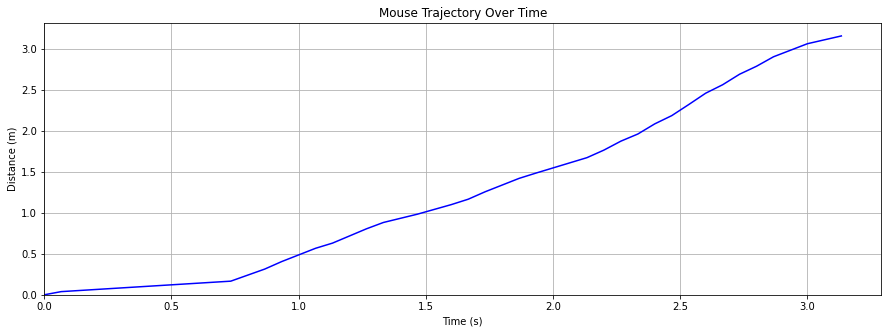

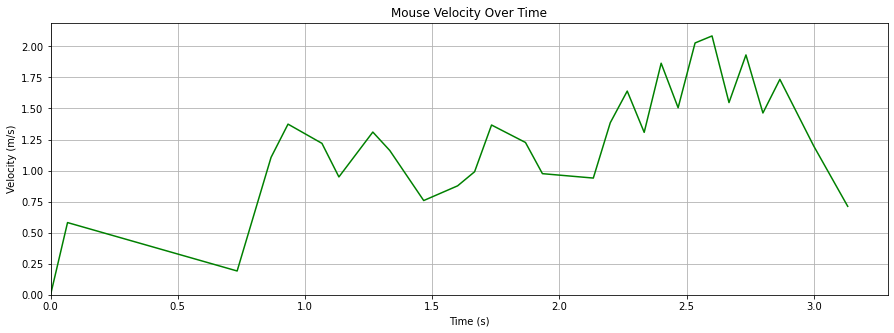

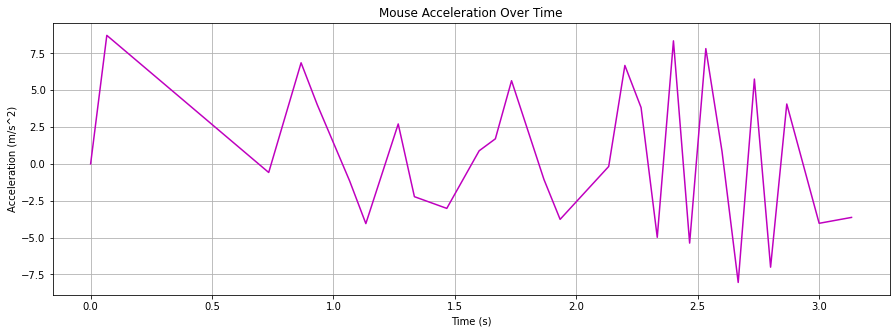

In [3]:
#RAW COORDINATE TEST
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from world import World

world_name = "hexa_10_05"
file_name = "20210423_1520_FMM1_10_05_test.json"

w = World(world_name)
x = []
y = []
c = []
for cell in w.cells:
    x.append(cell["location"]["x"])
    y.append(cell["location"]["y"])
    c.append("white" if cell["occluded"] == 0 else "black")

y = [y*math.sqrt(3) for y in y]
# plt.style.use("dark_background")

# fig, ax = plt.subplots(1, 1, figsize=(10, 9))
# plt.scatter(x, y, c=c, alpha=1,  marker="h", s=825)

f = open(file_name)
data = json.load(f)
cmap=plt.get_cmap('jet')
color_index = np.linspace(0, 1,len(data))

# ax.set_title(name)
for j in (data['episodes']):
    count = 0
    x_coord=[]
    y_coord=[]
    distance = []
    distance_meter = []
    velocity = []
    accel = []
    time = []
    frame =[]
    first_coord = [j['trajectories'][0]['location']['x'],
                j['trajectories'][0]['location']['y']]
    first_frame = j['trajectories'][0]['frame']
    previous_coord = first_coord
    previous_frame = first_frame
    previous_dist = 0
    previous_dist_meter = 0
    prev_vel = 0

    fx = -1000
    fy = -1000
    i =1
    for y in (j['trajectories']):
        new_coord = [y['location']['x'],
                      y['location']['y']]

        time.append(y['frame']*(1/15))
        frame.append(y['frame'])

        if fx == -1000:
            fx = new_coord[0]
        if fy == -1000:
            fy = new_coord[1]
        fx = fx * (1-i) + new_coord[0] * i
        fy = fy * (1-i) + new_coord[1] * i
        x_coord.append(fx)
        y_coord.append(fy)
        step_dist = math.sqrt((new_coord[0]-previous_coord[0])**2 + (new_coord[1]-previous_coord[1])**2)
        step_dist_meter = 2.34/(220*20)*step_dist*220*20
        step_time = (y['frame']-previous_frame)*(1/15)

#         total_distance = previous_dist + step_dist
        total_distance_meter = previous_dist_meter + step_dist_meter
#         distance.append(total_distance)
        distance_meter.append(total_distance_meter)
        if step_time == 0:
            velocity.append(0)
        else:
            vel = step_dist_meter/step_time
            velocity.append(vel) 
        count = count + 1;
        previous_frame = y['frame']
        previous_coord = new_coord
#         previous_dist = total_distance
        previous_dist_meter = total_distance_meter
        
y_coord_hex = [y*200*20-(200*20)/2 for y in y_coord]
x_coord_hex = [(1-x)*220*20-(220*20)/2 for x in x_coord]
# print(velocity)

max_velocity = max(velocity)
max_index = velocity.index(max_velocity) 

#PLOT VELOCITIES OVER TIME
# fig2, ax0 = plt.subplots(figsize=(10, 9))

mouse_v2=[]
# i = (.1) # Filter value, this is used to average the velocities
i = 1 # With a filter of one, we get the actual values, not averaged
nv = 0
for v in velocity:
    nv = nv * (1-i) + v * i
    mouse_v2.append (nv)
    
seconds = []
for f in frame:
    sec = (f - 66)/15
    seconds.append(sec)

mouse_accel = []
vel_len = len(mouse_v2)
mouse_accel.append(0)
for k in range(0, vel_len-1):
    vk = mouse_v2[k]
    vk1 = mouse_v2[k+1]
    t1 = seconds[k]
    t2 = seconds[k+1]
    dT = t2 - t1
    dv = vk1 - vk
    a = dv / dT
    mouse_accel.append(a)
    
#     if a > 0:
#         accel.append(a)
#     else:
#         accel.append(0)
    
    
fig10, ax10 = plt.subplots(figsize=(15, 5))
ax10.set_ylabel('Distance (m)')
ax10.set_xlabel('Time (s)')
ax10.plot(seconds,distance_meter, "-b")
ax10.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
ax10.set_ylim(bottom= 0)
ax10.set_xlim(left= 0)
ax10.set_title("Mouse Trajectory Over Time")

fig0, ax0 = plt.subplots(figsize=(15, 5))
ax0.plot(seconds,mouse_v2, "-g")
ax0.set_ylabel('Velocity (m/s)')
ax0.set_xlabel('Time (s)')
ax0.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
ax0.set_ylim(bottom= 0)
ax0.set_xlim(left= 0)
ax0.set_title("Mouse Velocity Over Time")

fig100, ax100 = plt.subplots(figsize=(15, 5))
ax100.plot(seconds,mouse_accel, "-m")
ax100.set_ylabel('Acceleration (m/s^2)')
ax100.set_xlabel('Time (s)')
ax100.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
# ax100.set_ylim(bottom= 0)
ax100.set_title("Mouse Acceleration Over Time")

plt.show()

The mouse velocity vs time graph above just shows instantaneous velocities, so it doesn't mean that the mice reach 2m/s in 2.5 seconds, just that at 2.5 seconds the mouse happened to be moving that fast. So use this graph to get a general idea of the velocity ranges the mice move at. 

## DO I CARE ABOUT DECELERATION OR NOT?

## Electrical motor specs

In order to derive the equations that govern a motor's behavior,  we first have to look at the electrical specs. The electrical power is going to be out input power after all, and the output power will be the mechanical power. 

Simply put, the input electrical power is...
 
$P_e = IV$

*Where I is current and V is Votlage*

However, this Input Power has to account for the Mechanical Output Power ($\tau\omega$) as well as power lost through heat dissipation and such. Therefore...

$IV = (\tau_{out} G)(\frac{\omega_{out}}{G}) + {I}^2 R + LI \frac{dI}{dt}$

*Where $G$ is the gear reduction*

Dividing by $I$ we can get an equation for the Voltage:

$V = \frac{\tau_{out}G}{I} (\frac{\omega_{out}}{G}) + IR + L \frac{dI}{dt}$


$\frac{\tau}{I}$ is a constant value, given Lorentz force law. This constant is called the torque constant $k_t$

$k_t = \frac{\tau}{I}$

$k_t G = \frac{\tau_{out}G}{I}$

$\tau_{out} = \frac{k_t I}{G}$

Rewrite the Voltage equation to incorparate the torque constant...

$V = k_t G \frac{\omega_{out}}{G} + IR + L \frac{dI}{dt}$

Going back to the Speed-Torque curve, we can assume that at a constant speed and constant torque the Voltage equation is reduced to...

$V = k_t G \frac{\omega_{out}}{G} + IR $

Solving for $\omega$ ...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Here, we can calculate the no load speed and stall torque given the electrical specs of the motor

$\omega_0 = \frac{V}{k_t}$

$\tau_s = \frac{k_t V}{R}$

## "RACE" SIMULATIONS

Considering that the motors have variable acceleration and velocities, perhaps the best place to start comparing motors is by simulaitng a "race" with various motors. These simulaitons only take into account motor parameters such as the torque constant $k_t$, voltage $V$, a motor's resistance $R$ and so on, parameters which we used in the governing equations above.  


Given the electrical input power equations above, we solved for $\omega$ given a motor's torque constant, voltage and resistance...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Now lets rearrange this equation to solve for torque:

$\omega - \frac{1}{k_t} V = - \frac{R}{{k_t}^2} \tau$

$\frac{R}{{k_t}^2} \tau = \frac{1}{k_t} V - \omega$

$R \tau = V k_t - \omega {k_t}^2$

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

Assuming a 100% effiecent motor, we can use these mechanical eqautions...

$F = ma$

$\tau = Fr = mar$

$v = \omega r$

$\omega = \frac{v}{r}$


Sub the appropriate equations into $\tau$ and $\omega$...

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

$mar = \frac{V k_t - \frac{v}{r} {k_t}^2}{R} = \frac{V k_t}{R} - \frac{v {k_t}^2}{Rr}$

$a = \frac{V k_t}{Rmr} - \frac{v {k_t}^2}{Rm{r}^2}$

$0 = a + \frac{v {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} $


Now that we've elimated torque and radial velocity from our equation, we have a function that is governed by two non-constant vairbles, acceleration $a$ and linear velocity $v$. Fortunately, both these varibales can be represented by 2nd and 1st order differentials of displacement over time (respectively). Now lets represent our funciton as only dependent on displacement over time....

$\frac{{d}^2 x}{d{t}^2} + \frac{\frac{dx}{dt} {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} = 0$


Eliminate the constant value so we can solve for a solution:

$\frac{{d}^2 x}{d{t}^2} + \frac{{k_t}^2 \frac{dx}{dt}}{Rm{r}^2} = 0$


Assume the solution will be porpoertional to ${e}^{\lambda t}$ and sub $x(t)= {e}^{\lambda t}$ into the diff eq:

$\frac{{d}^2}{d{t}^2} {e}^{\lambda t} + \frac{{k_t}^2 \frac{d}{dt} {e}^{\lambda t}}{Rm{r}^2} = 0$

${\lambda}^2 {e}^{\lambda t} + \frac{{k_t}^2 \lambda {e}^{\lambda t}}{Rm{r}^2} = 0$

$({\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2}) {e}^{\lambda t} = 0$


Since ${e}^{\lambda t}$ CANNOT equal 0...

${\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2} = 0$

$\frac{\lambda ({k_t}^2 + \lambda Rm{r}^2)}{Rm{r}^2} = 0$


Solving for $\lambda$....

$\lambda = 0$

and

$\lambda = - \frac{{k_t}^2}{Rm{r}^2}$


For complementary solutions a root of $\lambda = 0$ gives $x_1(t) = c_1$

Also a root $\lambda = - \frac{{k_t}^2}{Rm{r}^2}$ gives $x_2(t) = c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$

Therefore the general solution is 

$x(t) = x_1 (t) + x_2 (t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$


Great! Now determine the particular solution by the method of undetermined coefficients where $x_p(t) = a_1 t$:

$\frac{dx_p(t)}{dt} = \frac{d}{dt}(a_1 t) = a_1$

$\frac{{d}^2 x_p(t)}{d{t}^2} = \frac{{d}^2}{d{t}^2} (a_1 t) = 0$

$\frac{{d}^2 x_p (t)}{d{t}^2} + \frac{{k_t}^2 \frac{d x_p (t)}{dt}}{Rm{r}^2} = \frac{k_t V}{R m r}$

$\frac{{k}^2 a_1}{Rm{r}^2} = \frac{k_t V}{Rmr}$

$a_1 = \frac{rV}{k_t}$

$x_p(t) = \frac{rVt}{k_t}$


Making the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$


Now lets solve with our givens $x(0) = 0$ and $\frac{dx}{dt}(0) = 0$. For t = 0 and x(0) = 0...

$c_1 + c_2 = 0$


Taking the derivative of our general solution we get:

$\frac{dx(t)}{dt} = \frac{rV}{k} - \frac{{k_t}^2 c_2 e^{-\frac{{k_t}^2 t}{Rm{r}^2}}}{Rm{r}^2}$


Subbing in $\frac{dx}{dt}(0) = 0$ for t = 0...

$\frac{rV}{k} - \frac{{k}^2 c_2}{Rm{r}^2} = 0$

$c_2 = \frac{Vm {r}^3 R}{{k}^3}$


Which means...

$c_1 = - \frac{Vm {r}^3 R}{{k}^3}$


Plugging the constants into the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = - \frac{V Rm {r}^3}{{k}^3} + \frac{VRm {r}^3}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = rV(- \frac{Rm {r}^2}{{k}^3} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{t}{k_t})$

$x(t) = rV( \frac{t}{k_t} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - \frac{Rm {r}^2}{{k}^3})$

$x(t) = \frac{rV( {k_t}^2 t + Rm{r}^2 ({e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - 1))}{{k_t}^3}$

We now have an equation for displacement over time, which, aside from the motor specs, is only dependent on wheel radius and time. But there are two more elements that have to be taken into consideration: gear reductions and motor efficieny. Luckily, the only varible influcened by a gear reduction and motor efficieny is $k_t$. This is because...

$k_t = \frac{\tau}{I}$

And if you multiply the torque by the gear reduction $G$ then the torque constant $k_t$ must be proportionately scaled. 

$k_t G = \frac{\tau_{out}G}{I}$

Given the equation below for efficiency $\eta$, how can I incorporate that into my simulation equation?

$\eta = \frac{\tau_{out} \omega}{IV} = \frac{k_t \omega}{V}$

<!-- $k_t G \eta = \frac{\tau_{out}G \eta}{I}$   **Is this correct?** -->

Therefore our final equation that we will be simulating is (WITHOUT EFFICIENCY)...

$x(t) = \frac{rV( {(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G)}^3}$

<!-- $x(t) = \frac{rV( {(k_t G \eta)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G \eta)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G \eta)}^3}$ -->

## Robot Velocity, take derivative of x(t) equation. 

Given the displacement vs time equation from before...

$x(t) = \frac{rV( {(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G)}^3}$

Take the derivative of that equation to find the realtionship of velocity vs time. Lets start by rearranging it a bit.

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))$

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - Rm{r}^2)$

Now lets take the derivative with respect to $t$...

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 + Rm{r}^2 \frac{{(-k_t G)}^2}{Rm{r}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 -{{(k_t G)}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x'(t) = \frac{rV}{(k_t G)} (1 - {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

## Robot Acceleration, take derivative of x'(t) equation. 

Given the velocity vs time equation from before...

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 -{{(k_t G)}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

Take the derivative of that equation to find the realtionship of accleration vs time.

$x''(t) = \frac{rV}{{(k_t G)}^3} (-{{(k_t G)}^2} \frac{{-(k_t G)}^2}{Rm{r}^2}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x''(t) = \frac{rV}{{(k_t G)}^3} (\frac{{(k_t G)}^4}{Rm{r}^2}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x''(t) = \frac{V k_t G }{Rmr}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}}$

## Find the power at each time step

Given the linear velocity derived above and a given wheel radius, calculate the angular velocity at each time step. Also given the mouse's acceleration at each time step, a robot's mass and again wheel radius, determine the torque at each timestep. With angualr velocity and torque, determine the power at each time step

From our previous calculations, we know that we have the input electrical power $P_e = IV$ and our output mechancial power $P_{mech} = \tau \omega$. However, not all of the input power is converted to electrical power since motors are not 100% efficient. The effeciency of a motor is determined by...

$\eta = \frac{P_{mech}}{P_e} =  \frac{\tau_{out} \omega}{IV}$

In other words

<!-- P_{input} = P_e = \frac{P_{mech}}{\eta} + {I}^2 R = \frac{\tau_{out} \omega}{\eta} + {I}^2 R -->

$P_{input} = P_e = \frac{P_{mech}}{\eta} = \frac{\tau_{out} \omega}{\eta}$

Now that we have our simualtion equations, its time to upload the motor information and simualte!

In [4]:
def read_csv(filename):
    motor_name = [] 
    nominal_V = []
    nominal_A = [] 
    single_motor_weight = [] 
    motor_no_load_RPM = [] 
    motor_max_t = [] 
    motor_stall_t = [] 
    motor_R = [] 
    motor_kt = [] 
    motor_eff = []
    motor_diam = []
    motor_stall_A = []
    motor_length = []
    
    with open(filename) as f:
        # open the csv file
        reader = csv.reader(f)
        for row in reader:
            # read the rows 1 one by one
            motor_name.append(str(row[0]))
            nominal_V.append(float(row[1]))
            nominal_A.append(float(row[2]))
            single_motor_weight.append(float(row[3]))
            motor_no_load_RPM.append(float(row[4]))
            motor_max_t.append(float(row[5]))
            motor_stall_t.append(float(row[6]))
            motor_R.append(float(row[7]))
            motor_kt.append(float(row[8]))
            motor_eff.append(float(row[9]))
            motor_diam.append(float(row[10]))
            motor_stall_A.append(float(row[11]))
            motor_length.append(float(row[12]))
         
    return motor_name, nominal_V, nominal_A, single_motor_weight, motor_no_load_RPM, motor_max_t, motor_stall_t, motor_R, motor_kt, motor_eff, motor_diam, motor_stall_A, motor_length 
    

In [5]:
filename_15W = "1.5W_motors_v2.csv"
motor_power_15W = 1.5
all_motor_name_15W, all_nominal_V_15W, all_nominal_A_15W, all_single_motor_weight_15W, all_motor_no_load_RPM_15W, all_motor_max_t_15W, all_motor_stall_t_15W, all_motor_R_15W, all_motor_kt_15W, all_motor_eff_15W, all_motor_diam_15W, all_motor_stall_A_15W, all_motor_length_15W = read_csv(filename_15W)

filename_2W = "2W_motors_v2.csv"
motor_power_2W = 2
all_motor_name_2W, all_nominal_V_2W, all_nominal_A_2W, all_single_motor_weight_2W, all_motor_no_load_RPM_2W, all_motor_max_t_2W, all_motor_stall_t_2W, all_motor_R_2W, all_motor_kt_2W, all_motor_eff_2W, all_motor_diam_2W, all_motor_stall_A_2W, all_motor_length_2W = read_csv(filename_2W)

filename_25W = "2.5W_motors_v2.csv"
motor_power_25W = 2.5
all_motor_name_25W, all_nominal_V_25W, all_nominal_A_25W, all_single_motor_weight_25W, all_motor_no_load_RPM_25W, all_motor_max_t_25W, all_motor_stall_t_25W, all_motor_R_25W, all_motor_kt_25W, all_motor_eff_25W, all_motor_diam_25W, all_motor_stall_A_25W, all_motor_length_25W = read_csv(filename_25W)

filename_3W = "3W_motors_v2.csv"
motor_power_3W = 3
all_motor_name_3W, all_nominal_V_3W, all_nominal_A_3W, all_single_motor_weight_3W, all_motor_no_load_RPM_3W, all_motor_max_t_3W, all_motor_stall_t_3W, all_motor_R_3W, all_motor_kt_3W, all_motor_eff_3W, all_motor_diam_3W, all_motor_stall_A_3W, all_motor_length_3W = read_csv(filename_3W)

print(f"1.5W Motors: {all_motor_name_15W}\n")
print(f"2W Motors: {all_motor_name_2W}\n")
print(f"2.5W Motors: {all_motor_name_25W}\n")
print(f"3W Motors: {all_motor_name_3W}\n")

1.5W Motors: ['Maxon: ECX SPEED 6M ', 'Maxon: RE 10 (118396)', 'Maxon: RE 10 ( 118397)', 'Maxon: RE 10 (256101)', 'Maxon: RE 10 (256102)', 'Maxon: DCX 10L', 'Maxon: RE13 (118528) (4 diff?)', 'Maxon: RE13 (118529) (4 diff?)', 'Maxon: EC 14 (339251)', 'Maxon: A-max 19 (110094)', 'Maxon: A-max 19 (110095)']

2W Motors: ['Maxon: SPEED 6 M ', 'Maxon: SPEED 8 M', 'Maxon: RE13 (118500)', 'Maxon: RE13 (118501)', 'Maxon: RE 16 (320175)', 'Maxon: A-max 16 (110073) (6 options?)', 'Maxon: DC-max 16 (brushed)']

2.5W Motors: ['Maxon:  A-max 19 (352971)', 'Maxon:  A-max 19 (352922)', 'Maxon:  A-max 19 (353590)', 'Maxon:  A-max 19 (202412)', 'Maxon: DCX 12L (4.5V, config)', 'Maxon: DCX 12L (6V, config)', 'Maxon: DCX 16S (6V, config)', 'Maxon: RE 13 (118462)', 'Maxon: RE 13 (118467)', 'Maxon: RE 13 (118468)']

3W Motors: ['Maxon: ECX SPEED 8M (brushless)', 'Maxon: RE13 (118585)', 'Maxon: RE13 (118586)', 'Maxon: RE13 (118588)', 'Maxon: DCX 14L (brushed)', 'Maxon: DCX 14L (brushed)', 'Maxon: DC-max 16S 

In [6]:
tile_len = 0.1
time = seconds

def disp_simulation(m_kg, kt, G, input_V, motor_R, wheel_rad, eta):
    # m_kg: total mass in kg, kt in mNm/A, input V in Volts, motor R in ohms,  wheel_rad in m
    
    disp = []
    
    ktGn = (kt / 1000) * G
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktGn2t = (math.pow(ktGn, 2)) * t
        expon = math.exp( -ktGn2t / Rmr2)
    
        x_t = (rV * (ktGn2t + (Rmr2 * (expon - 1)))) / math.pow(ktGn, 3)
        disp.append(x_t)
        
    return disp

def vel_simulation(m_kg, kt, G, input_V, motor_R, wheel_rad, eta):
    # m_kg: total mass in kg, kt in mNm/A, input V in Volts, motor R in ohms,  wheel_rad in m
    
    vel = []
    
    ktGn = (kt / 1000) * G 
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktGn2 = (math.pow(ktGn, 2))
        ktGn2t = ktGn2  * t
        expon = math.exp( -ktGn2t / Rmr2)
    
        v_t = (rV / (math.pow(ktGn, 3))) * (ktGn2 - (ktGn2 * expon))
        
        if v_t < 3.0:
            vel.append(v_t)
        else:
            vel.append(3.0)
        
    return vel


def input_power(m_accel, wheel_r, lin_vel, eta, mass, I, R):
    
    P_input = []
    tau = []
    w = []
    
    for i in range(0,len(time)):
        torque = mass * (m_accel[i] + 0.2) * wheel_r
        omega = (lin_vel[i]+0.5) / wheel_r
        
        tau.append(torque)
        w.append(omega)

        Pm = torque * omega
        Pi = (Pm / eta)
#         P_input.append(Pi)
        P_input.append(abs(Pi))
    
    return P_input, tau, w

In [7]:
m_battery_g = 46
m_controller = 7
m_encoder = 10
m_other = 20
m_equip = m_battery_g + m_other + 2*(m_controller + m_encoder)

def get_motor_info(G, i, time, all_motor_diam, all_motor_kt, all_single_motor_weight, all_nominal_V, all_motor_R, all_motor_stall, all_motor_no_load_RPM, all_motor_eff): 
    
    displacement = []
    vel = []
    accel = []
    power = []
    
    motor_diam = all_motor_diam[i]
    kt = all_motor_kt[i]
    single_motor_m = all_single_motor_weight[i]
    input_V = all_nominal_V[i]
    motor_R = all_motor_R[i]
    motor_stall_t = all_motor_stall[i] * 2 # Multiply by 2 since we have 2 motors
    motor_no_load_RPM = all_motor_no_load_RPM[i]
    motor_eff = all_motor_eff[i]
    
    m_total = ((single_motor_m*2) + m_battery_g + m_other + 2*(m_controller + m_encoder)) / 1000
#     print(f"Mass total is {m_total}kg")
    
    no_load_w = (2*math.pi*motor_no_load_RPM) / 60
    
    motor_rad = (motor_diam / 2) 
    wheel_rad = (motor_rad + 5) / 1000 ## Use a clearance of 5mm for the radius
    
    I = input_V / motor_R
    
    displacement = disp_simulation(m_total, kt, G, input_V, motor_R, wheel_rad, motor_eff)
    
    vel = vel_simulation(m_total, kt, G, input_V, motor_R, wheel_rad, motor_eff)

    power1, tor1, w1 = input_power(mouse_accel, wheel_rad, mouse_v2, motor_eff, m_total, I, motor_R)
#     power1, tor1, w1 = input_power(mouse_accel, wheel_rad, vel, motor_eff, m_total, I, motor_R)
    
    return displacement, vel, power1, tor1, w1

# SIMULATE ALL MOTORS TO COMPARE DISPLACEMENTS, VELOCITIES AND POWERS BETWEEN MOTORS AND MICE INFORMATION

# Start with 1.5W motor simulaitons

THE BLACK DOTTED LINE REPRESENTS MAX POWER


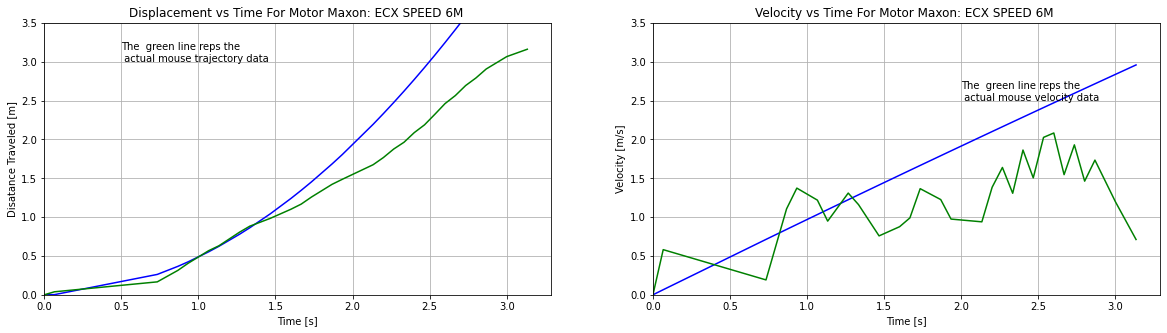

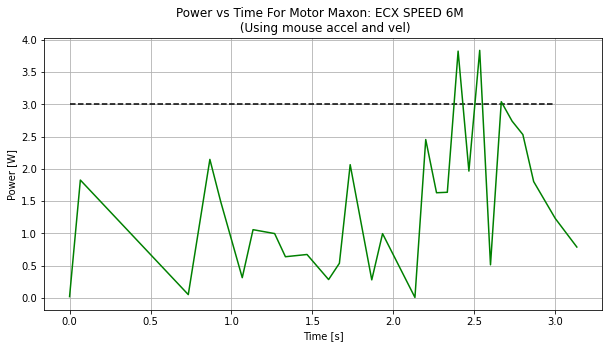

Average power (assuming my input power / torque is positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



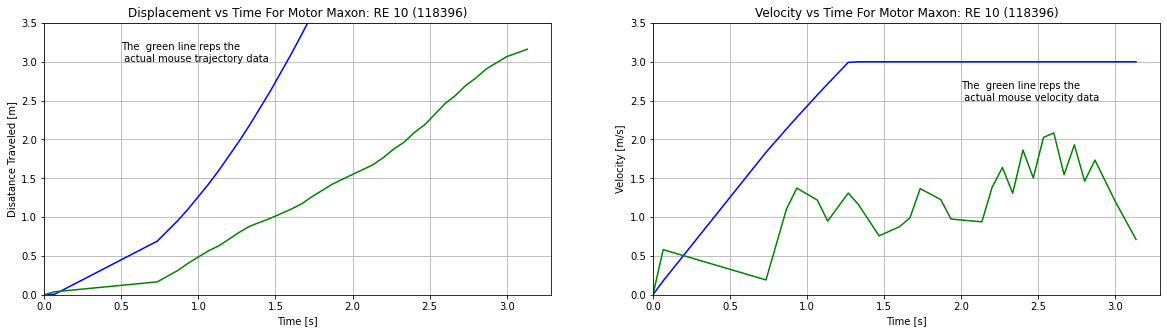

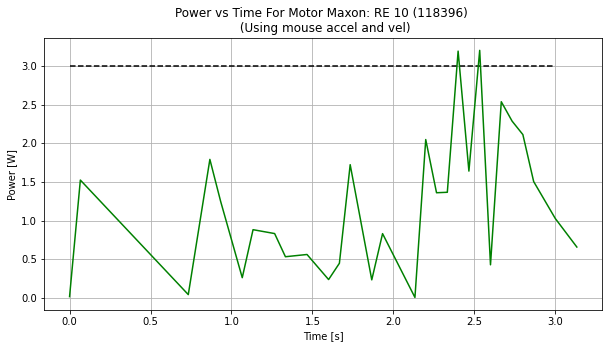

Average power (assuming my input power / torque is positive) is 1.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



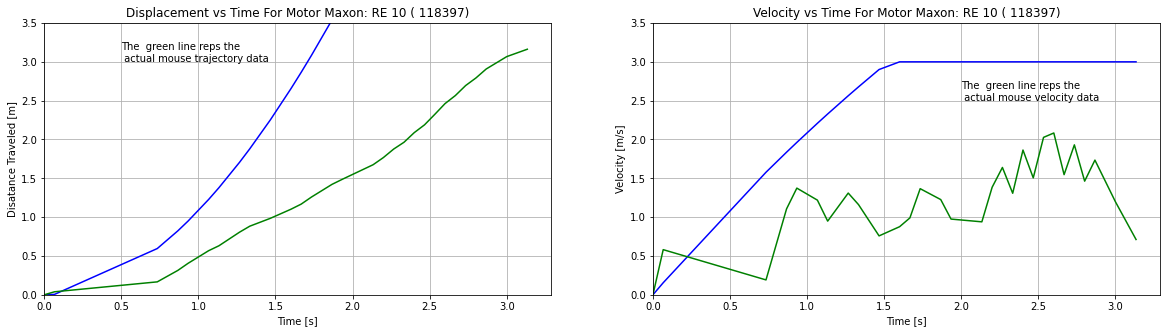

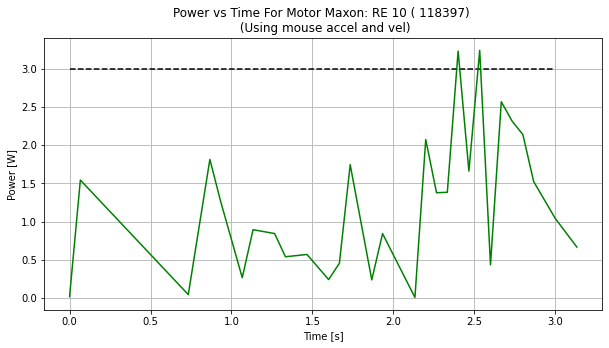

Average power (assuming my input power / torque is positive) is 1.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



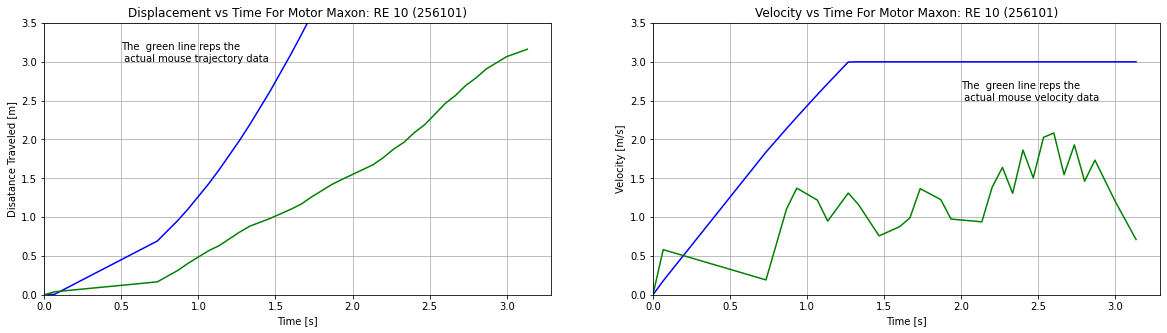

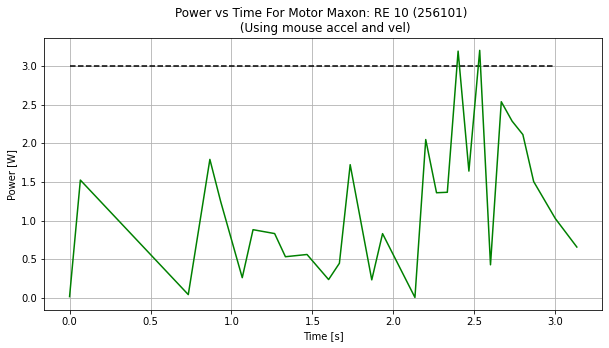

Average power (assuming my input power / torque is positive) is 1.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



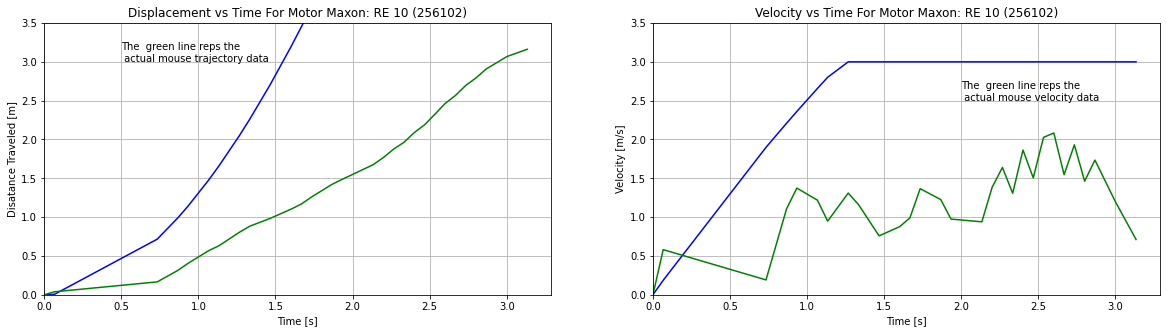

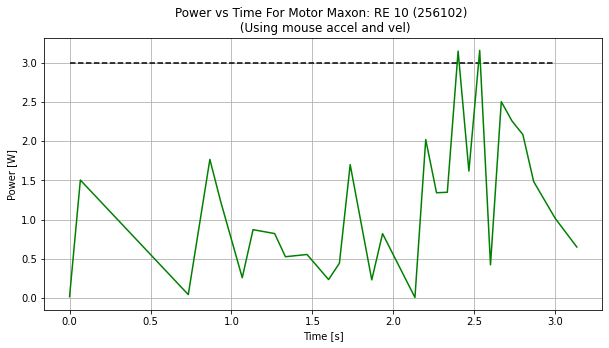

Average power (assuming my input power / torque is positive) is 1.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



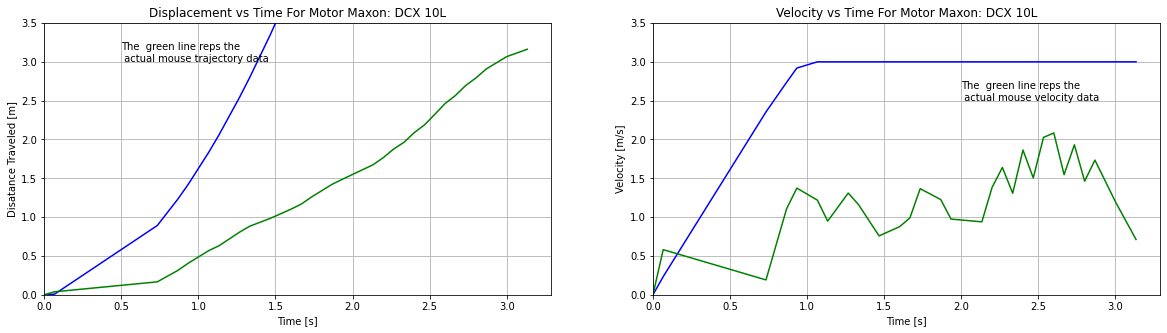

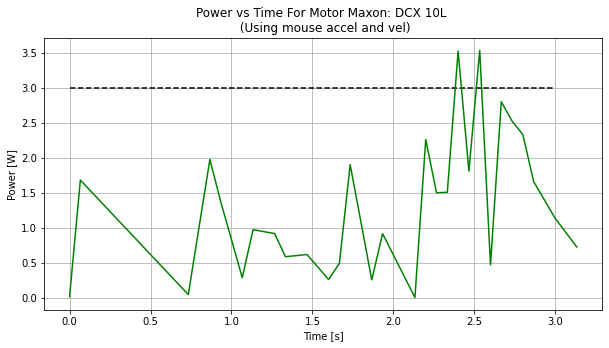

Average power (assuming my input power / torque is positive) is 1.3W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



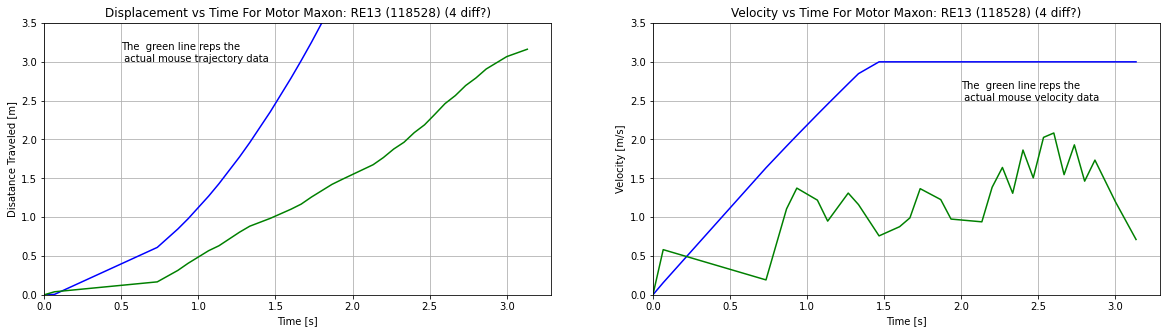

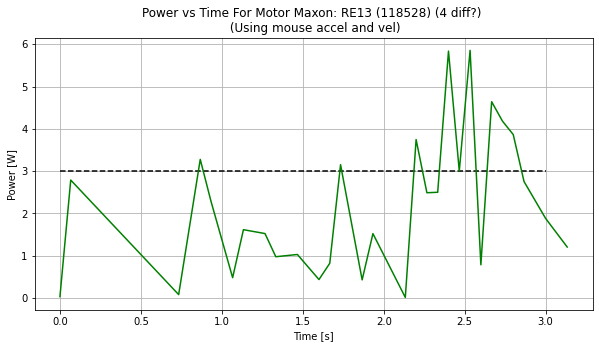

Average power (assuming my input power / torque is positive) is 2.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



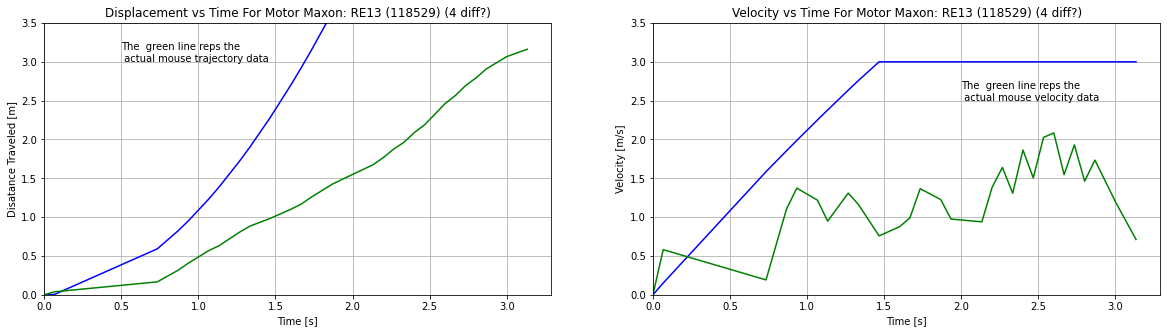

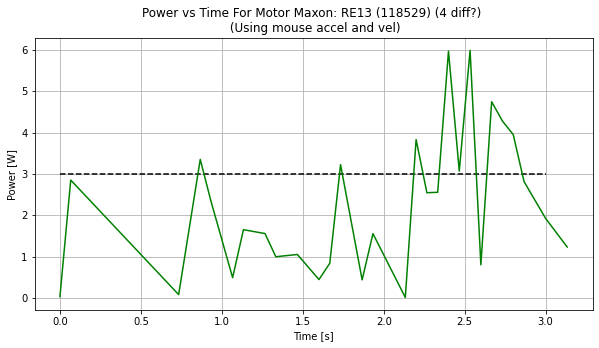

Average power (assuming my input power / torque is positive) is 2.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



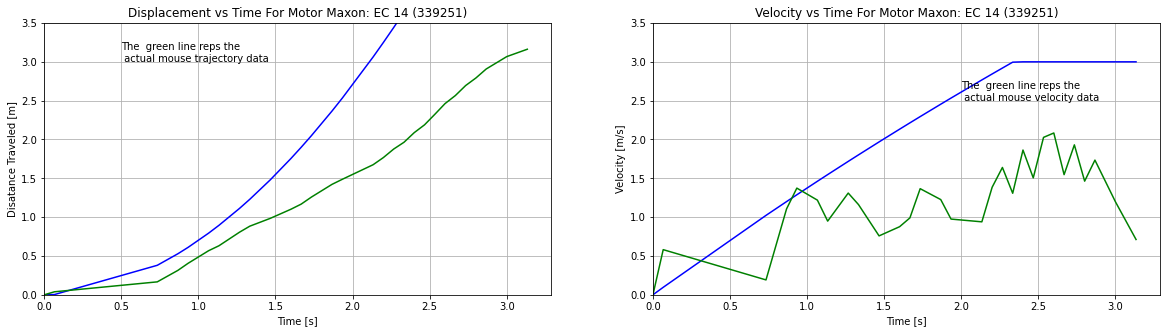

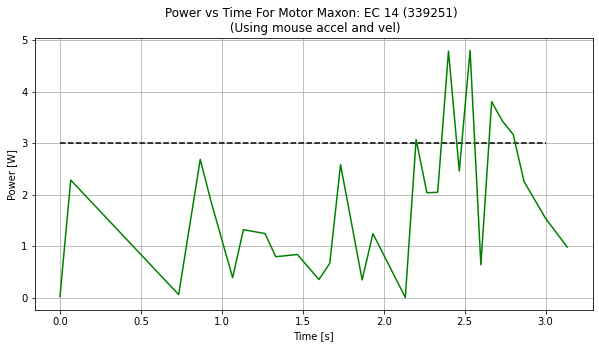

Average power (assuming my input power / torque is positive) is 1.8W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



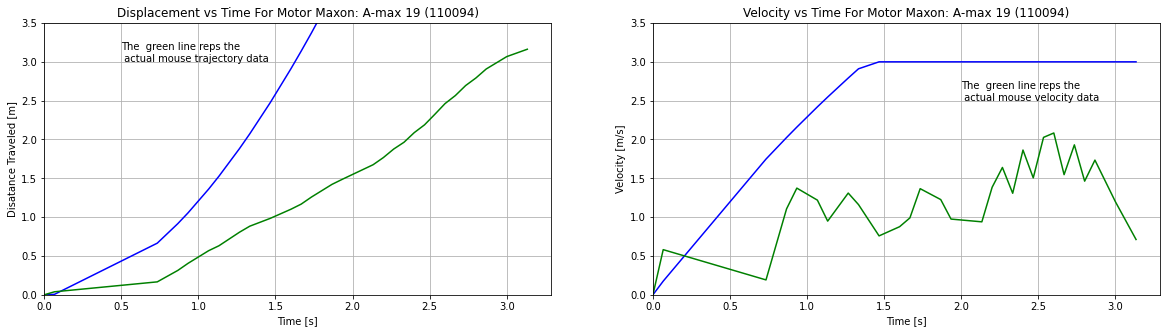

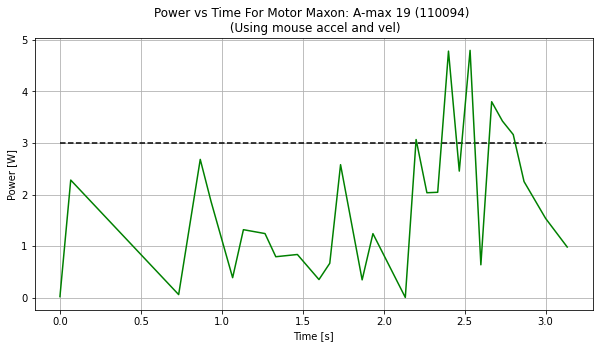

Average power (assuming my input power / torque is positive) is 1.8W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



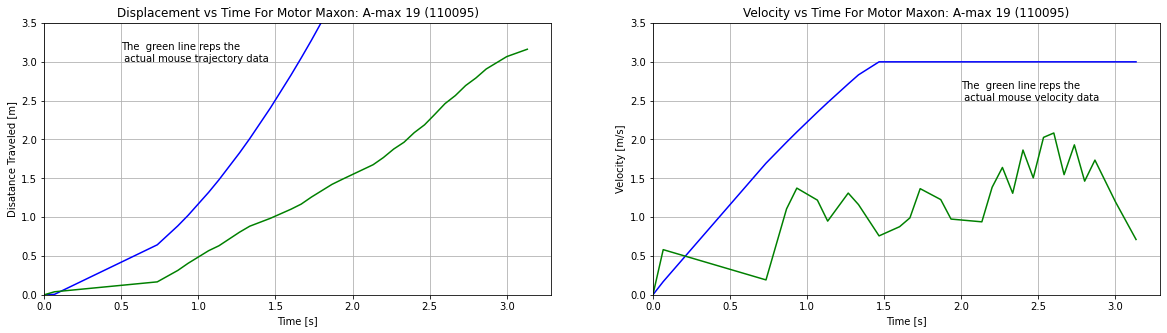

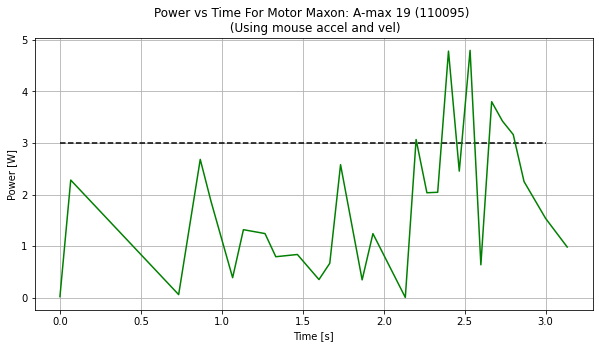

Average power (assuming my input power / torque is positive) is 1.8W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [8]:
                                    # Plot 1.5W Motors INDIVIDUALLY#

G1 = 1
print("THE BLACK DOTTED LINE REPRESENTS MAX POWER")
# These are approximate weights of some quick research I did into other parts we'll need
for i in range(len(all_motor_name_15W)): 
    disp_15W, vel_15W, power_15W, tor_15W, w_15W = get_motor_info(G1, i, time, all_motor_diam_15W, all_motor_kt_15W, all_single_motor_weight_15W, all_nominal_V_15W, all_motor_R_15W, all_motor_stall_t_15W, all_motor_no_load_RPM_15W, all_motor_eff_15W)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig, ax3  = plt.subplots(figsize=(10, 5))
    
############## Make the first graph a Dist vs Time graph for one tile (0.1m) ####################
    ax1.plot(time, disp_15W, '-b')
    ax1.plot(seconds, distance_meter, '-g')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Disatance Traveled [m]')
    ax1.grid(b=None, which='both', axis='both')
    ax1.text(0.5, 3, f"The  green line reps the \n actual mouse trajectory data")
    ax1.set_ylim(bottom= 0, top = 3.5)
    ax1.set_xlim(left= 0)
    ax1.set_title(f'Displacement vs Time For Motor {all_motor_name_15W[i]}')
    
############## Make the second graph a Vel vs Time graph ####################
    ax2.plot(time, vel_15W, '-b')
    ax2.plot(seconds, mouse_v2, "-g") # Plot the mouse data
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Velocity [m/s]')
    ax2.grid(b=None, which='both', axis='both')
    ax2.text(2.0, 2.5, f"The  green line reps the \n actual mouse velocity data")
    ax2.set_ylim(bottom= 0, top = 3.5)
    ax2.set_xlim(left= 0)
    ax2.set_title(f'Velocity vs Time For Motor {all_motor_name_15W[i]}')
    
############# Make the third graph a Power vs Time graph ####################
    ax3.plot(time, power_15W, '-g')
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Power [W]')
    ax3.hlines(motor_power_15W*2, 0, 3.0, color="black", linestyle="dashed")
    ax3.grid(b=None, which='both', axis='both')
    ax3.set_title(f'Power vs Time For Motor {all_motor_name_15W[i]} \n (Using mouse accel and vel)')
    
    plt.show()

    p_len15W = len(power_15W)
    p_sum15W = sum(power_15W)
    p_ave15W = p_sum15W / p_len15W
    
    print(f"Average power (assuming my input power / torque is positive) is {round(p_ave15W,1)}W")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

## 2W Motor Simulations

THE BLACK DOTTED LINE REPRESENTS MAX POWER


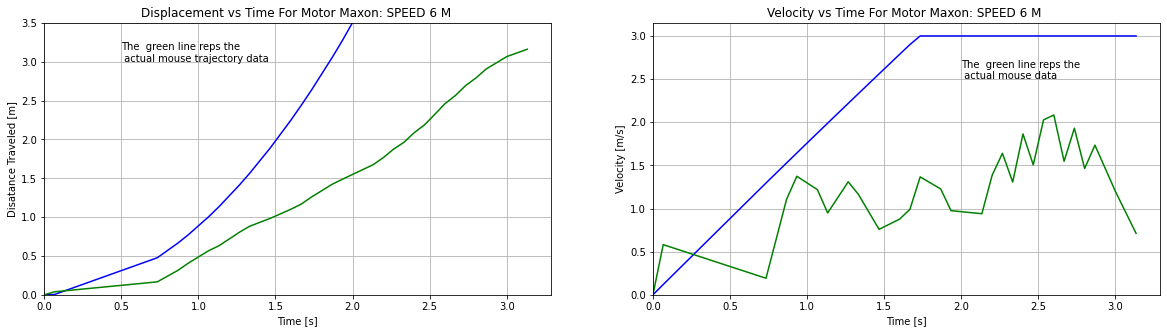

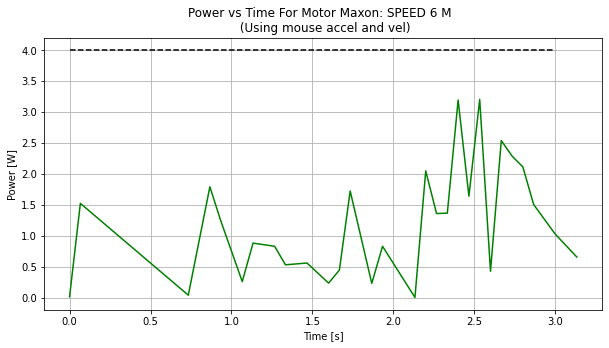

Average power (assuming input power / torque is always positive) is 1.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



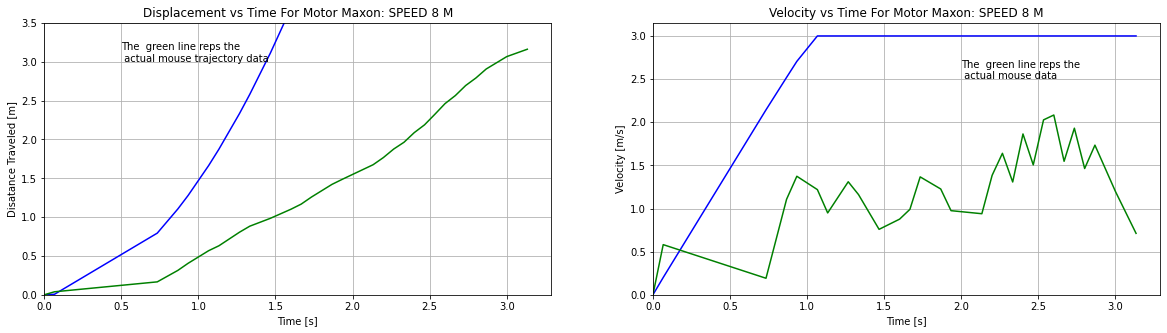

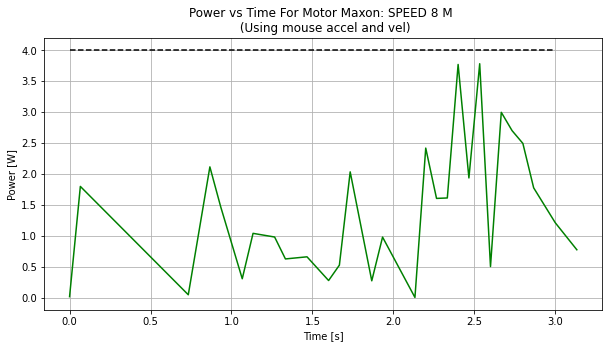

Average power (assuming input power / torque is always positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



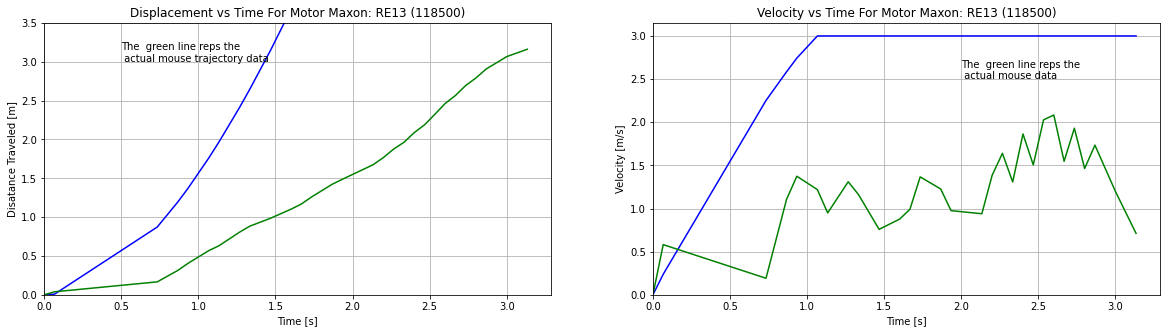

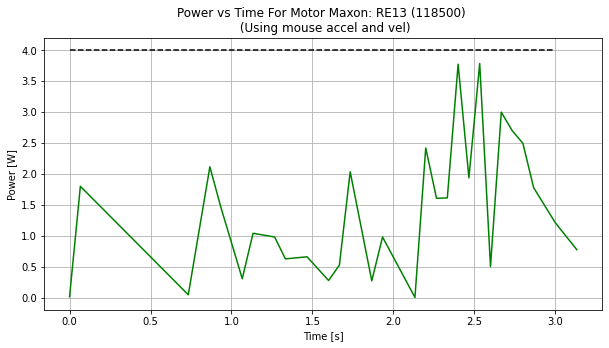

Average power (assuming input power / torque is always positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



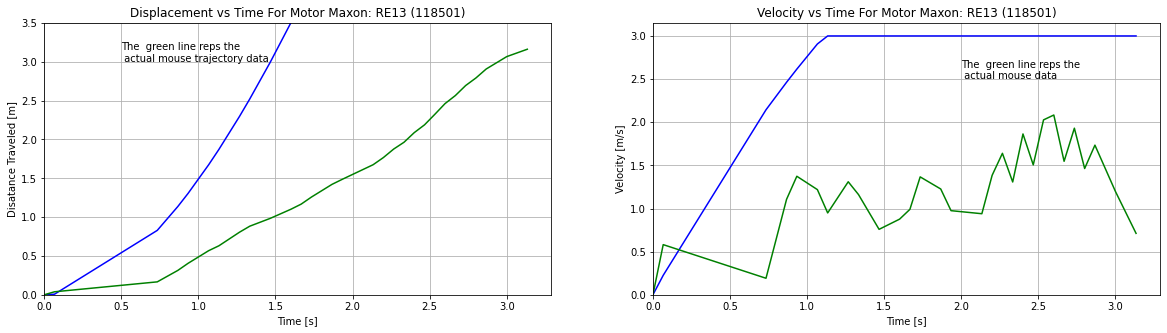

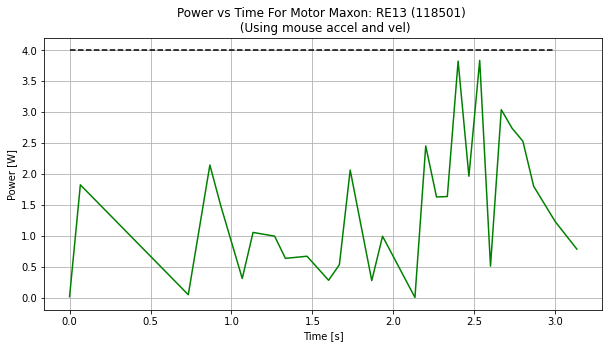

Average power (assuming input power / torque is always positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



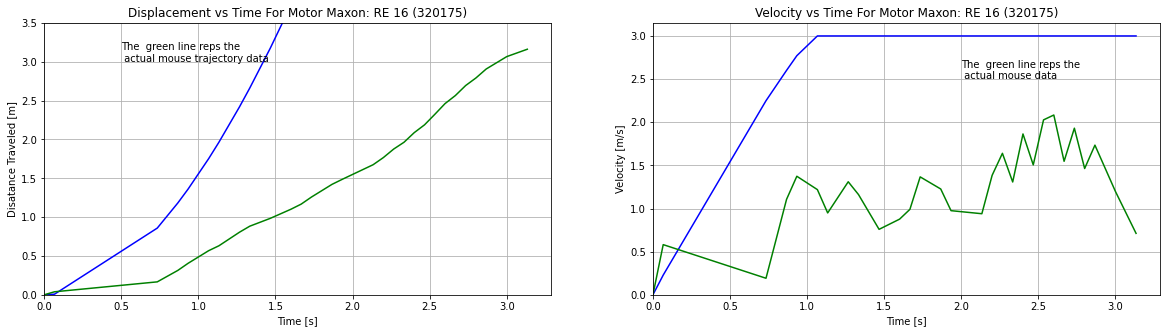

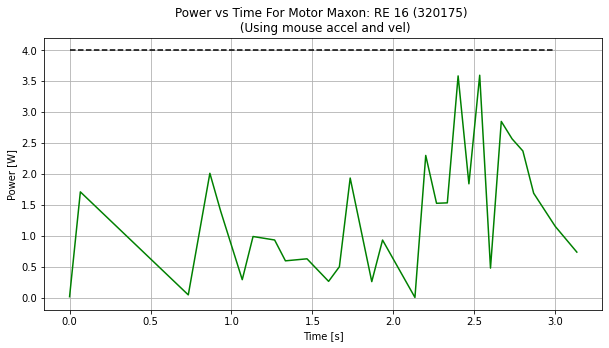

Average power (assuming input power / torque is always positive) is 1.3W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



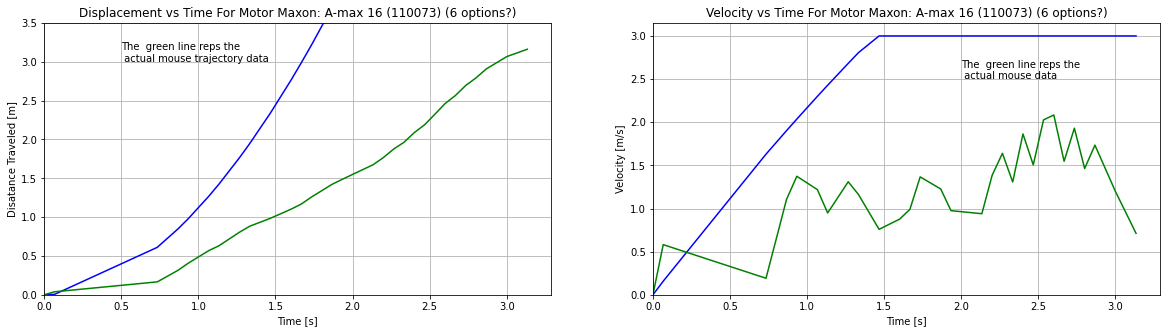

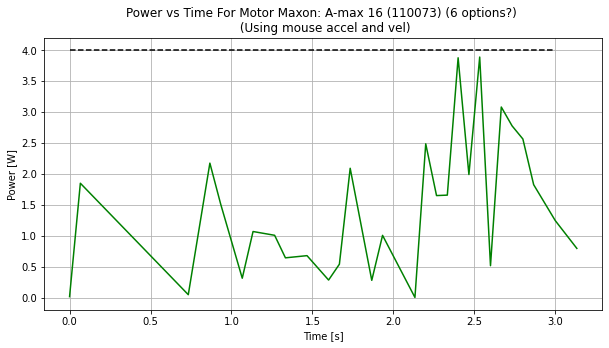

Average power (assuming input power / torque is always positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



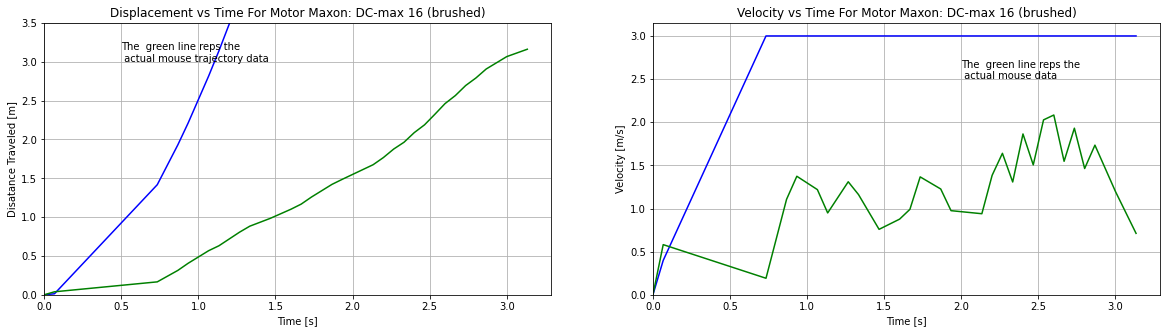

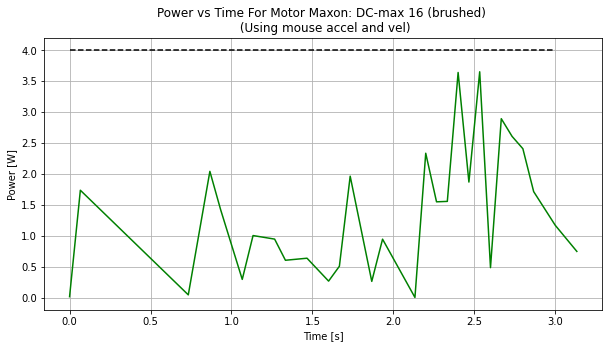

Average power (assuming input power / torque is always positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [9]:
                                        # Plot 2W Motors #  
print("THE BLACK DOTTED LINE REPRESENTS MAX POWER")

for i in range(len(all_motor_name_2W)): 
    disp_2W, vel_2W, power_2W, tor_2W, w_2W = get_motor_info(G1, i, time, all_motor_diam_2W, all_motor_kt_2W, all_single_motor_weight_2W, all_nominal_V_2W, all_motor_R_2W, all_motor_stall_t_2W, all_motor_no_load_RPM_2W, all_motor_eff_2W)
    
    fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(20, 5))
    fig, ax6  = plt.subplots(figsize=(10, 5))
    
############## Make the first graph a Dist vs Time graph ####################
    ax4.plot(seconds, disp_2W, '-b')
    ax4.plot(seconds,distance_meter, '-g')
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('Disatance Traveled [m]')
    ax4.grid(b=None, which='both', axis='both')
    ax4.text(0.5, 3, f"The  green line reps the \n actual mouse trajectory data")
    ax4.set_ylim(bottom= 0, top = 3.5)
    ax4.set_xlim(left= 0)
    ax4.set_title(f'Displacement vs Time For Motor {all_motor_name_2W[i]}')

############## Make the second graph a Vel vs Time graph ####################
    ax5.plot(seconds, vel_2W, '-b')
    ax5.plot(seconds, mouse_v2, "-g") # Plot the mouse data
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('Velocity [m/s]')
    ax5.text(2.0, 2.5, f"The  green line reps the \n actual mouse data")
    ax5.grid(b=None, which='both', axis='both')
    ax5.set_ylim(bottom= 0)
    ax5.set_xlim(left= 0)
    ax5.set_title(f'Velocity vs Time For Motor {all_motor_name_2W[i]}')
    
############# Make the third graph a Power vs Time graph ####################
    ax6.plot(time, power_2W, '-g')
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Power [W]')
    ax6.hlines(motor_power_2W*2, 0, 3.0, color="black", linestyle="dashed")
    ax6.grid(b=None, which='both', axis='both')
    ax6.set_title(f'Power vs Time For Motor {all_motor_name_2W[i]} \n (Using mouse accel and vel)')
    
    plt.show()
    
    p_len2W = len(power_2W)
    p_sum2W = sum(power_2W)
    p_ave2W = p_sum2W / p_len2W
    
    print(f"Average power (assuming input power / torque is always positive) is {round(p_ave2W, 1)}W")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

## 2.5W Motor Simulations

THE BLACK DOTTED LINE REPRESENTS MAX POWER


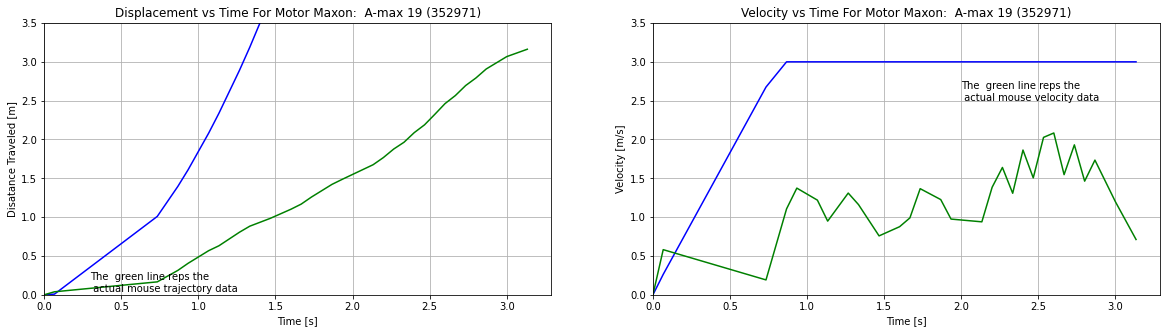

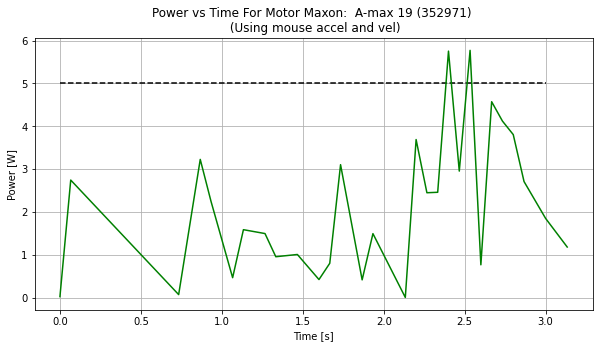

Average power (assuming input power / torque is positive) is 2.1W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



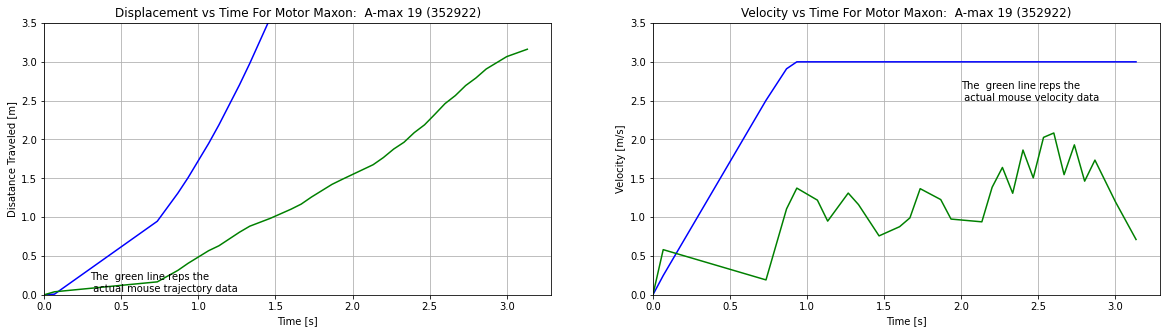

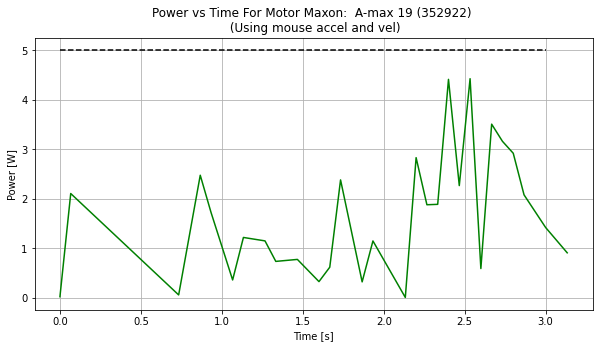

Average power (assuming input power / torque is positive) is 1.6W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



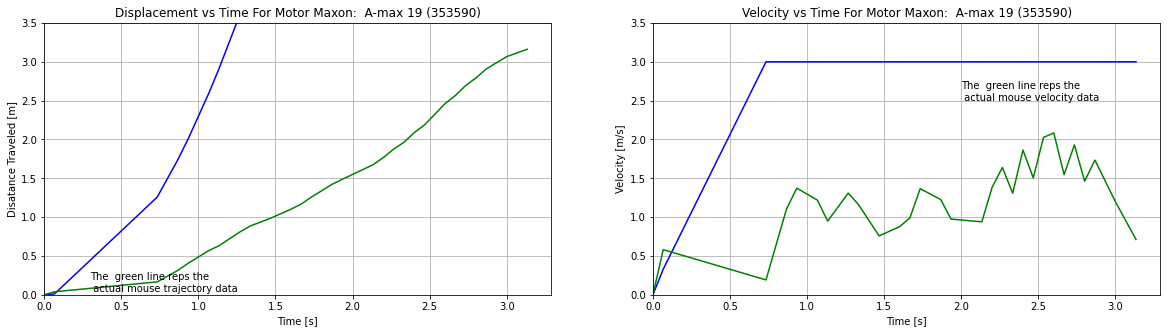

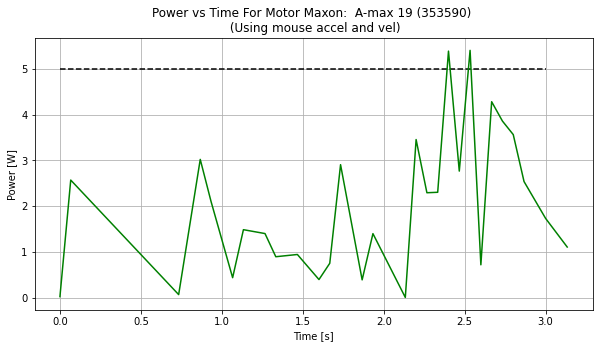

Average power (assuming input power / torque is positive) is 2.0W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



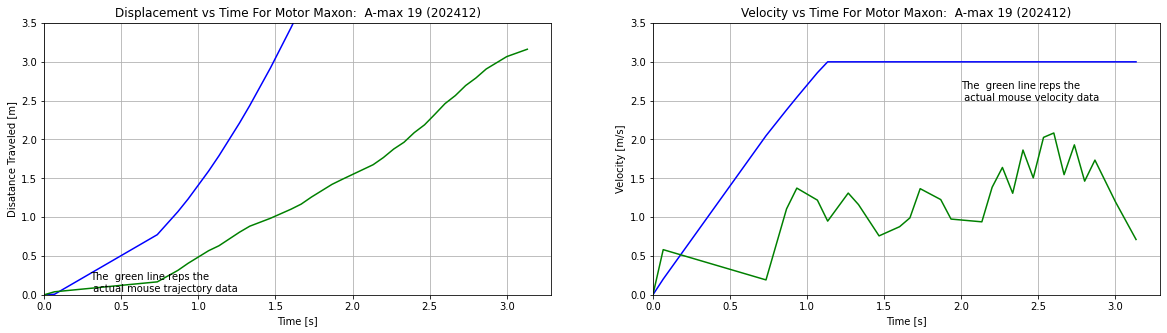

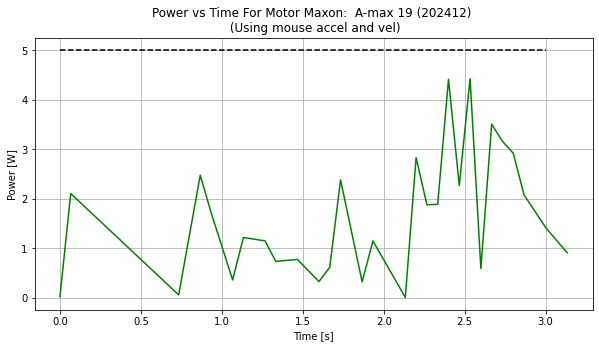

Average power (assuming input power / torque is positive) is 1.6W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



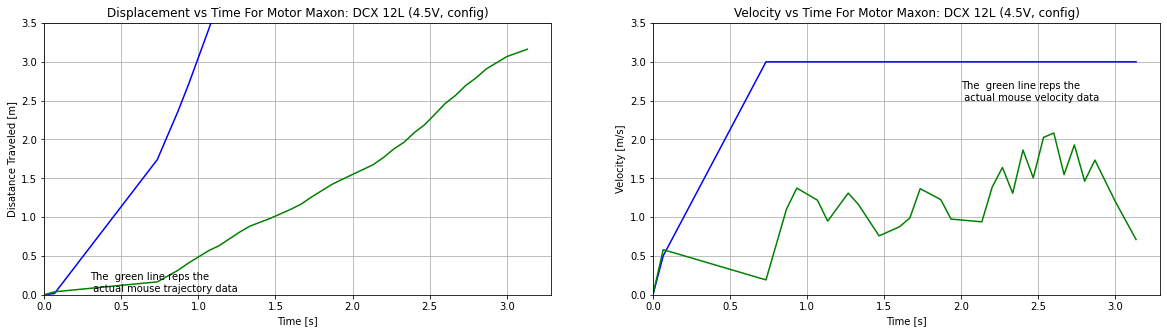

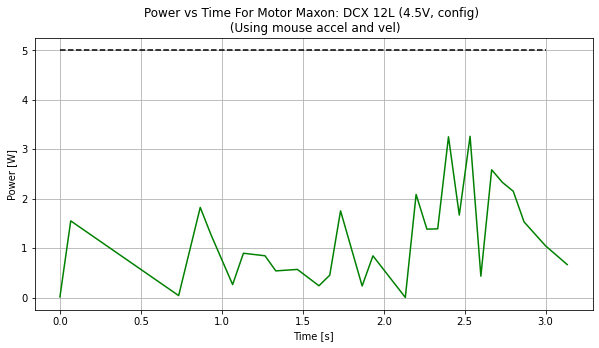

Average power (assuming input power / torque is positive) is 1.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



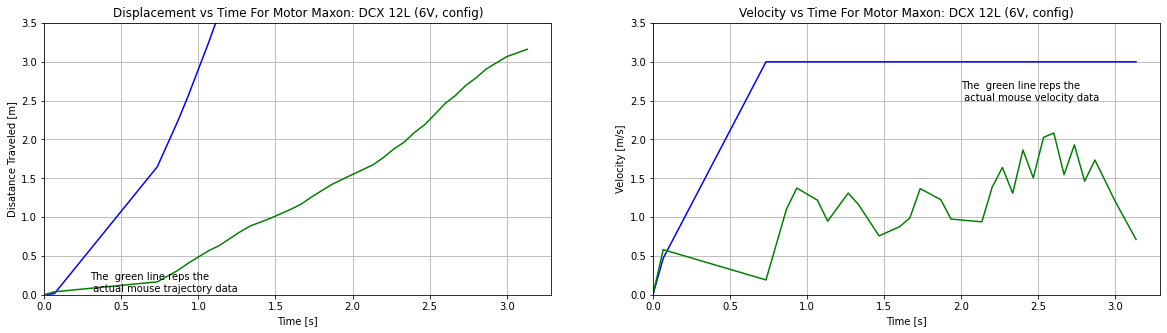

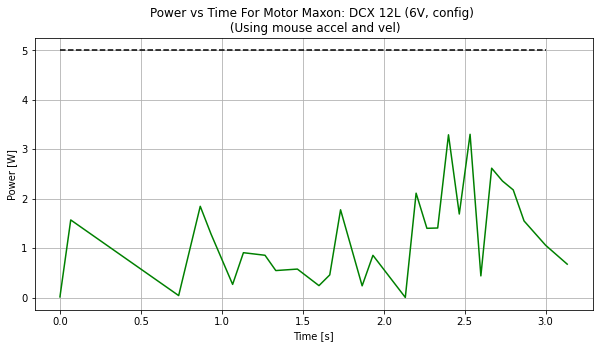

Average power (assuming input power / torque is positive) is 1.2W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



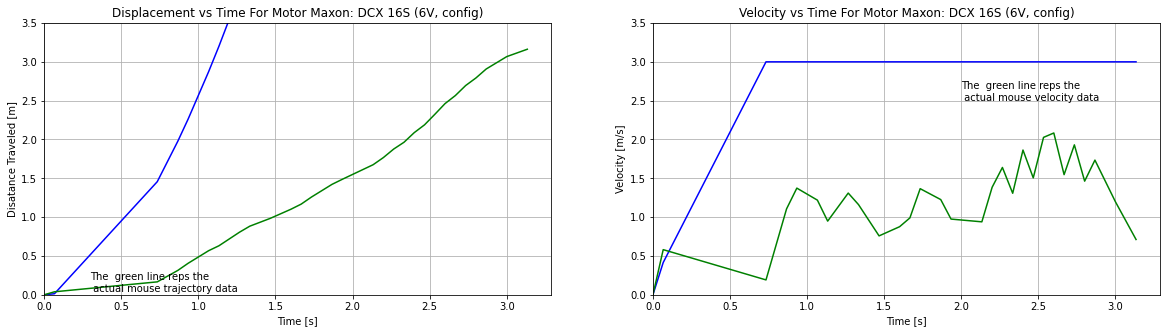

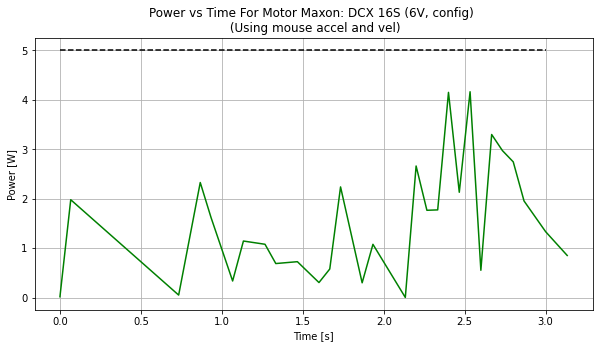

Average power (assuming input power / torque is positive) is 1.5W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



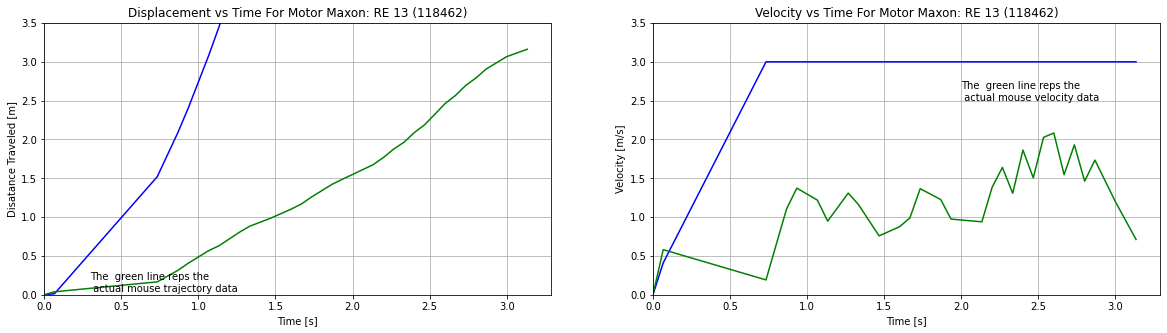

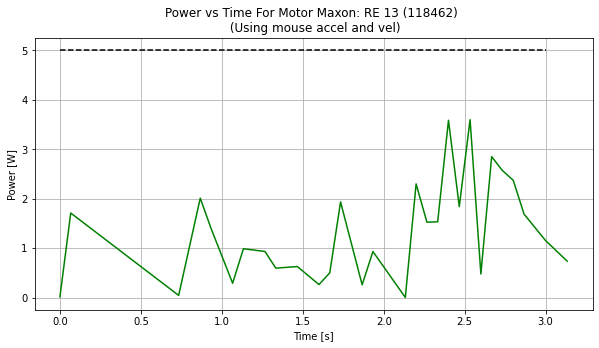

Average power (assuming input power / torque is positive) is 1.3W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



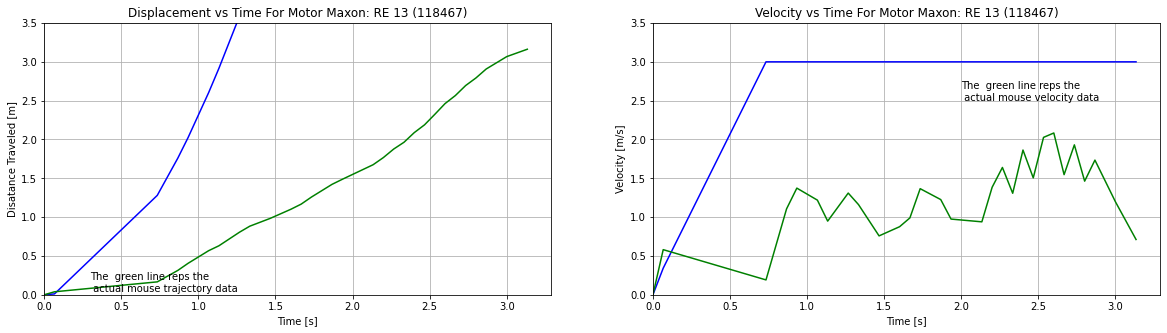

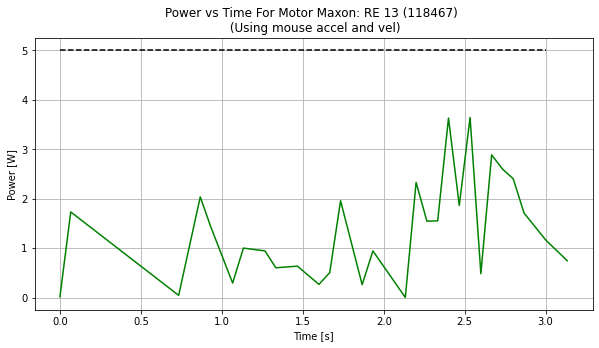

Average power (assuming input power / torque is positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



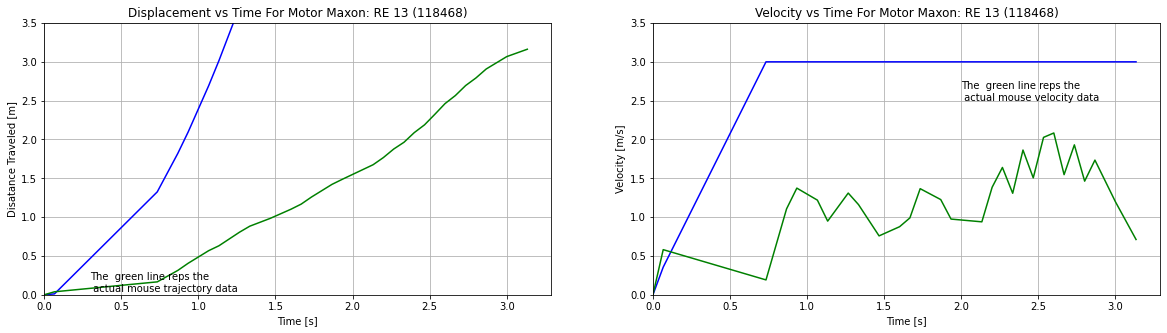

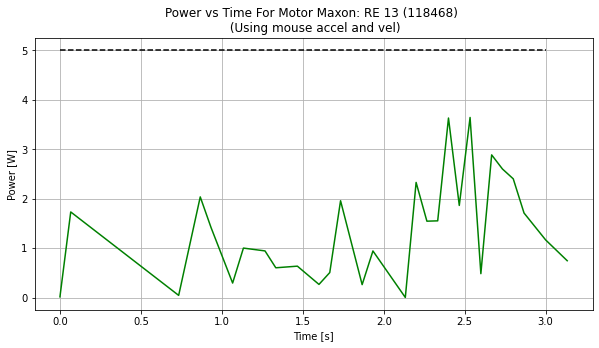

Average power (assuming input power / torque is positive) is 1.4W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [10]:
                                            # Plot 2.5W Motors #
print("THE BLACK DOTTED LINE REPRESENTS MAX POWER")
for i in range(len(all_motor_name_25W)): 
    disp_25W, vel_25W, power_25W, tor_25W, w_25W = get_motor_info(G1, i, time, all_motor_diam_25W, all_motor_kt_25W, all_single_motor_weight_25W, all_nominal_V_25W, all_motor_R_25W, all_motor_stall_t_25W, all_motor_no_load_RPM_25W, all_motor_eff_25W)
    
    fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(20, 5))
    fig, ax9  = plt.subplots(figsize=(10, 5))
    
############## Make the first graph a Dist vs Time graph ####################
    ax7.plot(time, disp_25W, '-b')
    ax7.plot(seconds,distance_meter, '-g')
    ax7.set_xlabel('Time [s]')
    ax7.set_ylabel('Disatance Traveled [m]')
    ax7.grid(b=None, which='both', axis='both')
    ax7.text(0.3, 0.04, "The  green line reps the \n actual mouse trajectory data")
    ax7.set_ylim(bottom= 0, top = 3.5)
    ax7.set_xlim(left= 0)
    ax7.set_title(f'Displacement vs Time For Motor {all_motor_name_25W[i]}')

############## Make the second graph a Vel vs Time graph ####################
    ax8.plot(time, vel_25W, '-b')
    ax8.plot(seconds, mouse_v2, "-g") # Plot the mouse data
    ax8.set_xlabel('Time [s]')
    ax8.set_ylabel('Velocity [m/s]')
    ax8.grid(b=None, which='both', axis='both')
    ax8.text(2.0, 2.5, f"The  green line reps the \n actual mouse velocity data")
    ax8.set_ylim(bottom= 0, top = 3.5)
    ax8.set_xlim(left= 0)
    ax8.set_title(f'Velocity vs Time For Motor {all_motor_name_25W[i]}')
    
############# Make the third graph a Power vs Time graph ####################
    ax9.plot(time, power_25W, '-g')
    ax9.set_xlabel('Time [s]')
    ax9.set_ylabel('Power [W]')
    ax9.hlines(motor_power_25W*2, 0, 3.0, color="black", linestyle="dashed")
    ax9.grid(b=None, which='both', axis='both')
    ax9.set_title(f'Power vs Time For Motor {all_motor_name_25W[i]} \n (Using mouse accel and vel)')
    
    plt.show()
    
    p_len25W = len(power_25W)
    p_sum25W = sum(power_25W)
    p_ave25W = p_sum25W / p_len25W
    
    print(f"Average power (assuming input power / torque is positive) is {round(p_ave25W, 1)}W")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

## Of the 2.5W motors, looks like one of the A-maxes wont fit the power bill (A-max 19 (353590))

# 3W SIMULATIONS

THE BLACK DOTTED LINE REPRESENTS MAX POWER


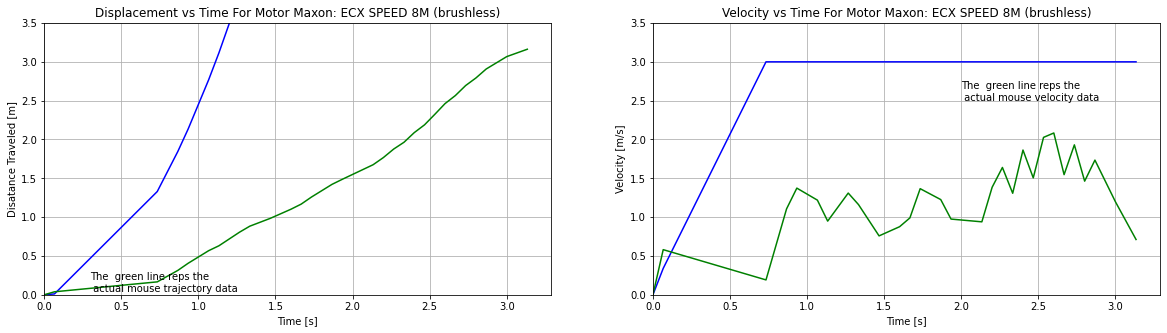

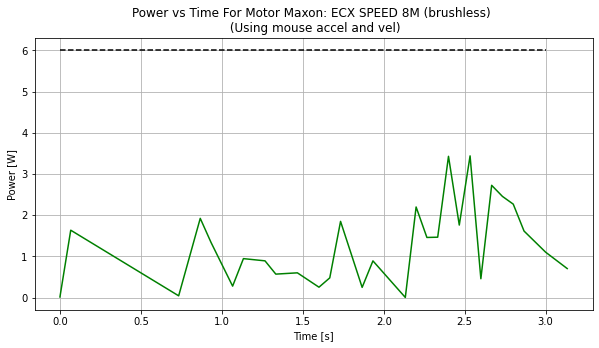

Average power (assuming input power / torque is positive) is 1.3W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



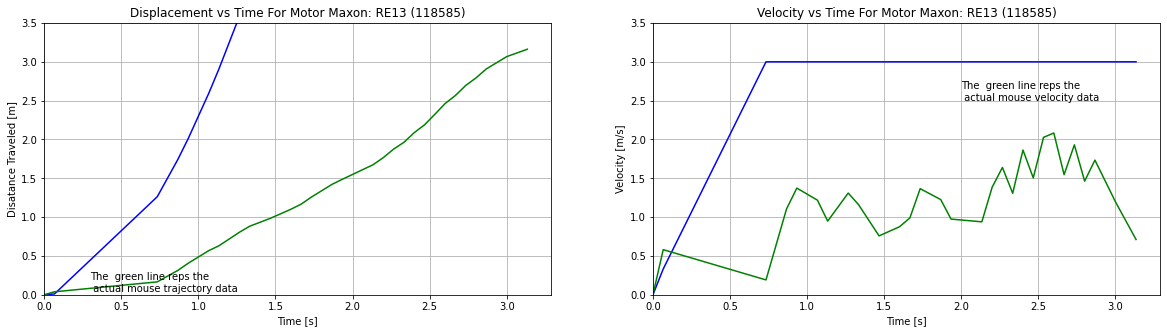

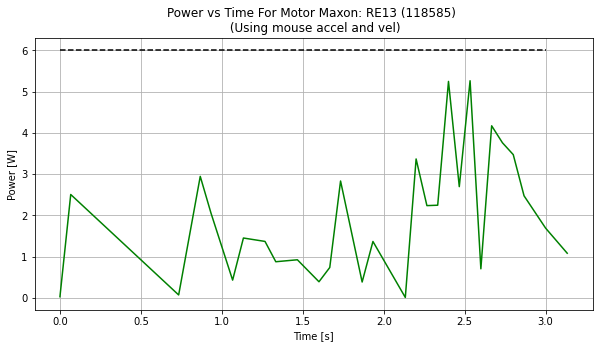

Average power (assuming input power / torque is positive) is 2.0W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



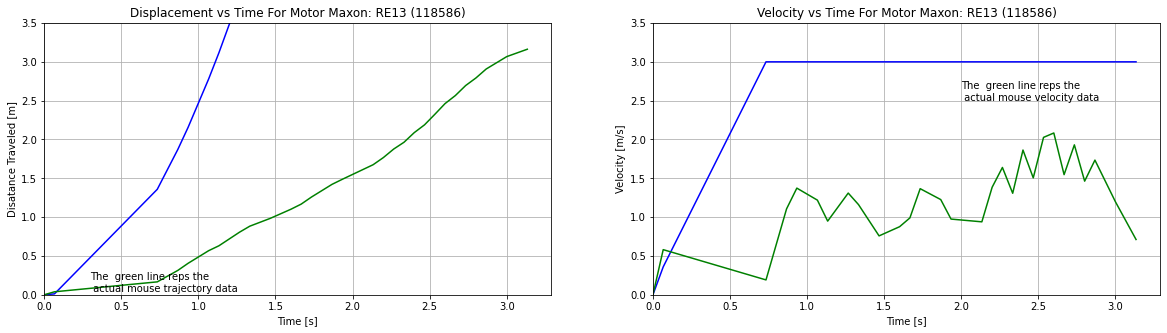

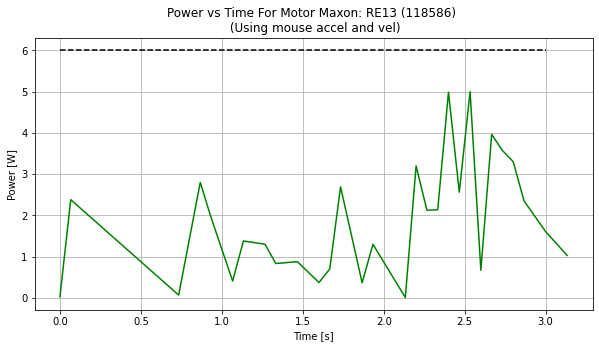

Average power (assuming input power / torque is positive) is 1.9W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



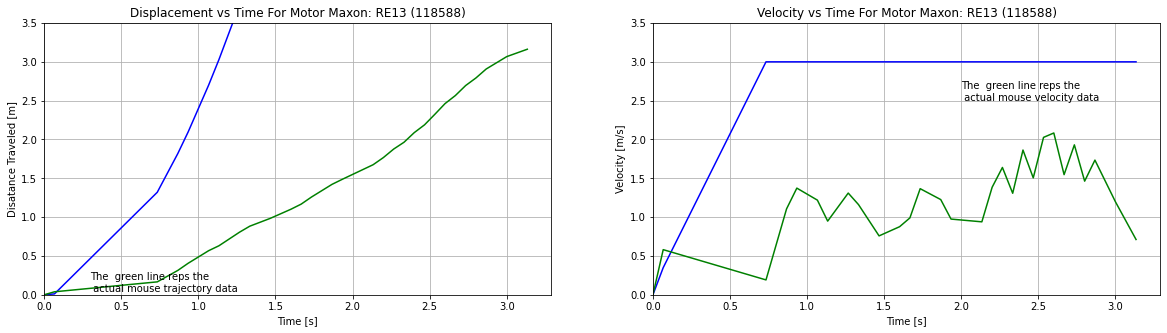

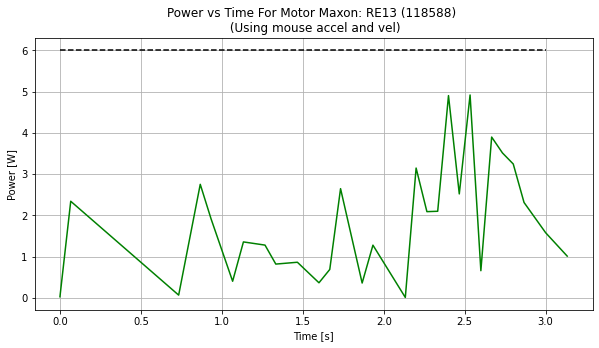

Average power (assuming input power / torque is positive) is 1.8W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



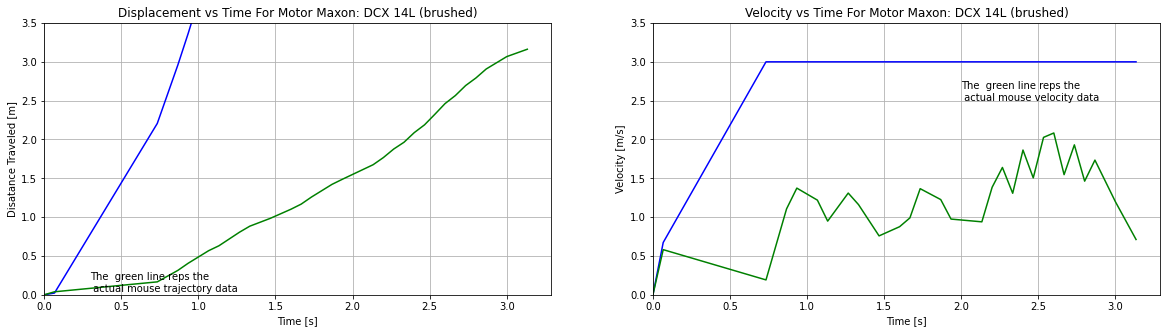

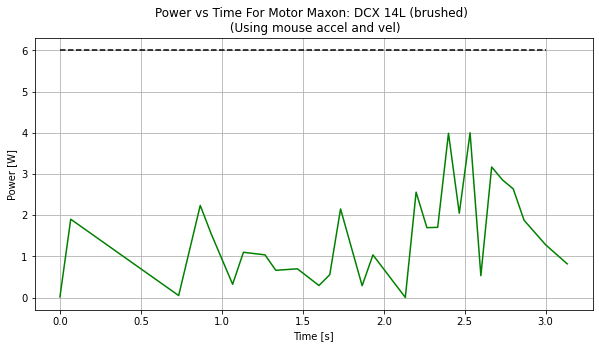

Average power (assuming input power / torque is positive) is 1.5W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



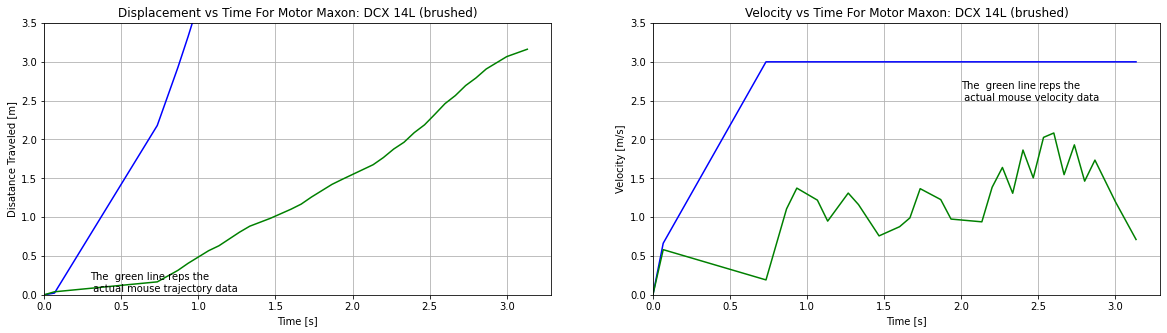

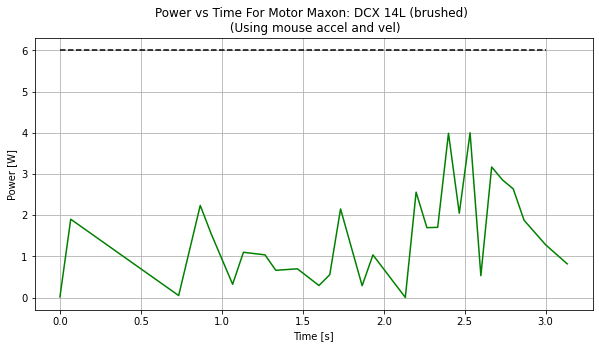

Average power (assuming input power / torque is positive) is 1.5W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



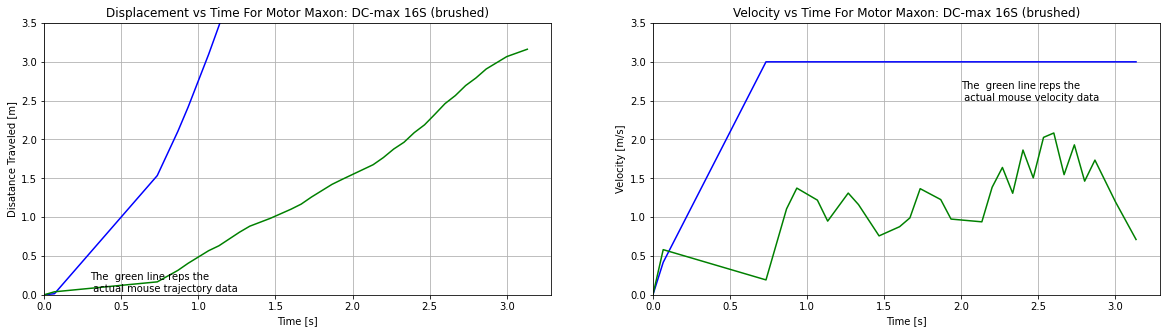

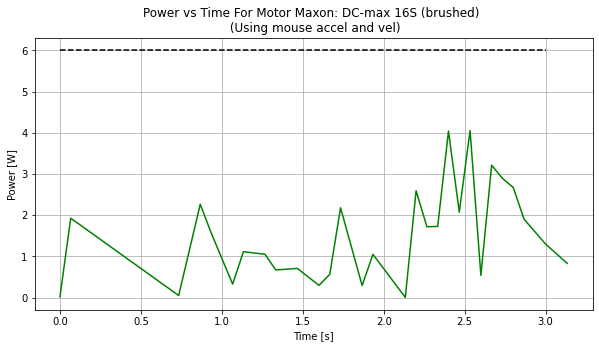

Average power (assuming input power / torque is positive) is 1.5W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



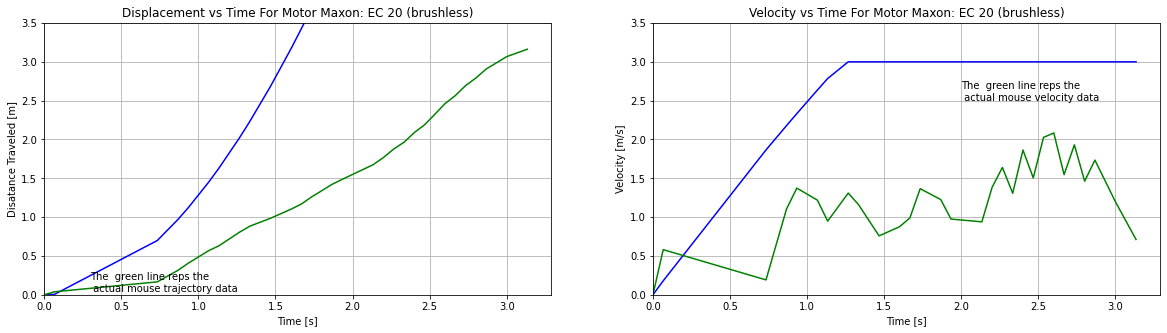

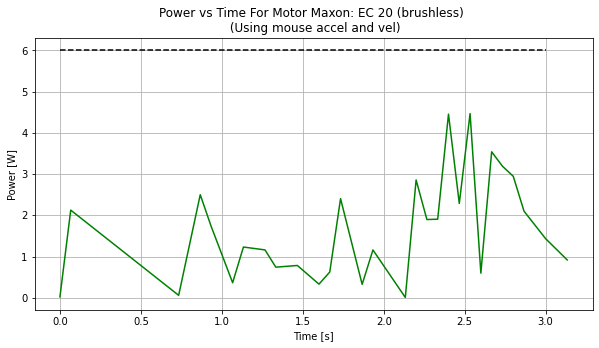

Average power (assuming input power / torque is positive) is 1.7W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



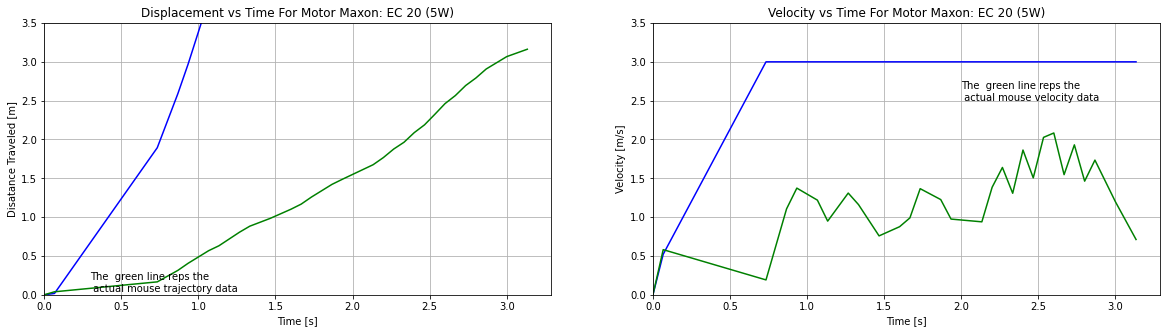

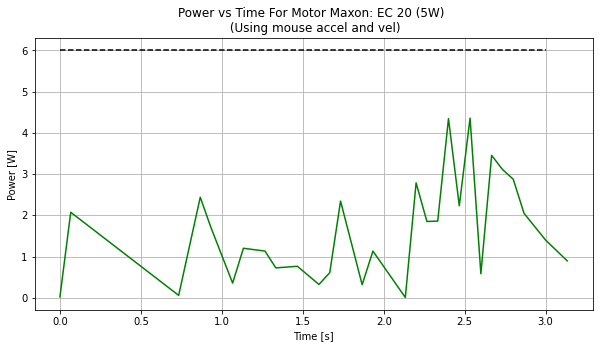

Average power (assuming input power / torque is positive) is 1.6W
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [11]:
                                            # Plot 3W Motors #
print("THE BLACK DOTTED LINE REPRESENTS MAX POWER")
for i in range(len(all_motor_name_3W)): 
    disp_3W, vel_3W, power_3W, tor_3W, w_3W = get_motor_info(G1, i, time, all_motor_diam_3W, all_motor_kt_3W, all_single_motor_weight_3W, all_nominal_V_3W, all_motor_R_3W, all_motor_stall_t_3W, all_motor_no_load_RPM_3W, all_motor_eff_3W)
    
    fig, (ax10, ax11) = plt.subplots(1, 2, figsize=(20, 5))
    fig, ax12  = plt.subplots(figsize=(10, 5))
    
############## Make the first graph a Dist vs Time graph ####################
    ax10.plot(time, disp_3W, '-b')
    ax10.plot(seconds,distance_meter, '-g')
    ax10.set_xlabel('Time [s]')
    ax10.set_ylabel('Disatance Traveled [m]')
    ax10.grid(b=None, which='both', axis='both')
    ax10.text(0.3, 0.04, "The  green line reps the \n actual mouse trajectory data")
    ax10.set_ylim(bottom= 0, top = 3.5)
    ax10.set_xlim(left= 0)
    ax10.set_title(f'Displacement vs Time For Motor {all_motor_name_3W[i]}')

############## Make the second graph a Vel vs Time graph ####################
    ax11.plot(time, vel_3W, '-b')
    ax11.plot(seconds,mouse_v2, "-g") # Plot the mouse data
    ax11.set_xlabel('Time [s]')
    ax11.set_ylabel('Velocity [m/s]')
    ax11.grid(b=None, which='both', axis='both')
    ax11.text(2.0, 2.5, f"The  green line reps the \n actual mouse velocity data")
    ax11.set_ylim(bottom= 0, top = 3.5)
    ax11.set_xlim(left= 0)
    ax11.set_title(f'Velocity vs Time For Motor {all_motor_name_3W[i]}')
    
############# Make the third graph a Power vs Time graph ####################
    ax12.plot(time, power_3W, '-g')
    ax12.set_xlabel('Time [s]')
    ax12.set_ylabel('Power [W]')
    ax12.hlines(motor_power_3W*2, 0, 3.0, color="black", linestyle="dashed")
    ax12.grid(b=None, which='both', axis='both')
    ax12.set_title(f'Power vs Time For Motor {all_motor_name_3W[i]} \n (Using mouse accel and vel)')
    
    plt.show()
    
    p_len3W = len(power_3W)
    p_sum3W = sum(power_3W)
    p_ave3W = p_sum3W / p_len3W

    print(f"Average power (assuming input power / torque is positive) is {round(p_ave3W, 1)}W")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

<!-- ## I know we dont have a constant acceleration, but lets express the relationship between acceleration and torque


Given the formulas...

$F = ma$

$\tau = Fr$

We can say that...

$\tau = mar$

We can graph the simple relationship between torque and  acceleration.  -->

<!-- ## Battery Calculations 

The battery I've been modeling with is rated at a capactiy of 950mAh, V = 7.4 and C = 25 constant, 50 burst. 

https://hobbyking.com/en_us/turnigy-nano-tech-950mah-2s-25-50c-lipo-pack.html?queryID=1eaac594597e79e054b2ad91f52d2667&objectID=47397&indexName=hbk_live_magento_en_us_products

At shortest time and maximum current draw:

$60min / 25C = 2.4 min$

$I = 0.95(25) = 23.75 A$

From our previous discussions, we said that given a 45min - 1hour experiment, we can predict that a battery should last on average at least 15 minutes. So for 15 minutes...

$60min / 15min = 4C$

For 4C, I can draw up to... 

$I = .95(4) = 3.8A$ -->

## Eliminate the motors above that do not maintain continous or peak power requirements

This eliminates almsot all the 1.5W motors. There might be an arguement for the RE 10 and DCX 10L Motors, but considering how much better the 2W and 2.5W motors hold up, I'll continue just evaluaitng those. **UNLESS I SHOULD EVALUATE THE RE13 AND DCX 10L MOTORS SINCE THEYRE ONLY 10G EACH?!

Now its time to test different gear ratios and simulate different intervals to compare motors even further. 

Essentially we are looking to see if we apply max voltage to the motors, do o I meet or exceed the desired velocity at the end of the interval?

**SHOULDNT I BE USING TORQUE SOMEWHERE TO NARROW DOWN MOTORS?**

## EXAMINE DIFFERENT TRAJECTORIES AND GEAR RATIOS

 Eliminate motors that dont meet the power reqs
 **THIS MEANS WE ELIMINATE ALL THE 1.5W MOTORS**

 2W Motors: All pass
 
 2.5W motors: All but the last two pass (index 4-5 dont pass)
 
 3W Motors: All pass
 
 Lets play with gear ratios and these motors. See what the trajectories look like across 1 tile, across 5 tiles, 
 10 tiles, and then the whole arena

THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2

THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA

No load RPM 62700.0 and omega=6565.928646002667


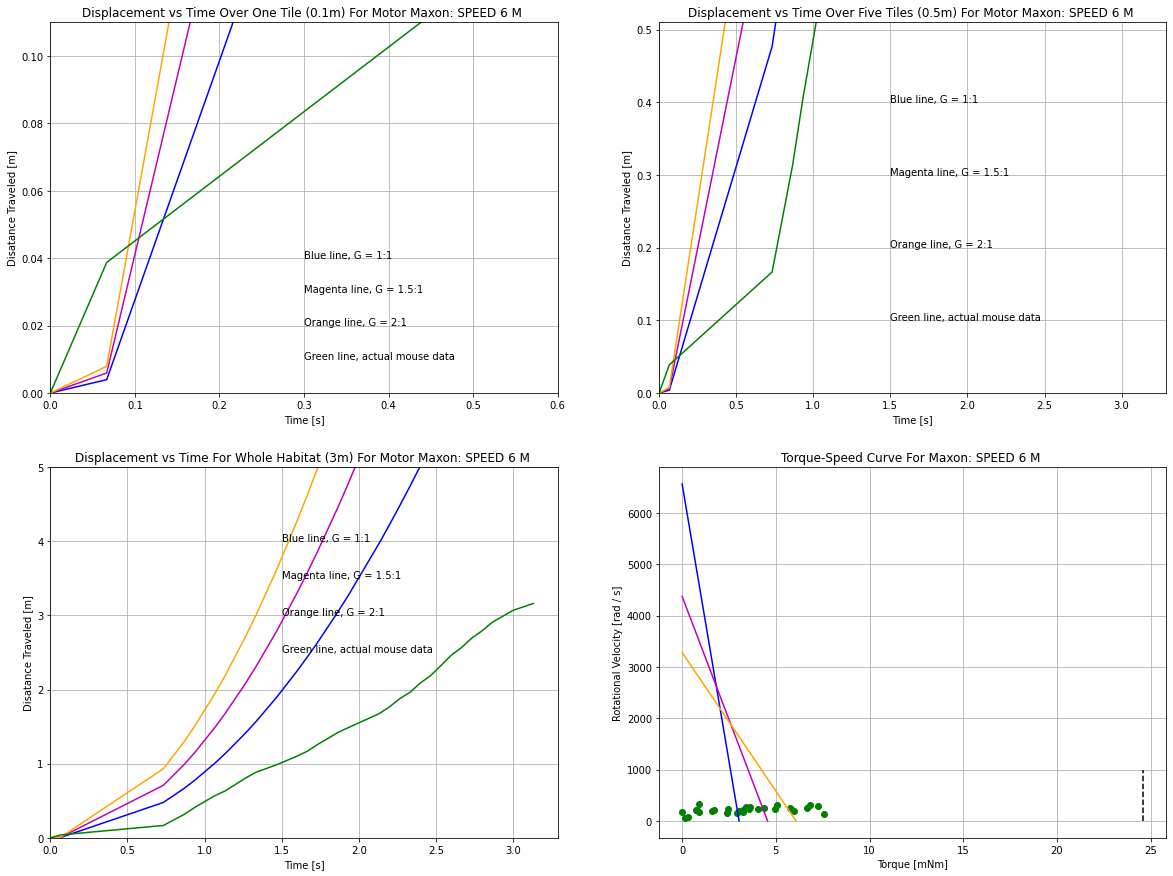

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 35400.0 and omega=3707.0793312359556


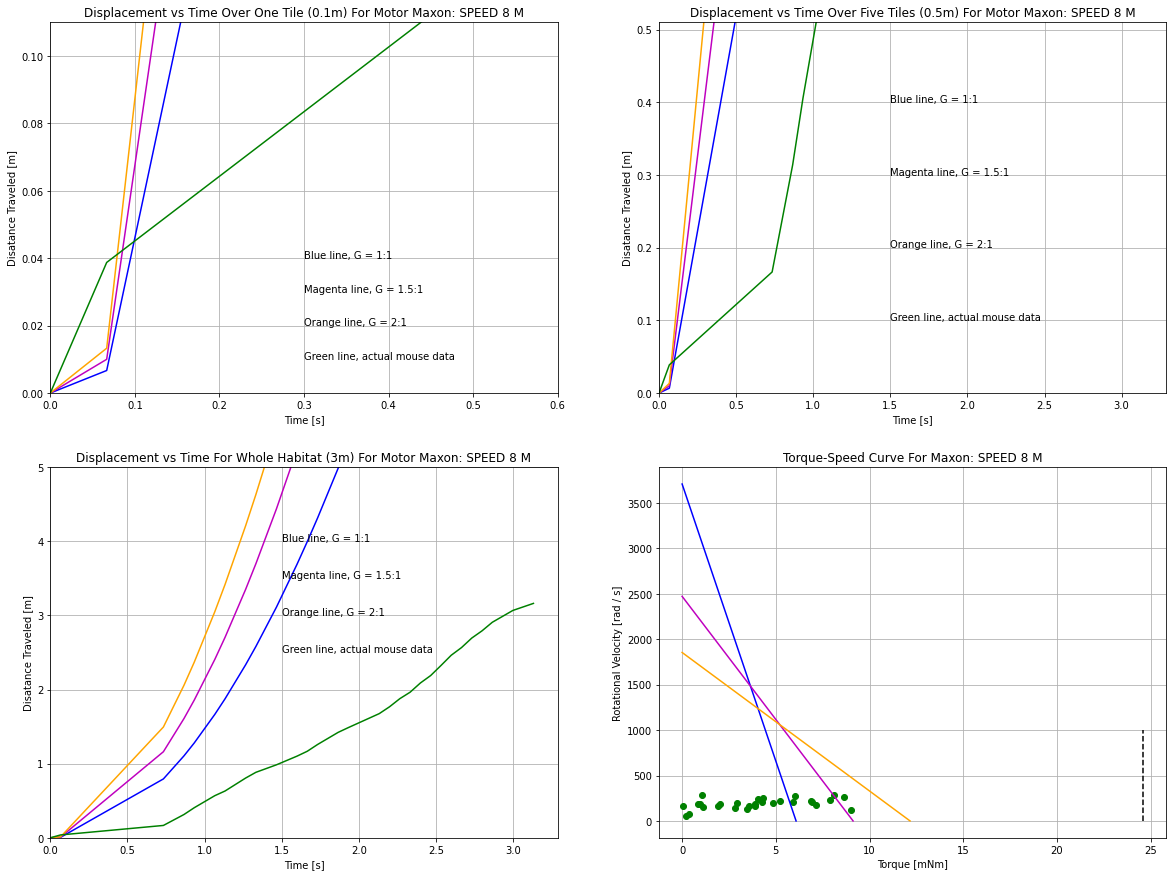

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 6810.0 and omega=713.1415323648831


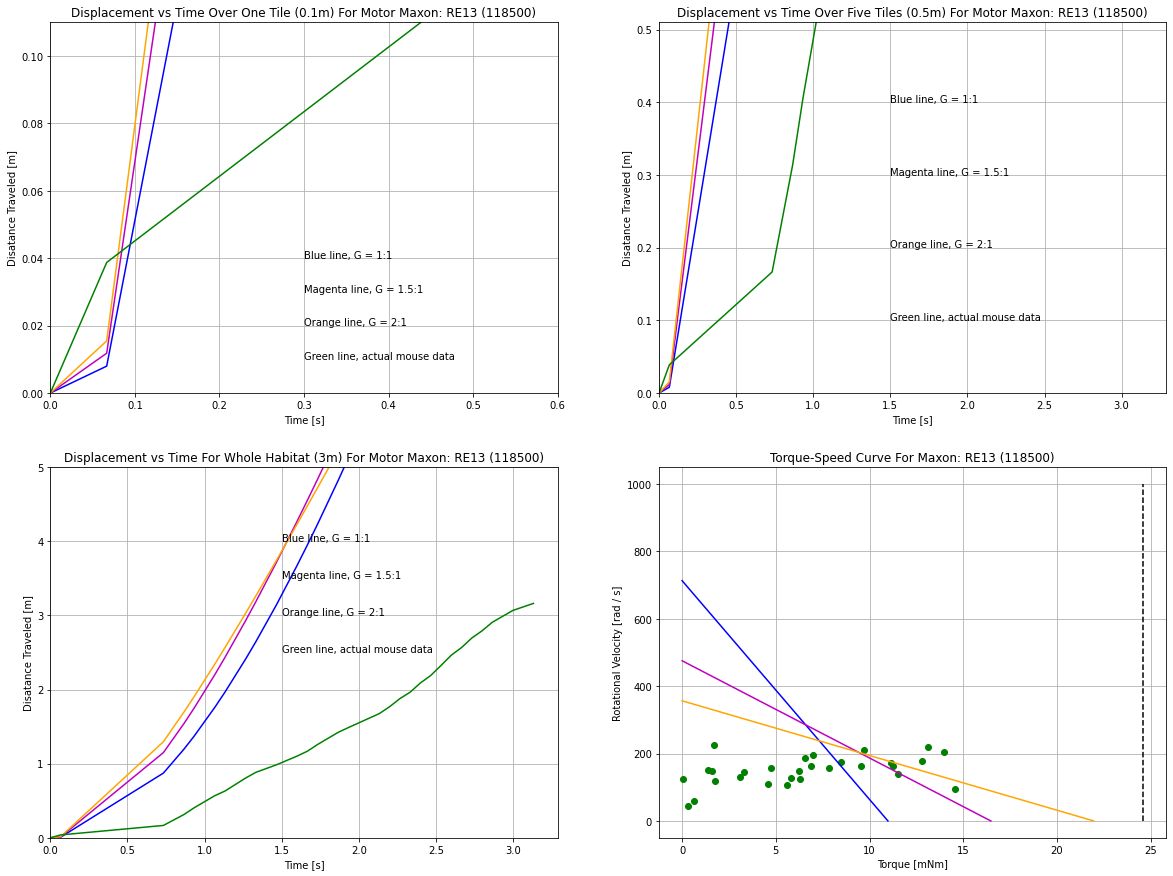

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 6590.0 and omega=690.1031862385578


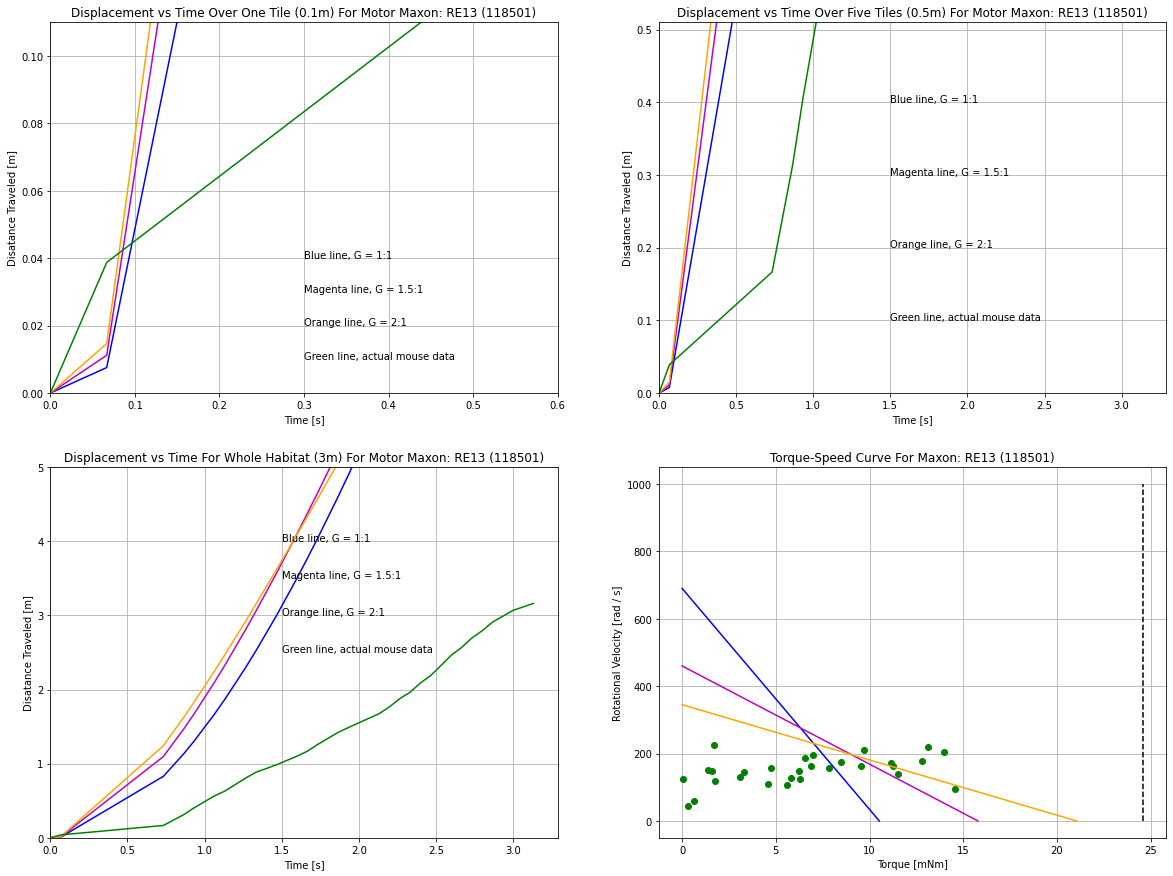

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 7960.0 and omega=833.5692507524917


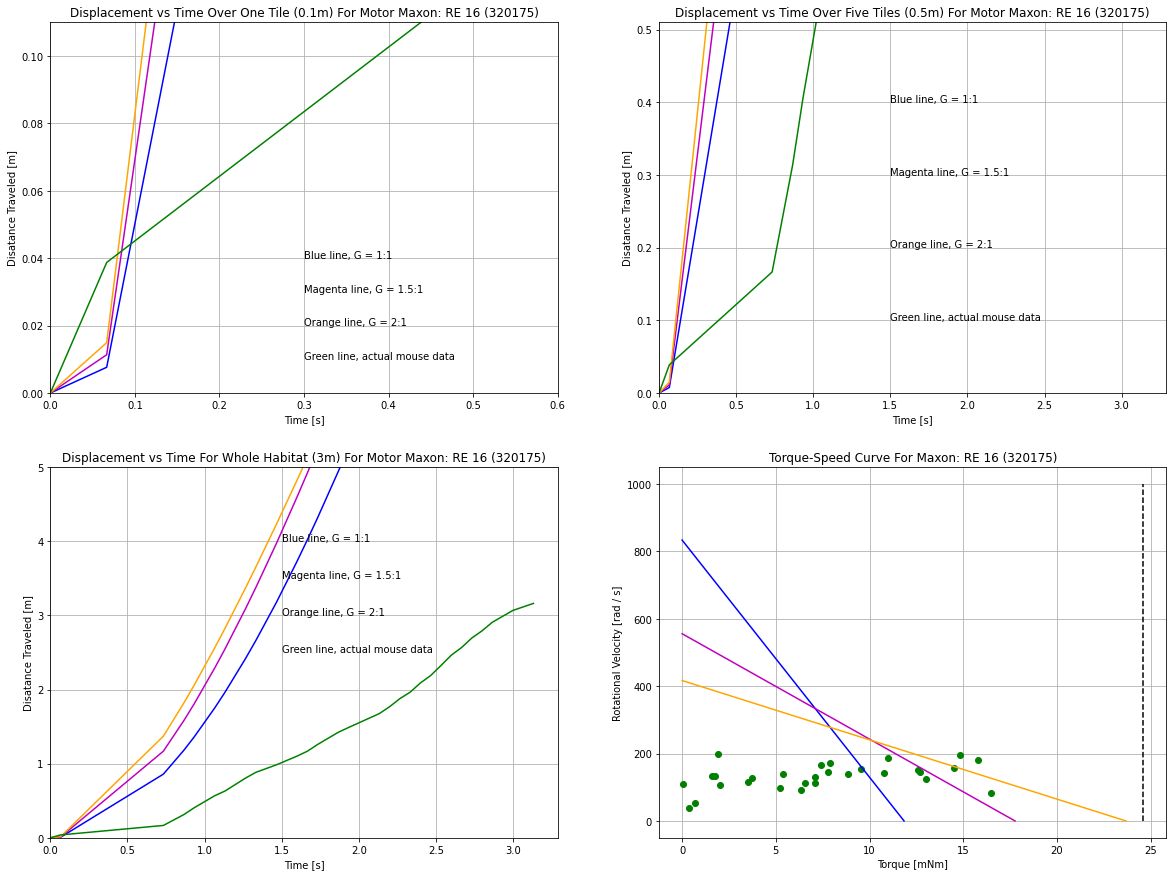

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 9360.0 and omega=980.1769079200154


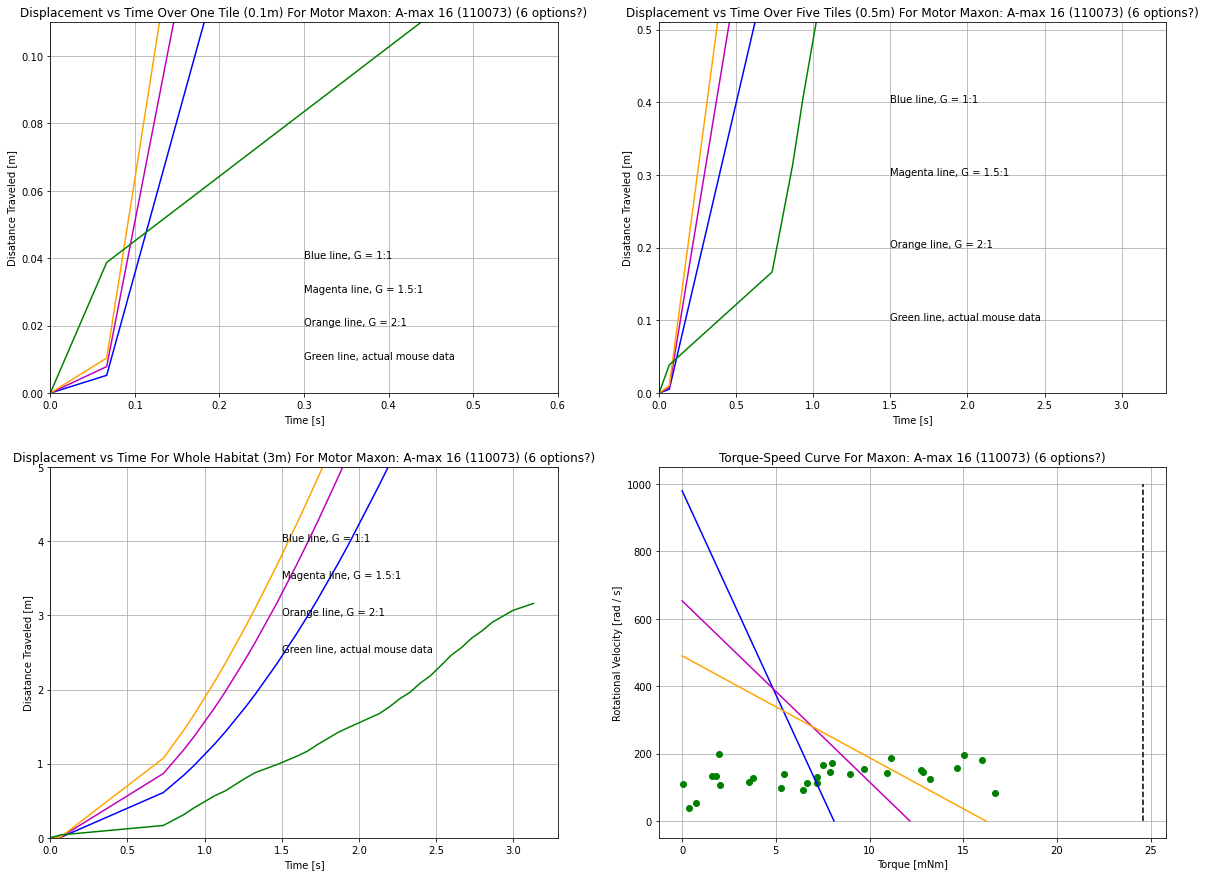

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 7890.0 and omega=826.2388678941155


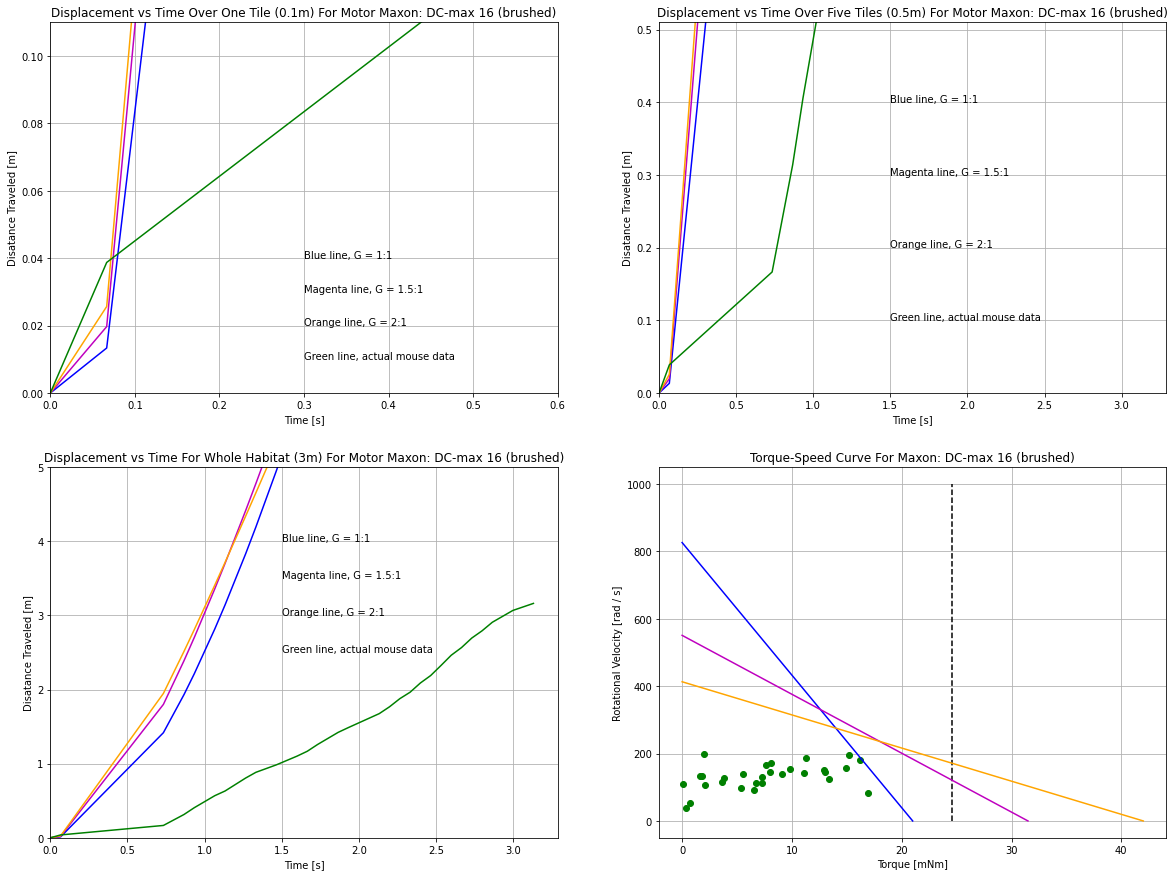

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [12]:
                                                # Plot 2W Motors #
print("THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2\n")
print("THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA\n")
G2 = 1
G3 = 1.5
G4 = 2

a_max = 8.2
v_max = 3
m_max = 0.2
r_max = 0.015
tau_max = m_max * a_max * r_max * 1000
    
for i in range(len(all_motor_name_2W)): 
    disp_2W_g1, vel_2W_g1, power_2W_g1, tor_2W_g1, w_2W_g1 = get_motor_info(G1, i, time, all_motor_diam_2W, all_motor_kt_2W, all_single_motor_weight_2W, all_nominal_V_2W, all_motor_R_2W, all_motor_stall_t_2W, all_motor_no_load_RPM_2W, all_motor_eff_2W)
    disp_2W_g2, vel_2W_g2, power_2W_g2, tor_2W_g2, w_2W_g2 = get_motor_info(G2, i, time, all_motor_diam_2W, all_motor_kt_2W, all_single_motor_weight_2W, all_nominal_V_2W, all_motor_R_2W, all_motor_stall_t_2W, all_motor_no_load_RPM_2W, all_motor_eff_2W)
    disp_2W_g3, vel_2W_g3, power_2W_g3, tor_2W_g3, w_2W_g3 = get_motor_info(G3, i, time, all_motor_diam_2W, all_motor_kt_2W, all_single_motor_weight_2W, all_nominal_V_2W, all_motor_R_2W, all_motor_stall_t_2W, all_motor_no_load_RPM_2W, all_motor_eff_2W)
    disp_2W_g4, vel_2W_g4, power_2W_g4, tor_2W_g4, w_2W_g4 = get_motor_info(G4, i, time, all_motor_diam_2W, all_motor_kt_2W, all_single_motor_weight_2W, all_nominal_V_2W, all_motor_R_2W, all_motor_stall_t_2W, all_motor_no_load_RPM_2W, all_motor_eff_2W)
    
    motor_stall_t_2W = all_motor_stall_t_2W[i] * 2 # Multiply by 2 since we have 2 motors
    motor_no_load_RPM_2W = all_motor_no_load_RPM_2W[i]
    no_load_w_2W = (2*math.pi*motor_no_load_RPM_2W) / 60
    
    print(f"No load RPM {motor_no_load_RPM_2W} and omega={no_load_w_2W}")
    
    tau_2W_mouse = []
    for t in tor_2W_g1:
        tau_2W_mouse.append(abs(t) * 1000)
        
    omg_2W_mouse = []
    for w in w_2W_g1:
        omg_2W_mouse.append(abs(w))
        
    
    fig, ((ax20, ax21), (ax22, ax23)) = plt.subplots(2, 2, figsize=(20, 15))
    
############## Make the first graph: One Tile vs Time graph ####################
    ax20.plot(seconds, disp_2W_g2, '-b')
    ax20.plot(seconds, disp_2W_g3, '-m')
    ax20.plot(seconds, disp_2W_g4, '-', color='orange')
    ax20.plot(seconds,distance_meter, '-g')
    ax20.set_xlabel('Time [s]')
    ax20.set_ylabel('Disatance Traveled [m]')
    ax20.grid(b=None, which='both', axis='both')
    ax20.text(0.3, 0.04, f"Blue line, G = {G2}:1")
    ax20.text(0.3, 0.03, f"Magenta line, G = {G3}:1")
    ax20.text(0.3, 0.02, f"Orange line, G = {G4}:1")
    ax20.text(0.3, 0.01, f"Green line, actual mouse data")
    ax20.set_ylim(bottom= 0, top = 0.11)
    ax20.set_xlim(left= 0, right = 0.6)
    ax20.set_title(f'Displacement vs Time Over One Tile (0.1m) For Motor {all_motor_name_2W[i]}')

############## Make the second graph: Five tiles vs Time graph ####################
    ax21.plot(seconds, disp_2W_g2, '-b')
    ax21.plot(seconds, disp_2W_g3, '-m')
    ax21.plot(seconds, disp_2W_g4, '-', color='orange')
    ax21.plot(seconds,distance_meter, '-g')
    ax21.set_xlabel('Time [s]')
    ax21.set_ylabel('Disatance Traveled [m]')
    ax21.text(1.5, 0.4, f"Blue line, G = {G2}:1")
    ax21.text(1.5, 0.3, f"Magenta line, G = {G3}:1")
    ax21.text(1.5, 0.2, f"Orange line, G = {G4}:1")
    ax21.text(1.5, 0.1, f"Green line, actual mouse data")
    ax21.grid(b=None, which='both', axis='both')
    ax21.set_ylim(bottom= 0, top = 0.51)
    ax21.set_xlim(left= 0)
    ax21.set_title(f'Displacement vs Time Over Five Tiles (0.5m) For Motor {all_motor_name_2W[i]}')
    
############## Make the third graph: Dist vs Time graph ####################
    ax22.plot(seconds, disp_2W_g2, '-b')
    ax22.plot(seconds, disp_2W_g3, '-m')
    ax22.plot(seconds, disp_2W_g4, '-', color='orange')
    ax22.plot(seconds,distance_meter, '-g')
    ax22.set_xlabel('Time [s]')
    ax22.set_ylabel('Disatance Traveled [m]')
    ax22.grid(b=None, which='both', axis='both')
    ax22.text(1.5, 4, f"Blue line, G = {G2}:1")
    ax22.text(1.5, 3.5, f"Magenta line, G = {G3}:1")
    ax22.text(1.5, 3, f"Orange line, G = {G4}:1")
    ax22.text(1.5, 2.5, f"Green line, actual mouse data")
    ax22.set_ylim(bottom= 0, top = 5.0)
    ax22.set_xlim(left= 0)
    ax22.set_title(f'Displacement vs Time For Whole Habitat (3m) For Motor {all_motor_name_2W[i]}')
    
############## Make the fourth graph: Torque-speed curve graph #################### 
    ax23.plot(tau_2W_mouse, omg_2W_mouse, "og")
    ax23.plot([0, motor_stall_t_2W*G2], [no_load_w_2W / G2, 0], "-b")
    ax23.plot([0, motor_stall_t_2W*G3], [no_load_w_2W / G3, 0], "-m")
    ax23.plot([0, motor_stall_t_2W*G4], [no_load_w_2W / G4, 0], "-", color = "orange")
    ax23.vlines(tau_max, 0, 1000, linestyle = "dashed", color = "black")
    ax23.grid(b=None, which='both', axis='both')
    ax23.set_xlabel('Torque [mNm]')
    ax23.set_ylabel('Rotational Velocity [rad / s]')
    ax23.set_title(f'Torque-Speed Curve For {all_motor_name_2W[i]}')
    
    plt.show()
    
#     print(f"""Minimum Torque needed is {round(tau_max_2W, 1)} at omega {round(w_3ms_2W)}rad/s for a 
#     max accel {a_max}m/s^2 which draws {round(I_max_2W,1)}A""")
#     print(f"Wheel rad is {wheel_rad_2W*100}cm and RPM is {RPM_3ms_2W}")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

## Of the 2W motors, only the DC-Max 16 can meet the max torque at a max acceleration of 8.2 m/s^2, wheel radius of 0.015m and mass of 0.2kg. 

# Now plot the 2.5W

THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2
THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA

No load RPM 10400.0 and omega=1089.0854532444616


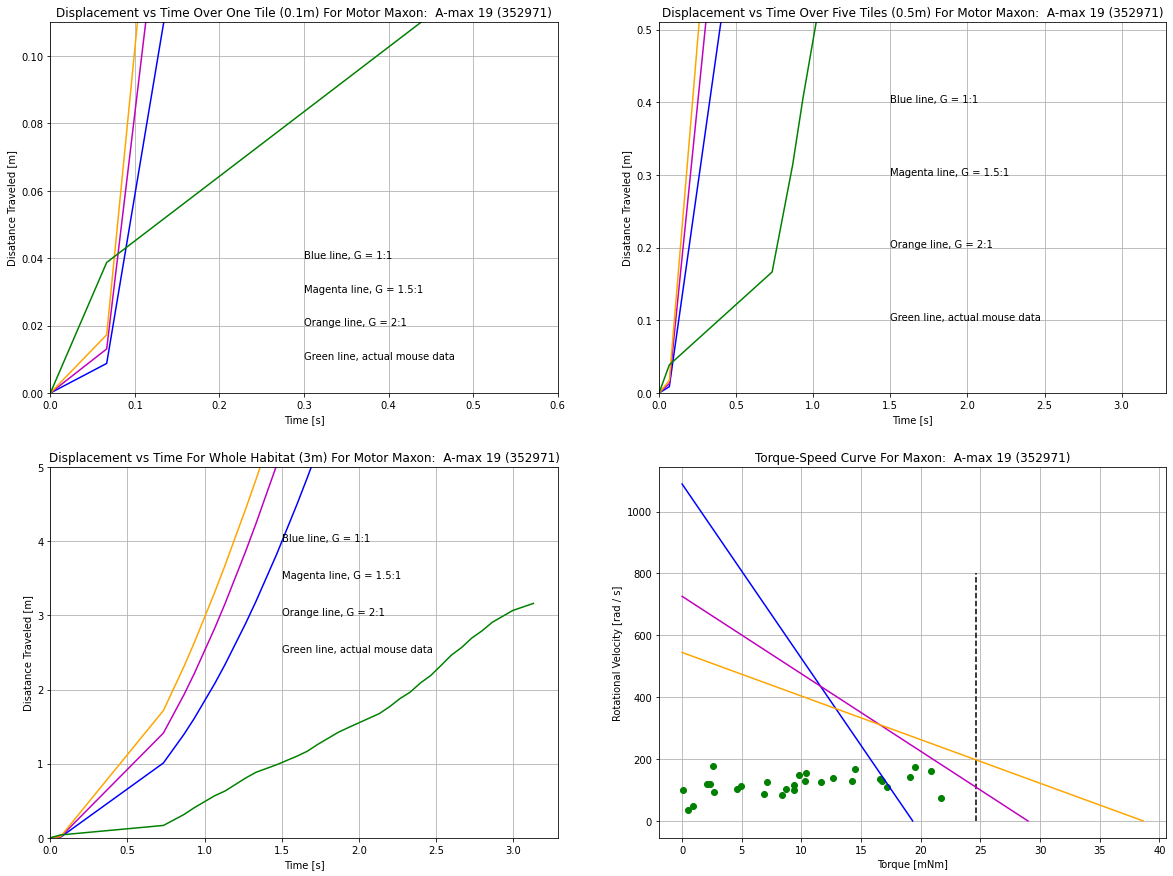

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 9420.0 and omega=986.460093227195


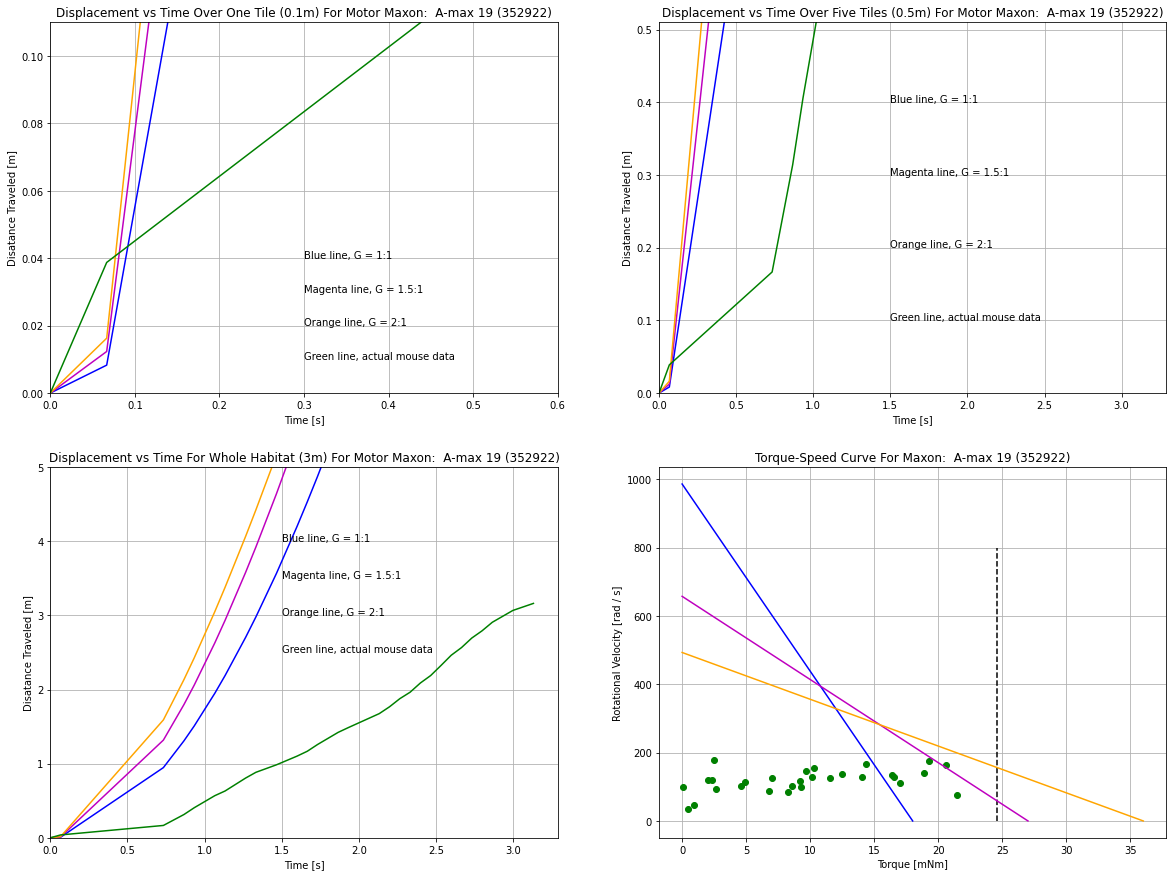

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 12200.0 and omega=1277.5810124598493


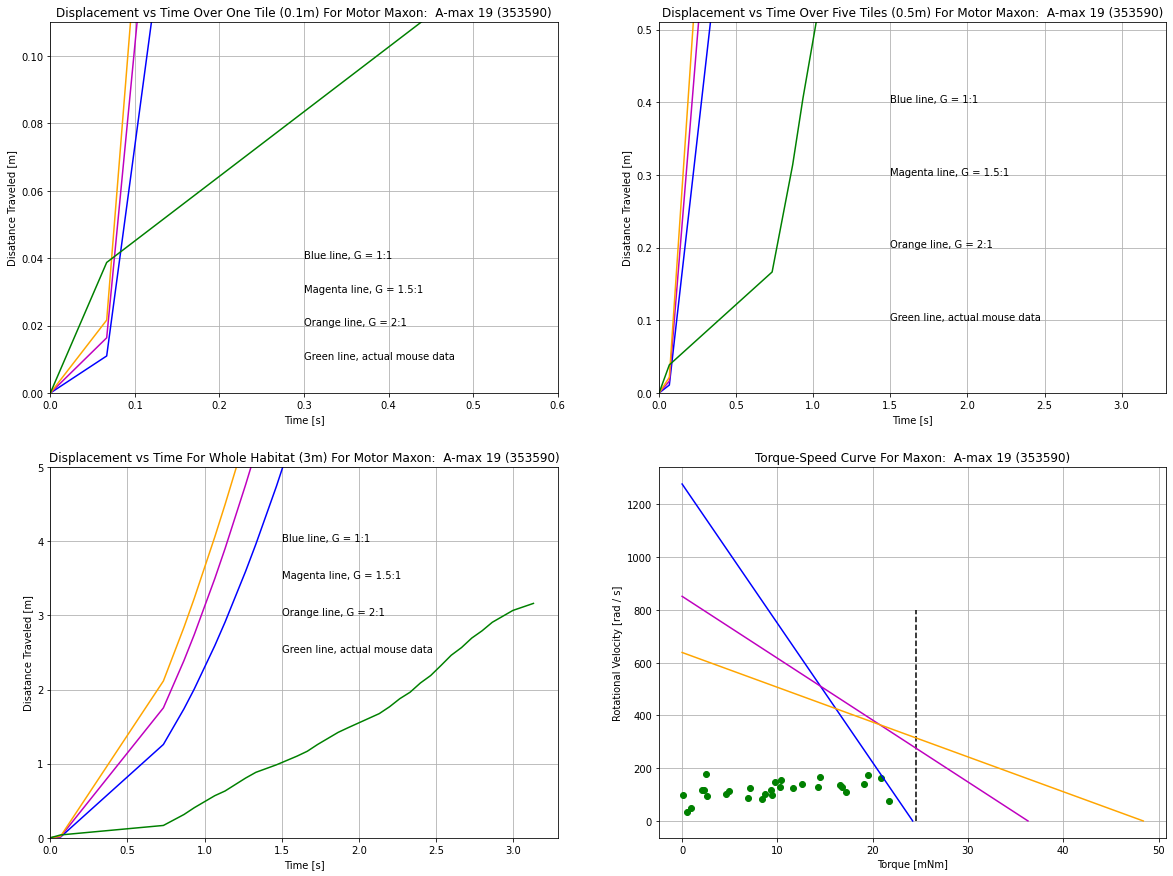

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 7790.0 and omega=815.7668923821496


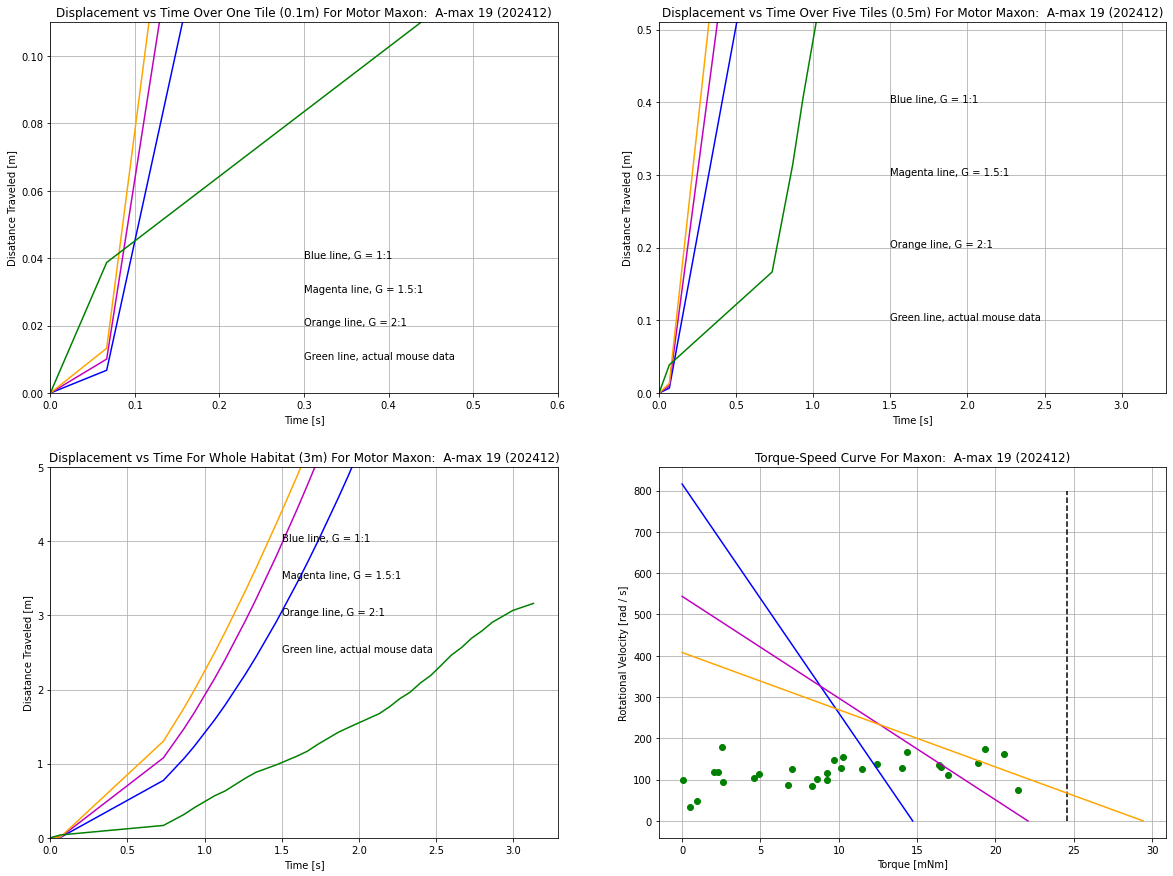

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 8800.0 and omega=921.533845053006


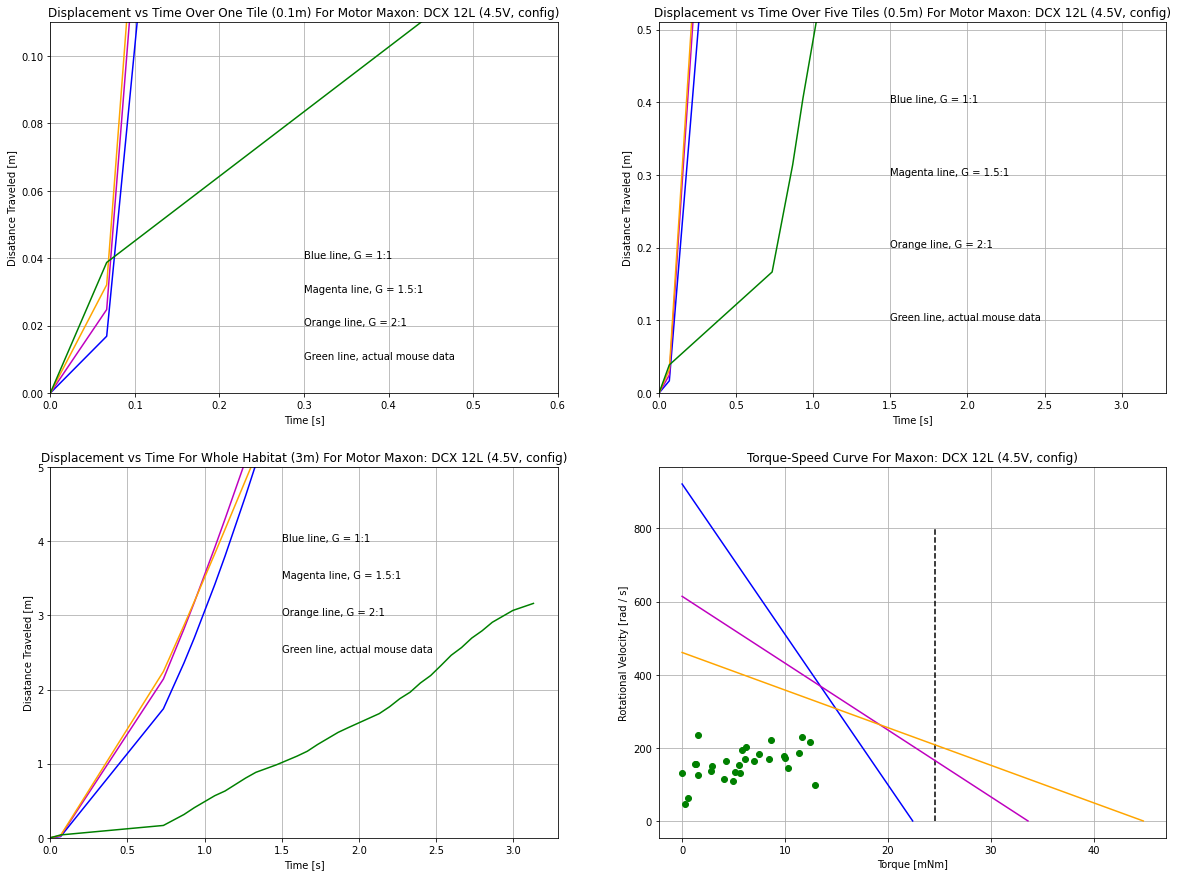

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 8800.0 and omega=921.533845053006


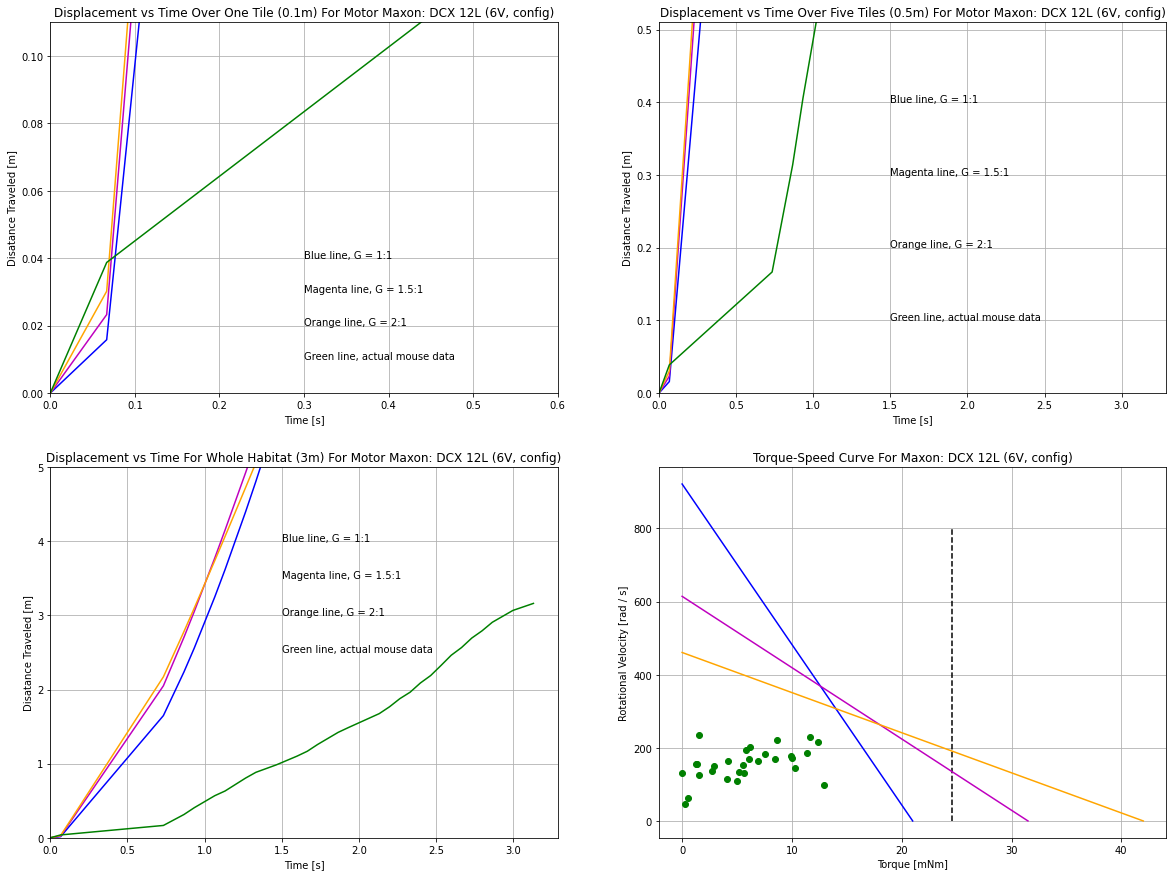

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 6580.0 and omega=689.0559886873613


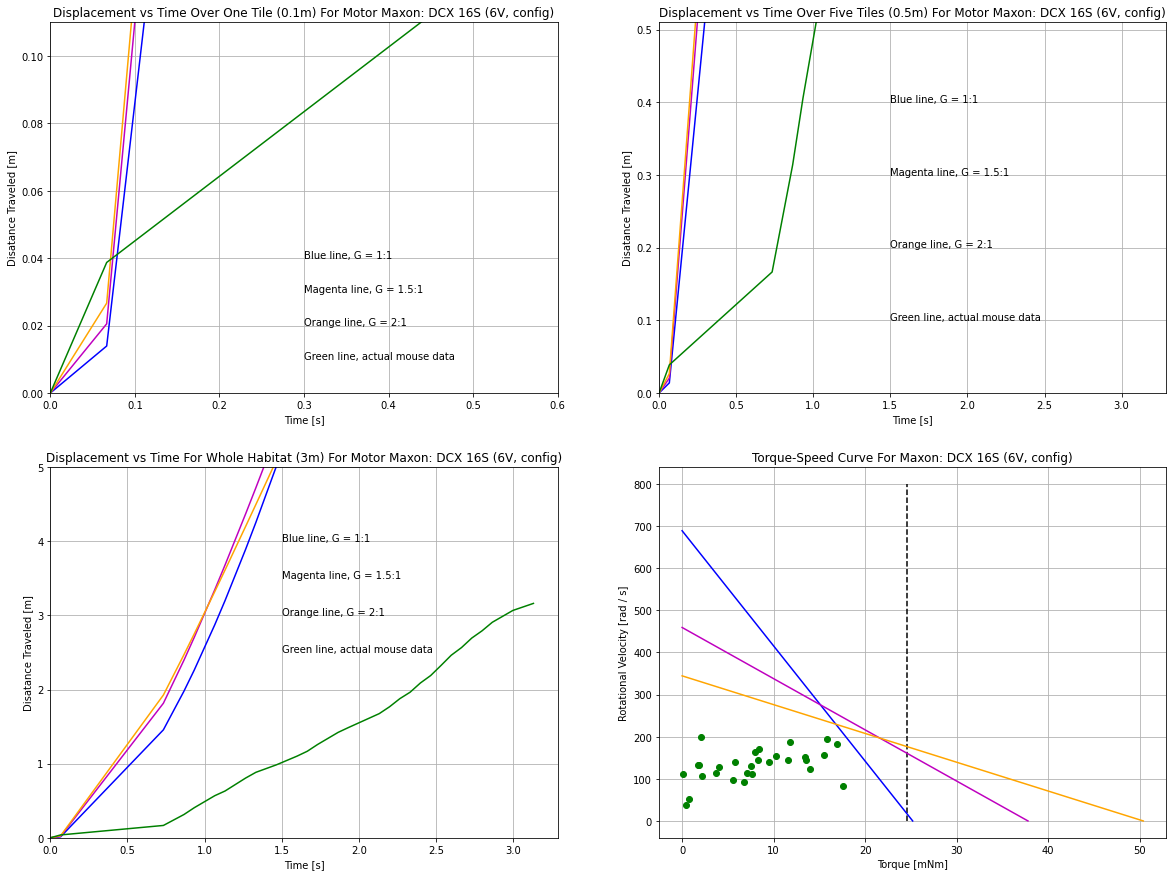

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 12200.0 and omega=1277.5810124598493


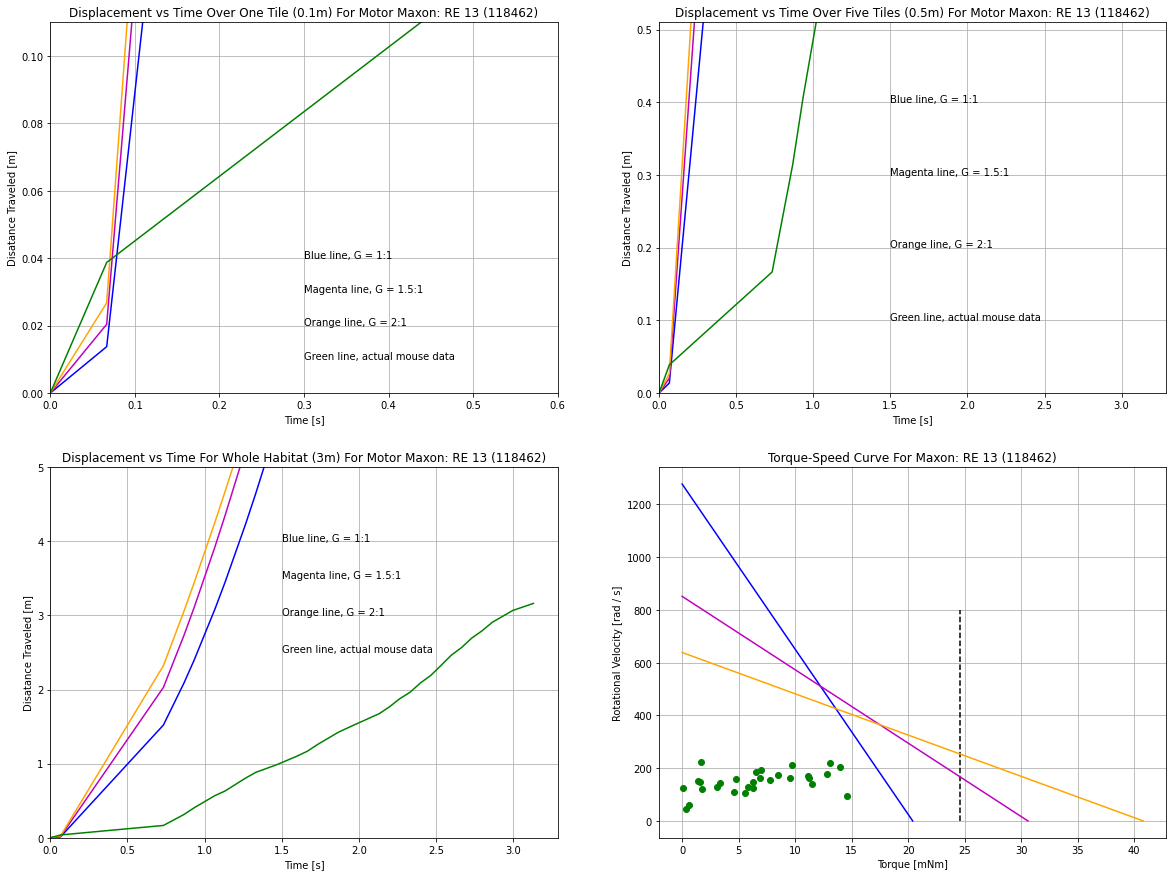

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 11400.0 and omega=1193.8052083641212


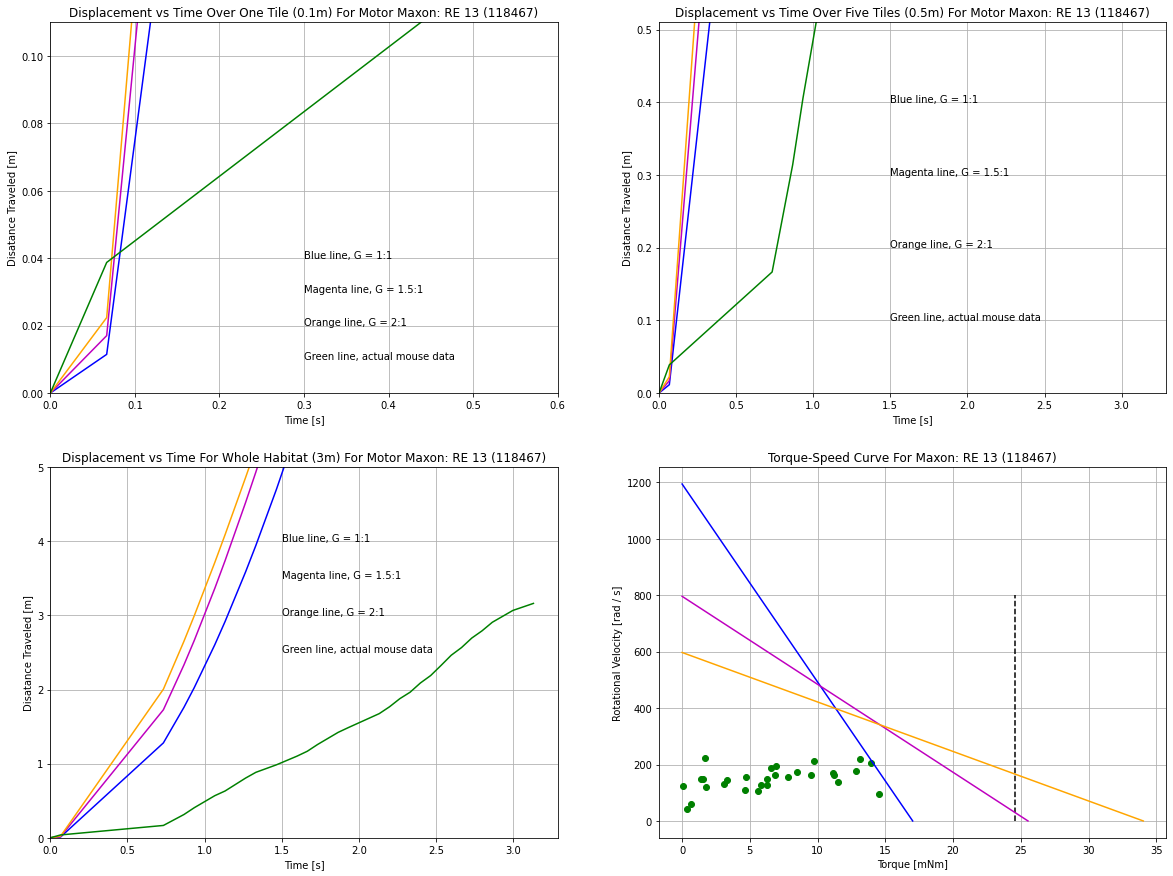

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

No load RPM 11400.0 and omega=1193.8052083641212


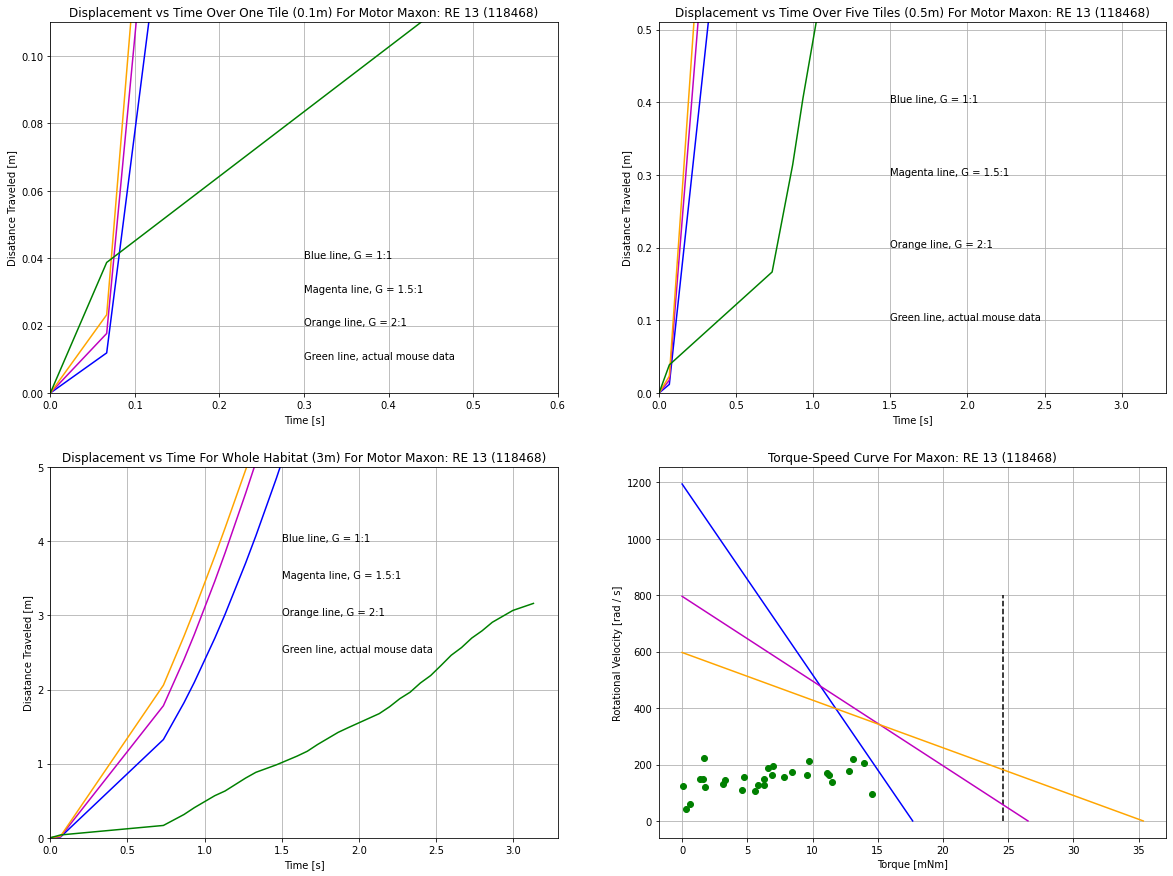

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [13]:
                                                # Plot 2.5W Motors #
G5 = 1
G6 = 1.5
G7 = 2
print("THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2")
print("THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA\n")
for i in range(len(all_motor_name_25W)): 
    disp_25W_g1, vel_25W_g1, power_25W_g1, tor_25W_g1, w_25W_g1 = get_motor_info(G1, i, time, all_motor_diam_25W, all_motor_kt_25W, all_single_motor_weight_25W, all_nominal_V_25W, all_motor_R_25W, all_motor_stall_t_25W, all_motor_no_load_RPM_25W, all_motor_eff_25W)
    disp_25W_g5, vel_25W_g5, power_25W_g5, tor_25W_g5, w_25W_g5 = get_motor_info(G5, i, time, all_motor_diam_25W, all_motor_kt_25W, all_single_motor_weight_25W, all_nominal_V_25W, all_motor_R_25W, all_motor_stall_t_25W, all_motor_no_load_RPM_25W, all_motor_eff_25W)
    disp_25W_g6, vel_25W_g6, power_25W_g6, tor_25W_g6, w_25W_g6 = get_motor_info(G6, i, time, all_motor_diam_25W, all_motor_kt_25W, all_single_motor_weight_25W, all_nominal_V_25W, all_motor_R_25W, all_motor_stall_t_25W, all_motor_no_load_RPM_25W, all_motor_eff_25W)
    disp_25W_g7, vel_25W_g7, power_25W_g7, tor_25W_g7, w_25W_g7 = get_motor_info(G7, i, time, all_motor_diam_25W, all_motor_kt_25W, all_single_motor_weight_25W, all_nominal_V_25W, all_motor_R_25W, all_motor_stall_t_25W, all_motor_no_load_RPM_25W, all_motor_eff_25W)
    
    motor_stall_t_25W = all_motor_stall_t_25W[i] * 2 # Multiply by 2 since we have 2 motors
    motor_no_load_RPM_25W = all_motor_no_load_RPM_25W[i]
    no_load_w_25W = (2*math.pi*motor_no_load_RPM_25W) / 60
    
    print(f"No load RPM {motor_no_load_RPM_25W} and omega={no_load_w_25W}")
    
    tau_25W_mouse = []
    for t in tor_25W_g1:
        tau_25W_mouse.append(abs(t) * 1000)
        
    omg_25W_mouse = []
    for w in w_25W_g1:
        omg_25W_mouse.append(abs(w))
        
    fig, ((ax24, ax25), (ax26, ax27)) = plt.subplots(2, 2, figsize=(20, 15))
    
############## Make the first graph: One Tile vs Time graph ####################
    ax24.plot(seconds, disp_25W_g5, '-b')
    ax24.plot(seconds, disp_25W_g6, '-m')
    ax24.plot(seconds, disp_25W_g7, '-', color='orange')
    ax24.plot(seconds,distance_meter, '-g')
    ax24.set_xlabel('Time [s]')
    ax24.set_ylabel('Disatance Traveled [m]')
    ax24.grid(b=None, which='both', axis='both')
    ax24.text(0.3, 0.04, f"Blue line, G = {G5}:1")
    ax24.text(0.3, 0.03, f"Magenta line, G = {G6}:1")
    ax24.text(0.3, 0.02, f"Orange line, G = {G7}:1")
    ax24.text(0.3, 0.01, f"Green line, actual mouse data")
    ax24.set_ylim(bottom= 0, top = 0.11)
    ax24.set_xlim(left= 0, right = 0.6)
    ax24.set_title(f'Displacement vs Time Over One Tile (0.1m) For Motor {all_motor_name_25W[i]}')

############## Make the second graph: Five tiles vs Time graph ####################
    ax25.plot(seconds, disp_25W_g5, '-b')
    ax25.plot(seconds, disp_25W_g6, '-m')
    ax25.plot(seconds, disp_25W_g7, '-', color='orange')
    ax25.plot(seconds,distance_meter, '-g')
    ax25.set_xlabel('Time [s]')
    ax25.set_ylabel('Disatance Traveled [m]')
    ax25.text(1.5, 0.4, f"Blue line, G = {G5}:1")
    ax25.text(1.5, 0.3, f"Magenta line, G = {G6}:1")
    ax25.text(1.5, 0.2, f"Orange line, G = {G7}:1")
    ax25.text(1.5, 0.1, f"Green line, actual mouse data")
    ax25.grid(b=None, which='both', axis='both')
    ax25.set_ylim(bottom= 0, top = 0.51)
    ax25.set_xlim(left= 0)
    ax25.set_title(f'Displacement vs Time Over Five Tiles (0.5m) For Motor {all_motor_name_25W[i]}')
    
############## Make the third graph: Dist vs Time graph ####################
    ax26.plot(seconds, disp_25W_g5, '-b')
    ax26.plot(seconds, disp_25W_g6, '-m')
    ax26.plot(seconds, disp_25W_g7, '-', color='orange')
    ax26.plot(seconds,distance_meter, '-g')
    ax26.set_xlabel('Time [s]')
    ax26.set_ylabel('Disatance Traveled [m]')
    ax26.grid(b=None, which='both', axis='both')
    ax26.text(1.5, 4, f"Blue line, G = {G5}:1")
    ax26.text(1.5, 3.5, f"Magenta line, G = {G6}:1")
    ax26.text(1.5, 3, f"Orange line, G = {G7}:1")
    ax26.text(1.5, 2.5, f"Green line, actual mouse data")
    ax26.set_ylim(bottom= 0, top = 5.0)
    ax26.set_xlim(left= 0)
    ax26.set_title(f'Displacement vs Time For Whole Habitat (3m) For Motor {all_motor_name_25W[i]}')
    
############## Make the fourth graph: Torque-speed curve graph #################### 
    ax27.plot(tau_25W_mouse, omg_25W_mouse, "og") 
    ax27.plot([0, motor_stall_t_25W*G5], [no_load_w_25W / G5, 0], "-b")
    ax27.plot([0, motor_stall_t_25W*G6], [no_load_w_25W / G6, 0], "-m")
    ax27.plot([0, motor_stall_t_25W*G7], [no_load_w_25W / G7, 0], "-", color = "orange")
    ax27.vlines(tau_max, 0, 800, linestyle = "dashed", color = "black")
    ax27.grid(b=None, which='both', axis='both')
    ax27.set_xlabel('Torque [mNm]')
    ax27.set_ylabel('Rotational Velocity [rad / s]')
    ax27.set_title(f'Torque-Speed Curve For {all_motor_name_25W[i]}')
    
    plt.show()

    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

## All of the 2.5W Motors can reach the max torque and they handle the nominal torque and speed requirements fine. Need at least a 1.5 GR

# EXAMINE THE 3 MOTOR TRAJECTORIES GIVEN DIFFERENT GEAR RATIOS

THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2
THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA



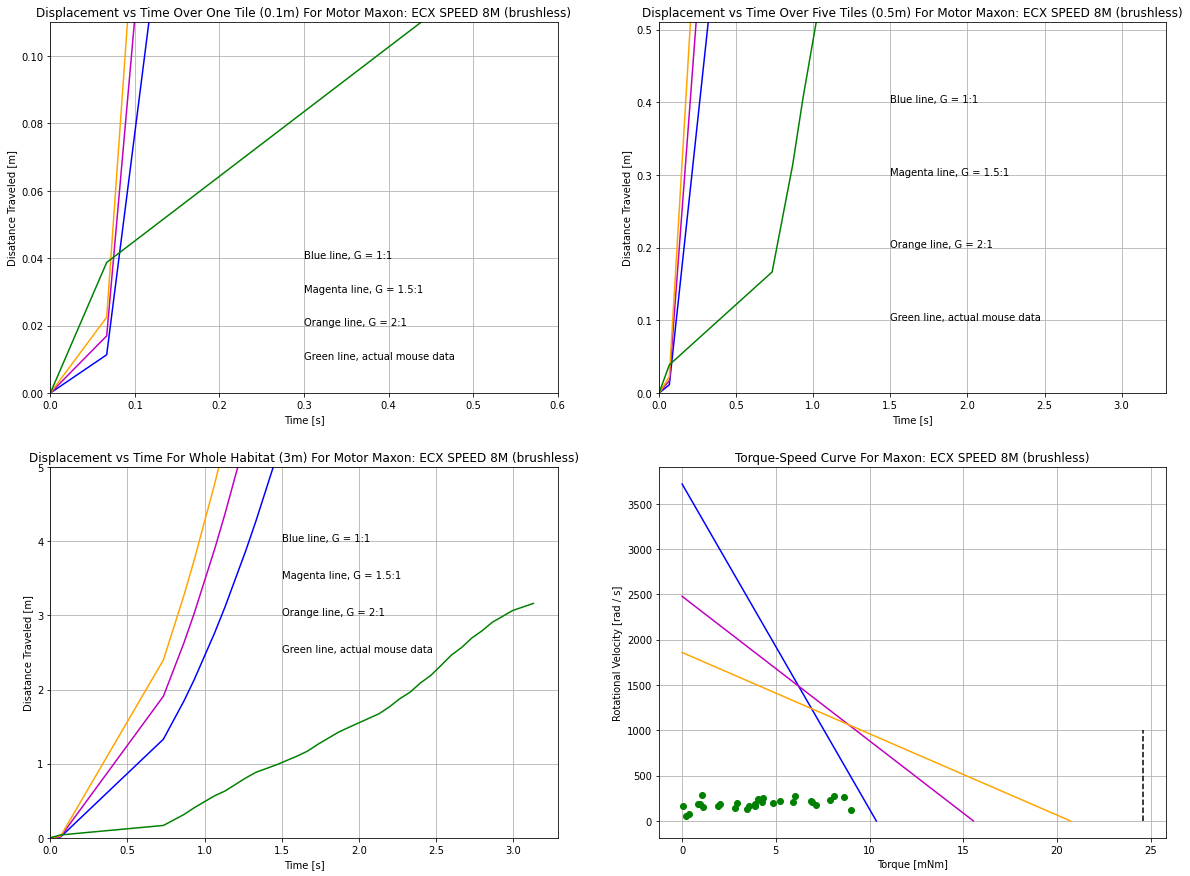

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



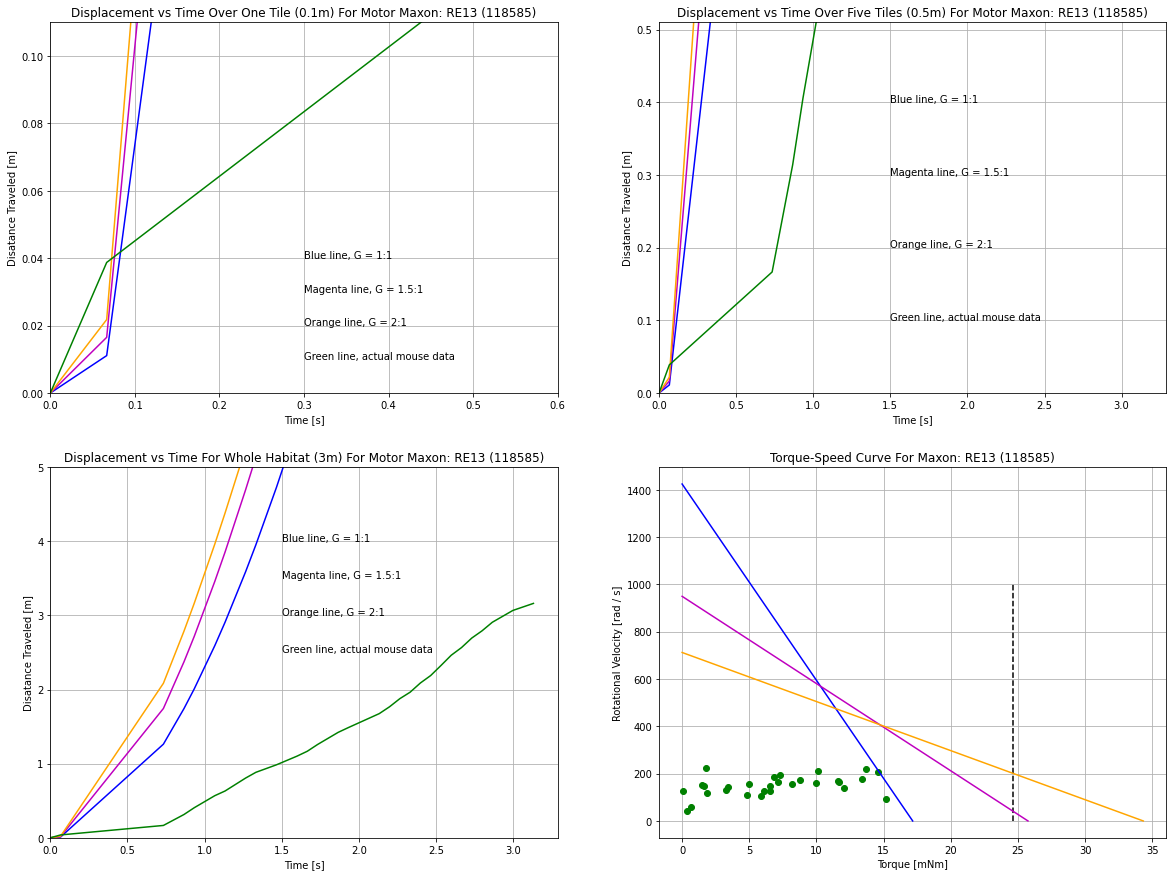

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



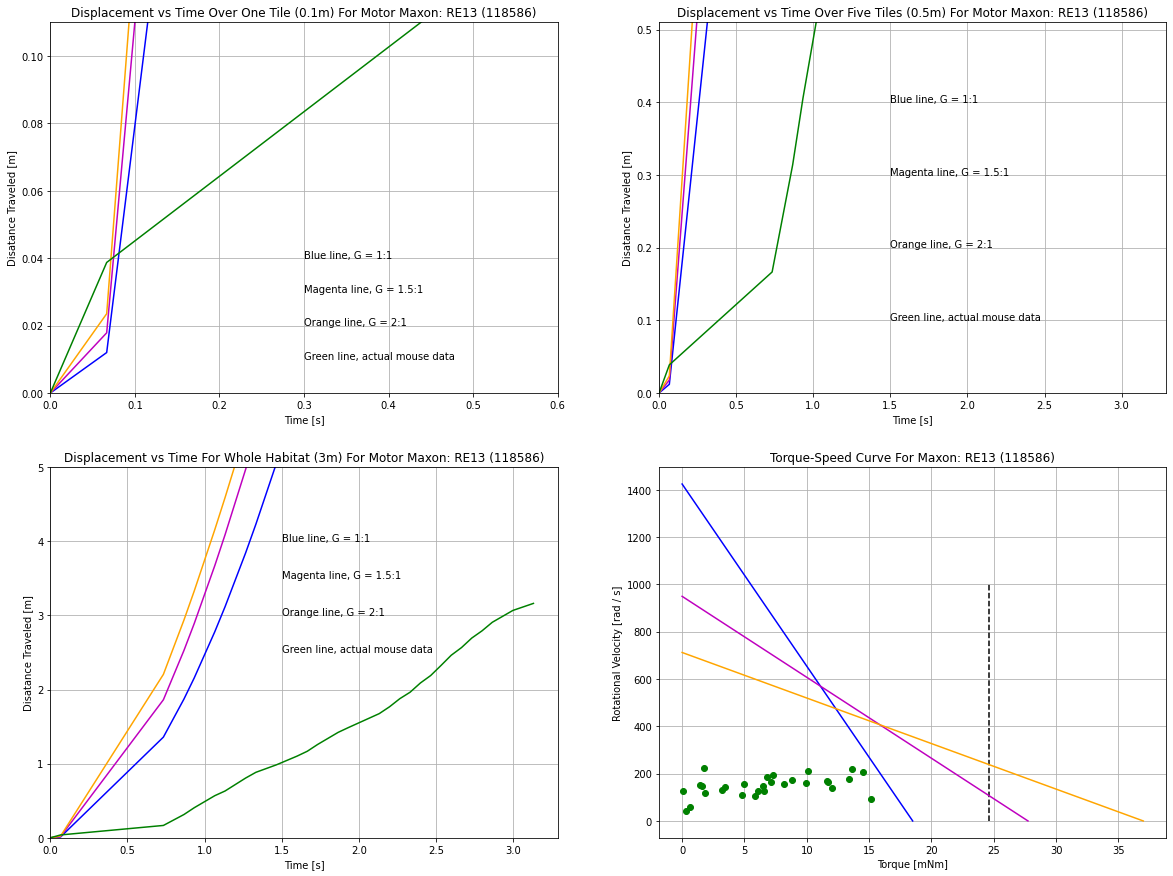

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



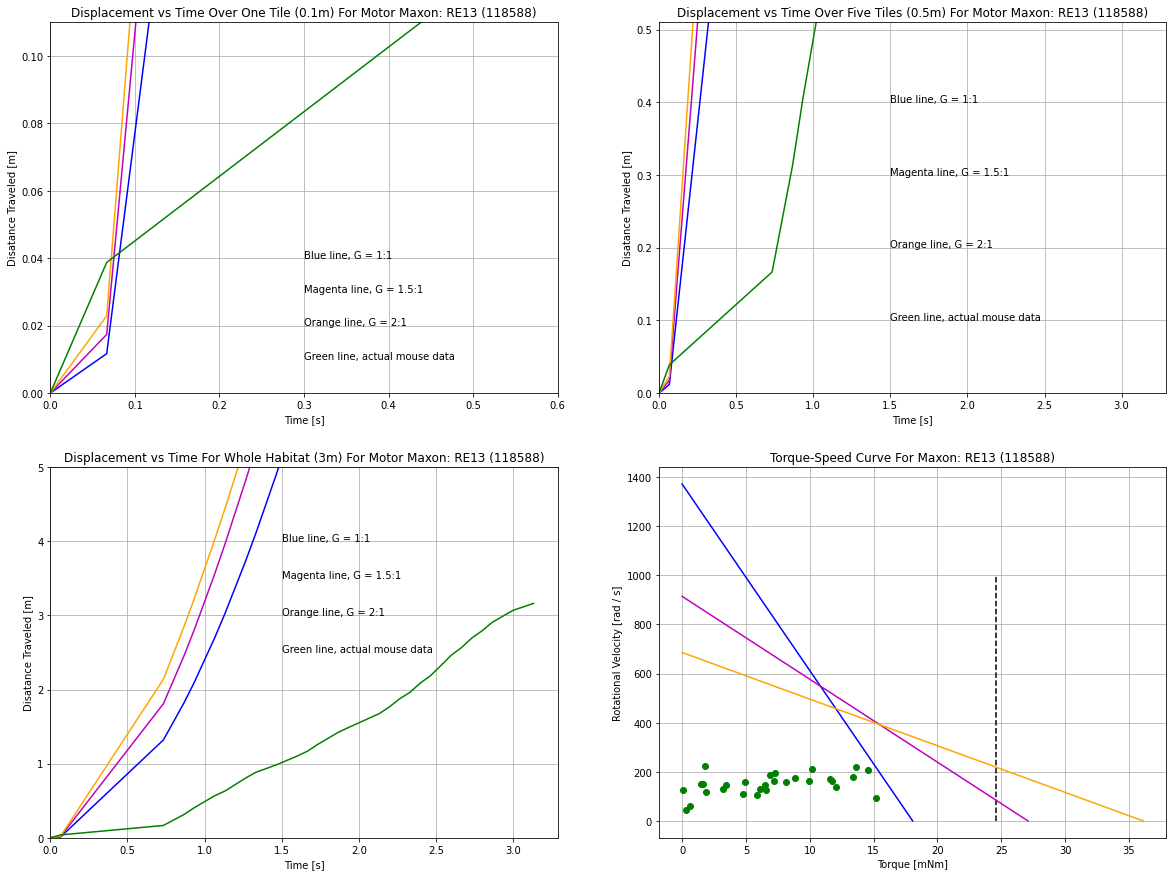

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



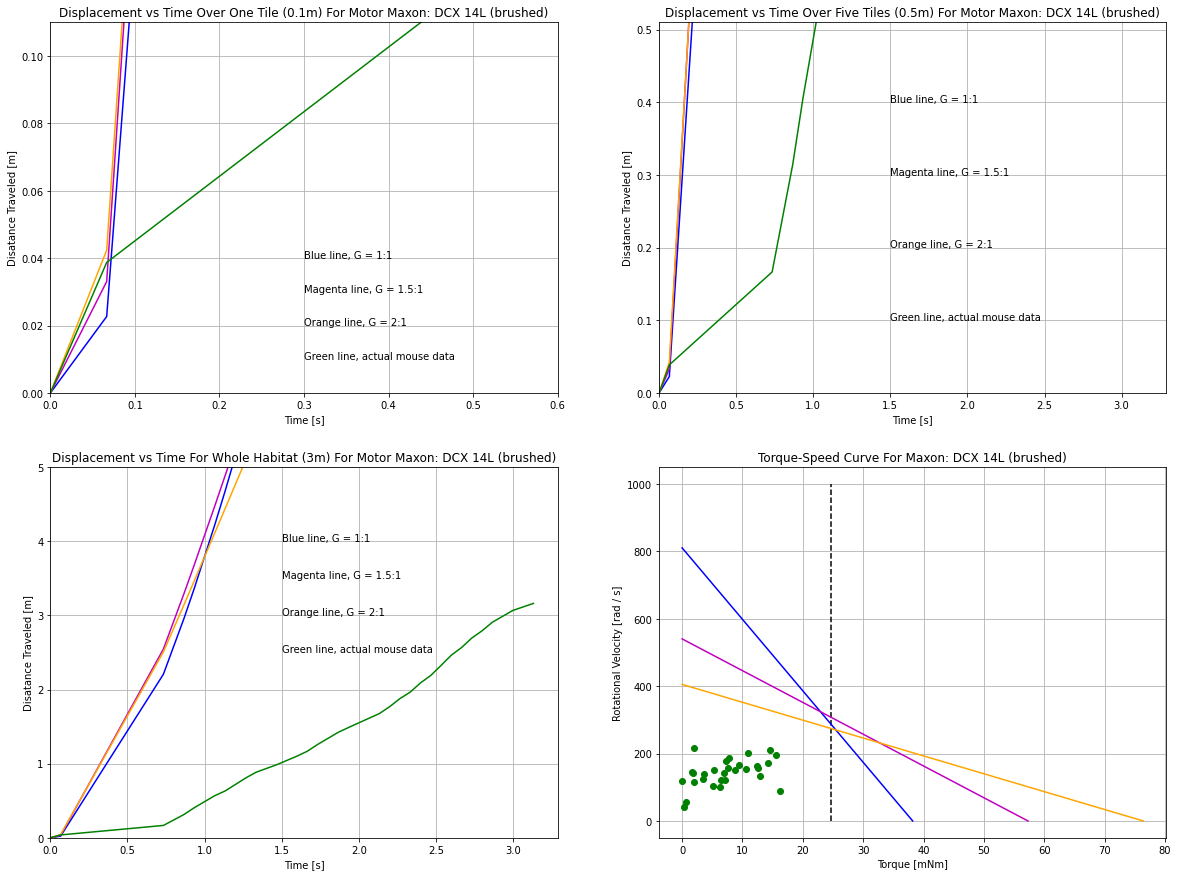

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



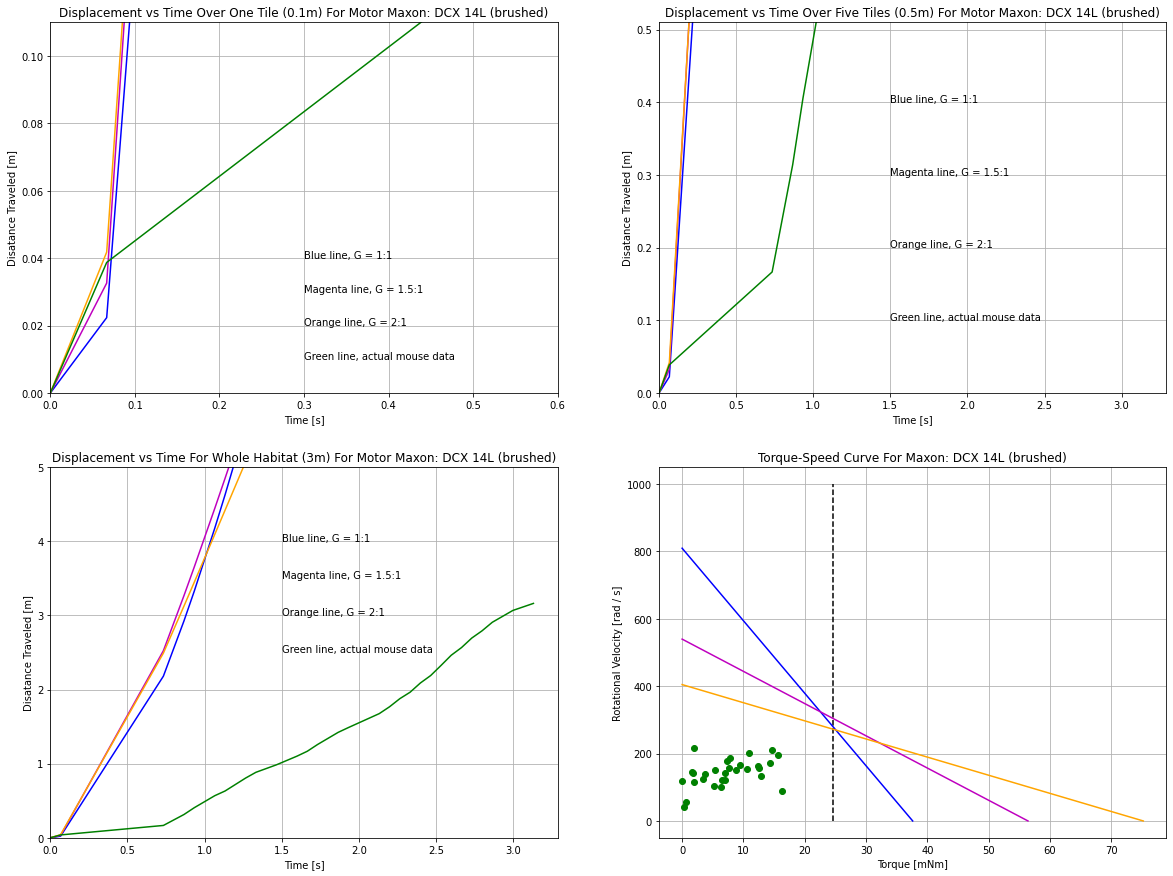

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



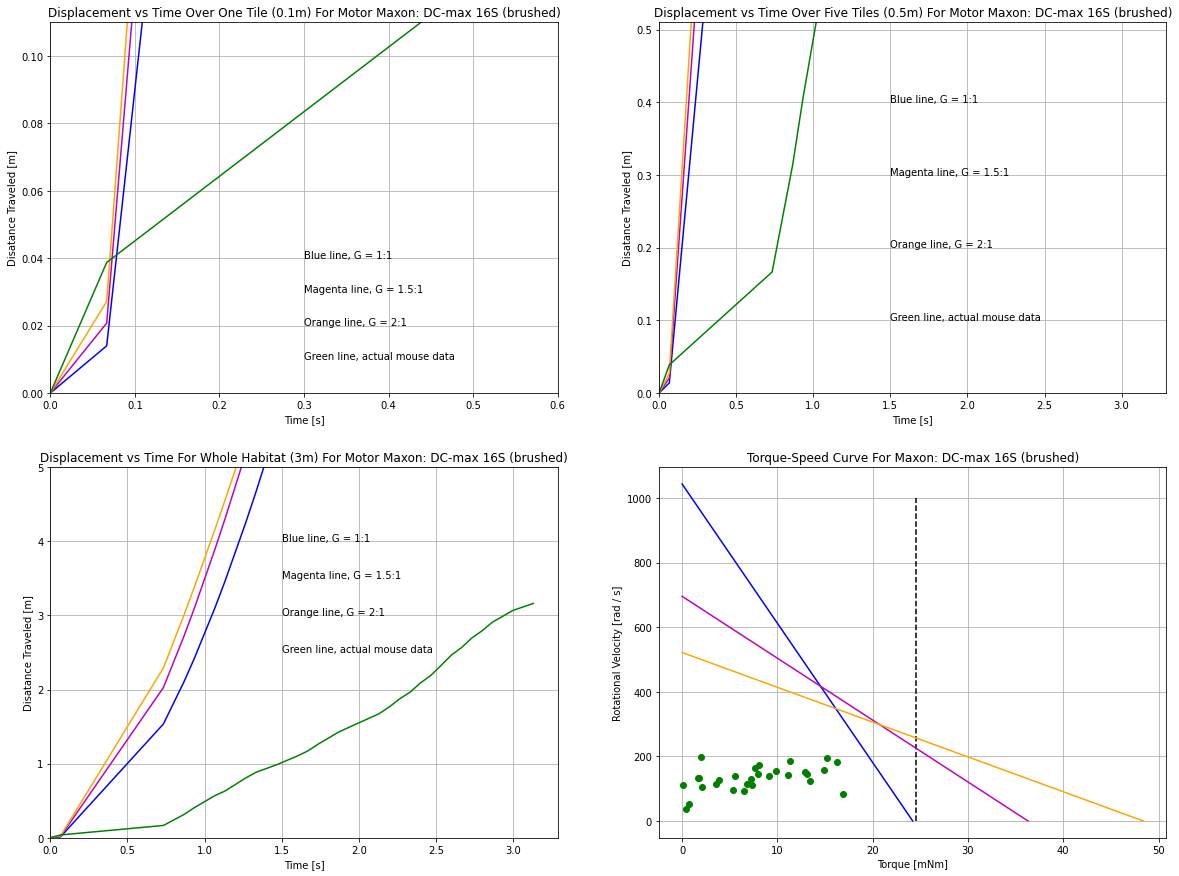

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



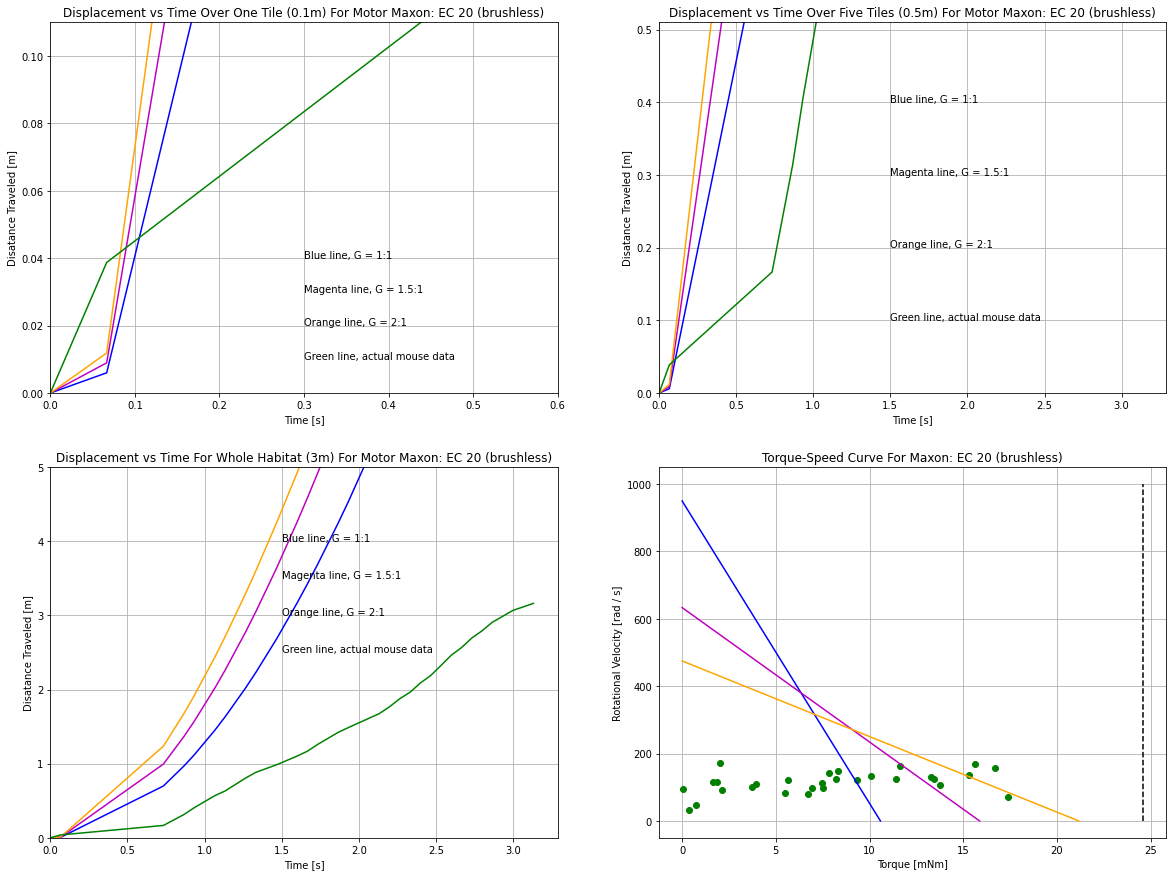

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



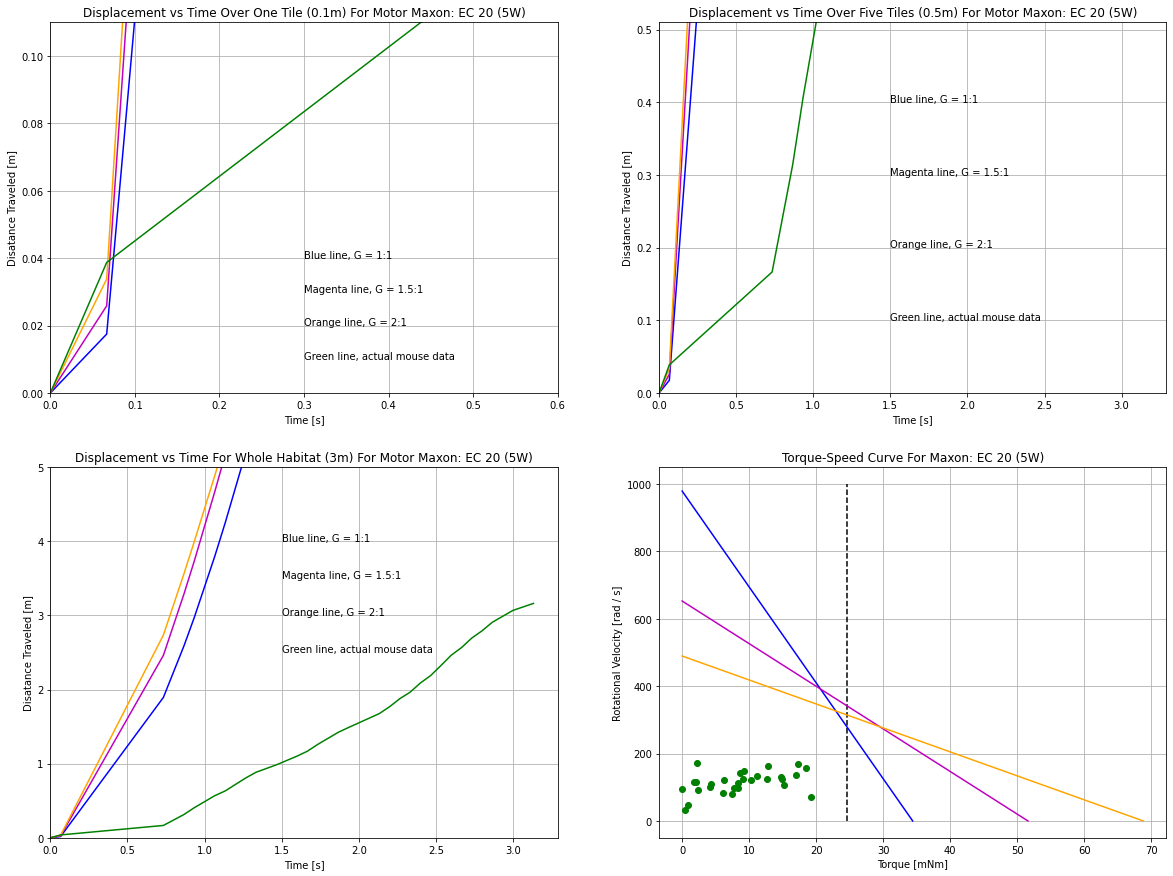

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [14]:
                                                # Plot 3W Motors #
G8 = 1
G9 = 1.5
G10 = 2
print("THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2")
print("THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA\n")
for i in range(len(all_motor_name_3W)): 
    disp_3W_g1, vel_3W_g1, power_3W_g1, tor_3W_g1, w_3W_g1 = get_motor_info(G1, i, time, all_motor_diam_3W, all_motor_kt_3W, all_single_motor_weight_3W, all_nominal_V_3W, all_motor_R_3W, all_motor_stall_t_3W, all_motor_no_load_RPM_3W, all_motor_eff_3W)
    disp_3W_g8, vel_3W_g8, power_3W_g8, tor_3W_g8, w_3W_g8 = get_motor_info(G8, i, time, all_motor_diam_3W, all_motor_kt_3W, all_single_motor_weight_3W, all_nominal_V_3W, all_motor_R_3W, all_motor_stall_t_3W, all_motor_no_load_RPM_3W, all_motor_eff_3W)
    disp_3W_g9, vel_3W_g9, power_3W_g9, tor_3W_g9, w_3W_g9 = get_motor_info(G9, i, time, all_motor_diam_3W, all_motor_kt_3W, all_single_motor_weight_3W, all_nominal_V_3W, all_motor_R_3W, all_motor_stall_t_3W, all_motor_no_load_RPM_3W, all_motor_eff_3W)
    disp_3W_g10, vel_3W_g10, power_3W_g10, tor_3W_g10, w_3W_g10 = get_motor_info(G10, i, time, all_motor_diam_3W, all_motor_kt_3W, all_single_motor_weight_3W, all_nominal_V_3W, all_motor_R_3W, all_motor_stall_t_3W, all_motor_no_load_RPM_3W, all_motor_eff_3W)
    
    motor_stall_t_3W = all_motor_stall_t_3W[i] * 2 # Multiply by 2 since we have 2 motors
    motor_no_load_RPM_3W = all_motor_no_load_RPM_3W[i]
    no_load_w_3W = (2*math.pi*motor_no_load_RPM_3W) / 60
    
    tau_3W_mouse = []
    for t in tor_3W_g1:
        tau_3W_mouse.append(abs(t) * 1000)
        
    omg_3W_mouse = []
    for w in w_3W_g1:
        omg_3W_mouse.append(abs(w))
        
    tau_max_3W = 0.15*a_max*0.15
        
    fig, ((ax34, ax35), (ax36, ax37)) = plt.subplots(2, 2, figsize=(20, 15))
    
############## Make the first graph: One Tile vs Time graph ####################
    ax34.plot(seconds, disp_3W_g8, '-b')
    ax34.plot(seconds, disp_3W_g9, '-m')
    ax34.plot(seconds, disp_3W_g10, '-', color='orange')
    ax34.plot(seconds,distance_meter, '-g')
    ax34.set_xlabel('Time [s]')
    ax34.set_ylabel('Disatance Traveled [m]')
    ax34.grid(b=None, which='both', axis='both')
    ax34.text(0.3, 0.04, f"Blue line, G = {G8}:1")
    ax34.text(0.3, 0.03, f"Magenta line, G = {G9}:1")
    ax34.text(0.3, 0.02, f"Orange line, G = {G10}:1")
    ax34.text(0.3, 0.01, f"Green line, actual mouse data")
    ax34.set_ylim(bottom= 0, top = 0.11)
    ax34.set_xlim(left= 0, right = 0.6)
    ax34.set_title(f'Displacement vs Time Over One Tile (0.1m) For Motor {all_motor_name_3W[i]}')

############## Make the second graph: Five tiles vs Time graph ####################
    ax35.plot(seconds, disp_3W_g8, '-b')
    ax35.plot(seconds, disp_3W_g9, '-m')
    ax35.plot(seconds, disp_3W_g10, '-', color='orange')
    ax35.plot(seconds,distance_meter, '-g')
    ax35.set_xlabel('Time [s]')
    ax35.set_ylabel('Disatance Traveled [m]')
    ax35.text(1.5, 0.4, f"Blue line, G = {G8}:1")
    ax35.text(1.5, 0.3, f"Magenta line, G = {G9}:1")
    ax35.text(1.5, 0.2, f"Orange line, G = {G10}:1")
    ax35.text(1.5, 0.1, f"Green line, actual mouse data")
    ax35.grid(b=None, which='both', axis='both')
    ax35.set_ylim(bottom= 0, top = 0.51)
    ax35.set_xlim(left= 0)
    ax35.set_title(f'Displacement vs Time Over Five Tiles (0.5m) For Motor {all_motor_name_3W[i]}')
    
############## Make the third graph: Dist vs Time graph ####################
    ax36.plot(seconds, disp_3W_g8, '-b')
    ax36.plot(seconds, disp_3W_g9, '-m')
    ax36.plot(seconds, disp_3W_g10, '-', color='orange')
    ax36.plot(seconds,distance_meter, '-g')
    ax36.set_xlabel('Time [s]')
    ax36.set_ylabel('Disatance Traveled [m]')
    ax36.grid(b=None, which='both', axis='both')
    ax36.text(1.5, 4, f"Blue line, G = {G8}:1")
    ax36.text(1.5, 3.5, f"Magenta line, G = {G9}:1")
    ax36.text(1.5, 3, f"Orange line, G = {G10}:1")
    ax36.text(1.5, 2.5, f"Green line, actual mouse data")
    ax36.set_ylim(bottom= 0, top = 5.0)
    ax36.set_xlim(left= 0)
    ax36.set_title(f'Displacement vs Time For Whole Habitat (3m) For Motor {all_motor_name_3W[i]}')
    
############## Make the fourth graph: Torque-speed curve graph #################### 
    ax37.plot(tau_3W_mouse, omg_3W_mouse, "og") 
    ax37.plot([0, motor_stall_t_3W*G8], [no_load_w_3W / G8, 0], "-b")
    ax37.plot([0, motor_stall_t_3W*G9], [no_load_w_3W / G9, 0], "-m")
    ax37.plot([0, motor_stall_t_3W*G10], [no_load_w_3W / G10, 0], "-", color = "orange")
    ax37.vlines(tau_max, 0, 1000, linestyle = "dashed", color = "black")
    ax37.grid(b=None, which='both', axis='both')
    ax37.set_xlabel('Torque [mNm]')
    ax37.set_ylabel('Rotational Velocity [rad / s]')
    ax37.set_title(f'Torque-Speed Curve For {all_motor_name_3W[i]}')
    
    plt.show()

    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

## Based on their Torque-Speed Curves above, lets visualize a couple of top contenders 

THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2
THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA



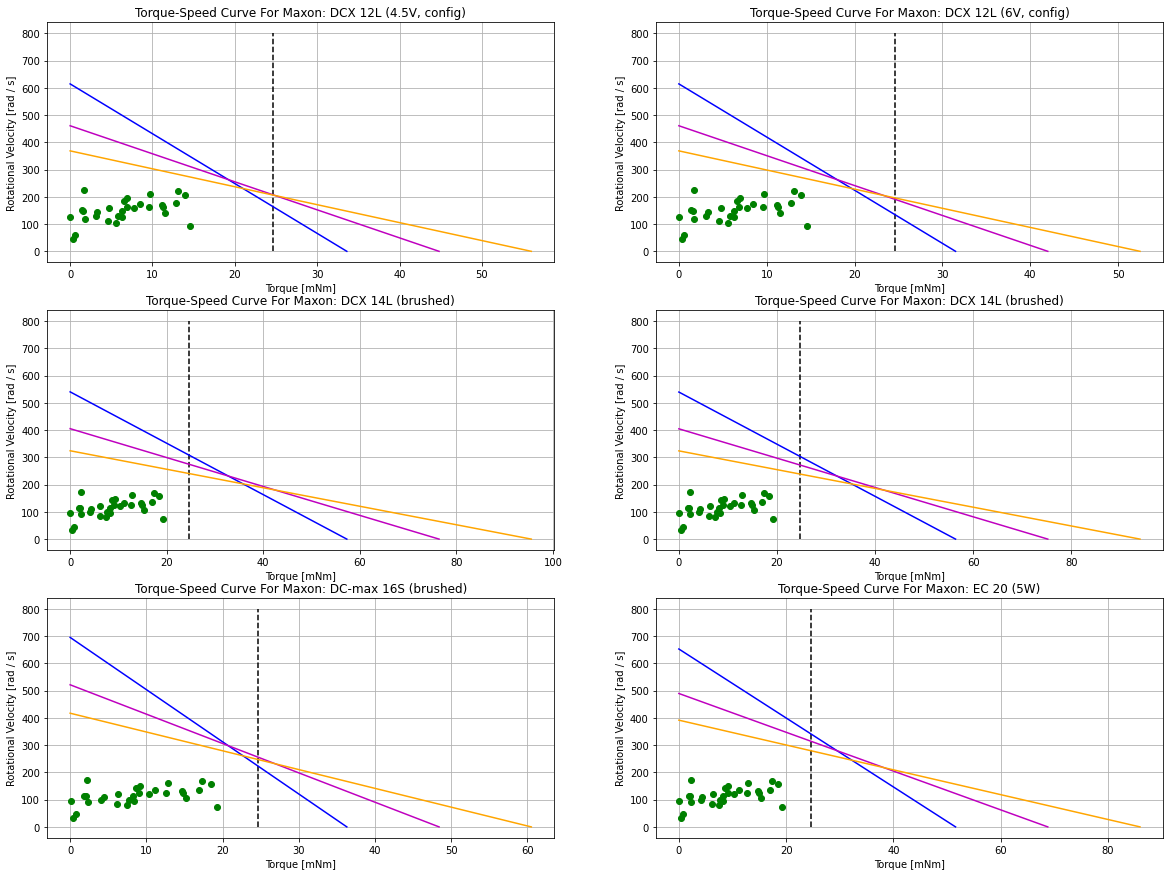

In [15]:
# From 2.5W: DCX 12L (4.5V, config) [index=4], DCX 12L (6V, config) [index=5]
# From 3W: Both DC 14L [index=4-5], DCX 16S[index=] and EC 20 5W [index=8]

motor1 = 4
motor2 = 5

motor3 = 4
motor4 = 5
motor5 = 6
motor6 = 8

G20 = 1.5
G21 = 2
G22 = 2.5
       
DCX12L_4V_25W = all_motor_stall_t_25W[motor1] * 2 # Multiply by 2 since we have 2 motors
DCX12L_6V_25W = all_motor_stall_t_25W[motor2] * 2 # Multiply by 2 since we have 2 motors
DC14L_4V_3W = all_motor_stall_t_3W[motor3] * 2 # Multiply by 2 since we have 2 motors
DC14L_6V_3W = all_motor_stall_t_3W[motor4] * 2 # Multiply by 2 since we have 2 motors
DC16S_3W = all_motor_stall_t_3W[motor5] * 2 # Multiply by 2 since we have 2 motors
EC20_5W = all_motor_stall_t_3W[motor6] * 2 # Multiply by 2 since we have 2 motors

DCX12L_4V_RPM_25W = all_motor_no_load_RPM_25W[motor1]
DCX12L_6V_RPM_25W = all_motor_no_load_RPM_25W[motor2]
DC14L_4V_RPM_3W = all_motor_no_load_RPM_3W[motor3]
DC14L_6V_RPM_3W = all_motor_no_load_RPM_3W[motor4]
DC16S_RPM_3W = all_motor_no_load_RPM_3W[motor5]
EC20_RPM_5W = all_motor_no_load_RPM_3W[motor6]

DCX12L_4V_w_25W = (2*math.pi*DCX12L_4V_RPM_25W) / 60
DCX12L_6V_w_25W = (2*math.pi*DCX12L_6V_RPM_25W) / 60
DCX14L_4V_w_3W = (2*math.pi*DC14L_4V_RPM_3W) / 60
DCX14L_6V_w_3W = (2*math.pi*DC14L_6V_RPM_3W) / 60
DCX16S_w_3W = (2*math.pi*DC16S_RPM_3W) / 60
EC20_w_5W = (2*math.pi*EC20_RPM_5W) / 60

fig, ((ax70, ax71), (ax72, ax73), (ax74, ax75)) = plt.subplots(3, 2, figsize=(20, 15))
print("THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2")
print("THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA\n")
################################# 
ax70.plot(tau_25W_mouse, omg_25W_mouse, "og") 
ax70.plot([0, DCX12L_4V_25W*G20], [DCX12L_4V_w_25W / G20, 0], "-b")
ax70.plot([0, DCX12L_4V_25W*G21], [DCX12L_4V_w_25W  / G21, 0], "-m")
ax70.plot([0, DCX12L_4V_25W*G22], [DCX12L_4V_w_25W  / G22, 0], "-", color = "orange")
ax70.vlines(tau_max, 0, 800, linestyle = "dashed", color = "black")
ax70.grid(b=None, which='both', axis='both')
ax70.set_xlabel('Torque [mNm]')
ax70.set_ylabel('Rotational Velocity [rad / s]')
ax70.set_title(f'Torque-Speed Curve For {all_motor_name_25W[motor1]}')

################################# 
ax71.plot(tau_25W_mouse, omg_25W_mouse, "og") 
ax71.plot([0, DCX12L_6V_25W*G20], [DCX12L_6V_w_25W / G20, 0], "-b")
ax71.plot([0, DCX12L_6V_25W*G21], [DCX12L_6V_w_25W  / G21, 0], "-m")
ax71.plot([0, DCX12L_6V_25W*G22], [DCX12L_6V_w_25W  / G22, 0], "-", color = "orange")
ax71.vlines(tau_max, 0, 800, linestyle = "dashed", color = "black")
ax71.grid(b=None, which='both', axis='both')
ax71.set_xlabel('Torque [mNm]')
ax71.set_ylabel('Rotational Velocity [rad / s]')
ax71.set_title(f'Torque-Speed Curve For {all_motor_name_25W[motor2]}')

################################# 
ax72.plot(tau_3W_mouse, omg_3W_mouse, "og") 
ax72.plot([0, DC14L_4V_3W*G20], [DCX14L_4V_w_3W / G20, 0], "-b")
ax72.plot([0, DC14L_4V_3W*G21], [DCX14L_4V_w_3W / G21, 0], "-m")
ax72.plot([0, DC14L_4V_3W*G22], [DCX14L_4V_w_3W  / G22, 0], "-", color = "orange")
ax72.vlines(tau_max, 0, 800, linestyle = "dashed", color = "black")
ax72.grid(b=None, which='both', axis='both')
ax72.set_xlabel('Torque [mNm]')
ax72.set_ylabel('Rotational Velocity [rad / s]')
ax72.set_title(f'Torque-Speed Curve For {all_motor_name_3W[motor3]}')

################################# 
ax73.plot(tau_3W_mouse, omg_3W_mouse, "og") 
ax73.plot([0, DC14L_6V_3W*G20], [DCX14L_6V_w_3W / G20, 0], "-b")
ax73.plot([0, DC14L_6V_3W*G21], [DCX14L_6V_w_3W / G21, 0], "-m")
ax73.plot([0, DC14L_6V_3W*G22], [DCX14L_6V_w_3W  / G22, 0], "-", color = "orange")
ax73.vlines(tau_max, 0, 800, linestyle = "dashed", color = "black")
ax73.grid(b=None, which='both', axis='both')
ax73.set_xlabel('Torque [mNm]')
ax73.set_ylabel('Rotational Velocity [rad / s]')
ax73.set_title(f'Torque-Speed Curve For {all_motor_name_3W[motor4]}')

################################# 
ax74.plot(tau_3W_mouse, omg_3W_mouse, "og") 
ax74.plot([0, DC16S_3W*G20], [DCX16S_w_3W / G20, 0], "-b")
ax74.plot([0, DC16S_3W*G21], [DCX16S_w_3W   / G21, 0], "-m")
ax74.plot([0, DC16S_3W*G22], [DCX16S_w_3W   / G22, 0], "-", color = "orange")
ax74.vlines(tau_max, 0, 800, linestyle = "dashed", color = "black")
ax74.grid(b=None, which='both', axis='both')
ax74.set_xlabel('Torque [mNm]')
ax74.set_ylabel('Rotational Velocity [rad / s]')
ax74.set_title(f'Torque-Speed Curve For {all_motor_name_3W[motor5]}')

################################# 
ax75.plot(tau_3W_mouse, omg_3W_mouse, "og") 
ax75.plot([0, EC20_5W*G20], [EC20_w_5W / G20, 0], "-b")
ax75.plot([0, EC20_5W*G21], [EC20_w_5W / G21, 0], "-m")
ax75.plot([0, EC20_5W*G22], [EC20_w_5W / G22, 0], "-", color = "orange")
ax75.vlines(tau_max, 0, 800, linestyle = "dashed", color = "black")
ax75.grid(b=None, which='both', axis='both')
ax75.set_xlabel('Torque [mNm]')
ax75.set_ylabel('Rotational Velocity [rad / s]')
ax75.set_title(f'Torque-Speed Curve For {all_motor_name_3W[motor6]}')


plt.show()

### From the graphs above, it seems to me that the DCX 14Ls and the EC20 5W can reach the potential max torque the easiest, no matter the gear ratio. 

## All the 3W motors can reach the max torque and handle the nominal torque and speeds just fine. Lets examine length then (also stall and nominal current)

Since many motors can meet our speed requirements, torque be the deciding factor on gear ratios and motor selection. The mouse can accelerate / decelerate up to 8 $m/{s}^2$, so we'll say at the robot's max it can accleerate up to 8.2 $m/{s}^2$ . Use this max accleeration to determine the maximum torque the robot will need to operate at. 

## Matt's Notes

For any choice you need to know:
1. What is the minimum gear ratio to achieve the required torque.
   - If mice have 8 m/s^2, let's set 8.2m/s that as the acceleration goal (1m/s^2 is a lot of acceleration)
2. What is the maximum gear ratio such that you meet the velocity requirement?
     - Let's set 3m/s as this goal: it seems like the mice can achieve something near there at times
    

# Considering most of these are going to be too long regarless, lets asses the current consumption. 

## Eh I guess we can do a quick length assessment too

In [16]:
len1 = all_motor_length_25W[motor1] / 10
len2 = all_motor_length_25W[motor2] / 10

len3 = all_motor_length_3W[motor3] / 10
len4 = all_motor_length_3W[motor4] / 10
len5 = all_motor_length_3W[motor5] / 10
len6 = all_motor_length_3W[motor6] / 10

nom_current1 = all_nominal_A_25W[motor1] * 2
nom_current2 = all_nominal_A_25W[motor2] * 2

nom_current3 = all_nominal_A_3W[motor3] * 2
nom_current4 = all_nominal_A_3W[motor4] * 2
nom_current5 = all_nominal_A_3W[motor5] * 2
nom_current6 = all_nominal_A_3W[motor6] * 2

stall_current1 = all_motor_stall_A_25W[motor1] * 2
stall_current2 = all_motor_stall_A_25W[motor2] * 2

stall_current3 = all_motor_stall_A_3W[motor3] * 2
stall_current4 = all_motor_stall_A_3W[motor4] * 2
stall_current5 = all_motor_stall_A_3W[motor5] * 2
stall_current6 = all_motor_stall_A_3W[motor6] * 2

print(f"""For 2 {all_motor_name_25W[motor1]} motors... 
          Single Motor Length: {len1}cm
          Double Motor Length: {round(len1*2, 1)}cm
          Nominal Current for both motors: {nom_current1}A
          Stall Current for both motors: {stall_current1}A\n""")

print(f"""For 2 {all_motor_name_25W[motor2]} motors... 
          Single Motor Length: {len2}cm
          Double Motor Length: {round(len2*2, 1)}cm
          Nominal Current for both motors: {nom_current2}A
          Stall Current for both motors: {stall_current2}A\n""")

print(f"""For 2 {all_motor_name_3W[motor3]} motors... 
          Single Motor Length: {len3}cm
          Double Motor Length: {round(len3*2, 1)}cm
          Nominal Current for both motors: {nom_current3}A
          Stall Current for both motors: {stall_current3}A\n""")

print(f"""For 2 {all_motor_name_3W[motor4]} motors... 
          Single Motor Length: {len4}cm
          Double Motor Length: {round(len4*2, 1)}cm
          Nominal Current for both motors: {nom_current4}A
          Stall Current for both motors: {stall_current3}A\n""")

print(f"""For 2 {all_motor_name_3W[motor5]} motors... 
          Single Motor Length: {len5}cm
          Double Motor Length: {round(len5*2, 1)}cm
          Nominal Current for both motors: {nom_current5}A
          Stall Current for both motors: {stall_current5}A\n""")

print(f"""For 2 {all_motor_name_3W[motor6]} motors... 
          Single Motor Length: {len6}cm
          Double Motor Length: {round(len6*2, 1)}cm
          Nominal Current for both motors: {nom_current6}A
          Stall Current for both motors: {stall_current6}A\n""")

For 2 Maxon: DCX 12L (4.5V, config) motors... 
          Single Motor Length: 2.82cm
          Double Motor Length: 5.6cm
          Nominal Current for both motors: 1.702A
          Stall Current for both motors: 4.64A

For 2 Maxon: DCX 12L (6V, config) motors... 
          Single Motor Length: 2.82cm
          Double Motor Length: 5.6cm
          Nominal Current for both motors: 1.23A
          Stall Current for both motors: 3.26A

For 2 Maxon: DCX 14L (brushed) motors... 
          Single Motor Length: 3.46cm
          Double Motor Length: 6.9cm
          Nominal Current for both motors: 2.4A
          Stall Current for both motors: 6.98A

For 2 Maxon: DCX 14L (brushed) motors... 
          Single Motor Length: 3.46cm
          Double Motor Length: 6.9cm
          Nominal Current for both motors: 1.768A
          Stall Current for both motors: 6.98A

For 2 Maxon: DC-max 16S (brushed) motors... 
          Single Motor Length: 2.54cm
          Double Motor Length: 5.1cm
          Nomin